# Computer Vision task image classification
***About the project and dataset***  
* The objective : Using Deep Learning based image classification Experimentations in order to classifie images into there right labels: **weeds**, **corn**, **ground** or **weed/corn**.

* This work is to be used in smart farming to sprayer machines.

* information concerning collection of the data : This images ware captured by a smartphone with 1-1,5 height meters from soil, simulating a sprayer machine running on the crops.

## **Our work will be done in Pytorch for its Flexibility that will help us in the exprimentations The best model will be Saved as ONNX format for further Usage**

# Setting up MLflow on Kaggle for Expriments Tracking 
1. we will install Libs
2. MLflow UI using ngrok

# **Defining Dataset**
CornCustomDataset is a class that inherites from class dataset from torch utils implements
* __init__() constractor that take cares of os paths and fills arrays of images and there corresponded labels
* __len__() to get the length of the dataset
* __getitem__(idx) returns image and its label after after call and passing the index, both data augmentation (transform) and image preprocessing will be applied for the returned image
* This class will be used by data loaders

***We Need to encode the Labels***
* **encode_label** takes label type object and returns target which is a Tensor
* **decode_target** get label from tensor (for ViZ)

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset,TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np
import collections


classes = ['Milho', 'Chao', 'Milho_ervas', 'Ervas']

def encode_label(label, classes_list = classes):
    target = torch.zeros(4)
    # print(label)
    idx = classes_list.index(label)
    target[idx] = 1
    # print(target)
    return target

def decode_target(target, text_labels=True, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            result.append(classes[i])
    # print(' '.join(result))
    return ' '.join(result)

for c in classes:
    target = encode_label(c)
    print(target)
    print(decode_target(target))

tensor([1., 0., 0., 0.])
Milho
tensor([0., 1., 0., 0.])
Chao
tensor([0., 0., 1., 0.])
Milho_ervas
tensor([0., 0., 0., 1.])
Ervas


In [2]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset

# fixing the seed
np.random.seed(42)
torch.manual_seed(42)

class CornCustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, fraction=0.2):
        self.root_dir = root_dir
        self.class_names = os.listdir(root_dir)
        self.img_files = []
        self.class_labels = []
        self.transform = transform
        self.fraction = fraction

        for i, class_name in enumerate(self.class_names):
            img_dir = os.path.join(root_dir, class_name)
            img_files = os.listdir(img_dir)
            num_images = len(img_files)
            num_images_to_load = int(num_images * self.fraction)
            selected_images = random.sample(img_files, num_images_to_load)
            img_paths = [os.path.join(img_dir, f) for f in selected_images]
            class_labels = [class_name] * len(selected_images)
            self.img_files.extend(img_paths)
            self.class_labels.extend(class_labels)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        image = Image.open(self.img_files[idx]).convert('RGB')
        label = self.class_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, encode_label(label)

# **Data Loading and EDA**
Since we have the data splitted to data for train and validation and test we directly constructed datasets (train_data, valid_data) and for dataloaders :  
* get the std and mean from our dataset for images normalization
* init the dataloaders for both validation and train set
* setting up batch size to 64 and shuffle to true


In [3]:
from torch.utils.data import DataLoader
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
])
def getting_std_mean(dataset):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    # Initialize variables to accumulate the sum and squared sum for each channel
    channel_sum = torch.zeros(3)  # Assuming RGB images
    channel_sum_squared = torch.zeros(3)
    # Iterate through the dataset to compute mean and std
    for img, _ in dataloader:
        # Accumulate sum and squared sum for each channel
        channel_sum += torch.mean(img, dim=[0, 2, 3])  # Compute mean along height and width dimensions
        channel_sum_squared += torch.mean(img**2, dim=[0, 2, 3])  # Compute squared mean along height and width dimensions
    # Calculate mean and std
    num_samples = len(dataset)
    mean = channel_sum / num_samples
    std = torch.sqrt(channel_sum_squared / num_samples - mean**2)
    return std,mean

# train_set = CornCustomDataset(root_dir="/content/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino",transform=tensor_transform)
# valid_set = CornCustomDataset(root_dir="/content/ImagensTCCRotuladas/ImagensTCCRotuladas/Valida├з├гo",transform=tensor_transform)

# train_std, train_mean = getting_std_mean(train_set)
# valid_std, valid_mean = getting_std_mean(valid_set)

In [4]:
# train_std, train_mean
# valid_std, valid_mean

* train_std = [0.2894, 0.2748, 0.2806]
* train_mean= [0.4944, 0.5003, 0.4240]
* valid_std = [0.2904, 0.2763, 0.2837]
* valid_mean= [0.4743, 0.4871, 0.4092]

In [5]:
# Define the transforms you want to use
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
#     transforms.Normalize(std=[0.2894, 0.2748, 0.2806], mean= [0.4944, 0.5003, 0.4240]),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [6]:
train_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino",transform=train_transform)
valid_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Validação", transform=valid_transform)
test_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Teste",transform=valid_transform)

In [7]:
from collections import Counter

print(f"size of the train dataset : {train_data.__len__()}")
# print(f"class labels in train dataset : {train_data.class_labels}")
print()
print(f"train classes sizes : {Counter(train_data.class_labels)}")
print(f"train classes sizes : {Counter(valid_data.class_labels)}")

size of the train dataset : 4888

train classes sizes : Counter({'Milho': 1251, 'Chao': 1226, 'Milho_ervas': 1208, 'Ervas': 1203})
train classes sizes : Counter({'Milho': 139, 'Milho_ervas': 134, 'Ervas': 133, 'Chao': 129})


 We have in our Train set these number of images per class
 * Milho: 6255,
 * Chao: 6134,
 * Milho_ervas: 6040,
 * Ervas: 6015
----------------------------------------------------------
 We have in our Valid set these number of images per class
 * Milho: 695,
 * Chao: 670,
 * Milho_ervas: 668,
 * Ervas: 646

***Data is overall Balanced (see the barplot below for better Viz )***

**Important !** : *we are working only with 20% of the data to speed up the network training*

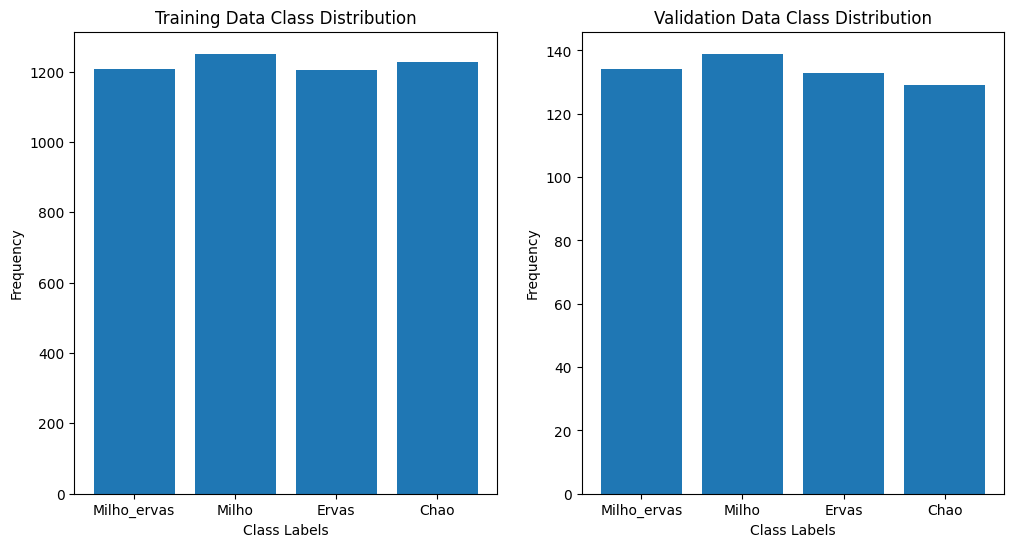

In [8]:
train_labels = train_data.class_labels
valid_labels = valid_data.class_labels

train_label_counts = collections.Counter(train_labels)
valid_label_counts = collections.Counter(valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for training data
ax1.bar(train_label_counts.keys(), train_label_counts.values())
ax1.set_title('Training Data Class Distribution')
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Frequency')

# Plot for validation data
ax2.bar(valid_label_counts.keys(), valid_label_counts.values())
ax2.set_title('Validation Data Class Distribution')
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Frequency')

plt.show()


### **Retrive batch from the train_dataloader and plotting first image sample image with its corresponded label and tensor shape**

In [9]:
# prompt: config class for CNN

class CONFIG():
    def __init__(self):
        self.input_shape = (3, 256, 256)
        self.num_classes = 4
        self.batch_size = 16
        self.epochs = 50
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = CONFIG()

In [10]:
train_dataloader = DataLoader(train_data, batch_size=config.batch_size*2, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=config.batch_size, shuffle=True)

# retrive batch images,labels from the train_dataloader
train_images, train_labels = next(iter(train_dataloader))

train image tensor shape: torch.Size([32, 3, 256, 256])



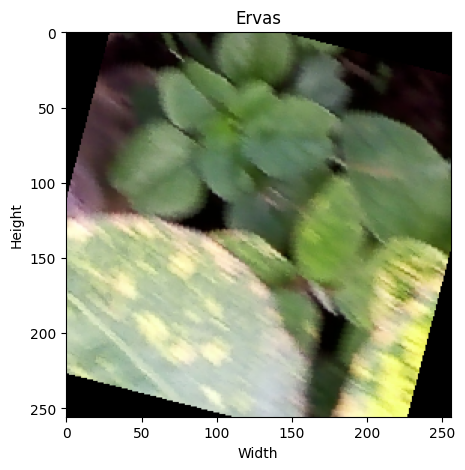

In [11]:
print(f"train image tensor shape: {train_images.size()}")
print()
# Selecting the first image and its corresponding label
img = train_images[0]
label = train_labels[0]
plt.figure(figsize=(5, 5))
plt.imshow(img.permute(1, 2, 0).detach().numpy())
# this line above takes image apply permutation to (height=520, width=520,channels=3)
# apply detach to convert it to PIL from Tensor and convert it to numpy so that we can plot it
plt.title(decode_target(label))
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# ***Defining Basline CNN model***

Defining Baseline CNN has four conv layers in every layer we augment number of features and we apply max pooling to reduce and dropout at the last layer    

In [12]:
import torch
import torch.nn as nn

# Define the CNN architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=4, use_batch_norm=False, use_dropout=False):
        super(BaselineCNN, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(32)
            self.bn2 = nn.BatchNorm2d(64)
            self.bn3 = nn.BatchNorm2d(128)
            self.bn4 = nn.BatchNorm2d(256)
        if self.use_dropout:
            self.dropout = nn.Dropout(0.5)  # Adding dropout layer for regularization

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        if self.use_batch_norm:
            x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        if self.use_batch_norm:
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        if self.use_batch_norm:
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.pool(torch.relu(self.conv4(x)))
        if self.use_batch_norm:
            x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 16 * 16)
        if self.use_dropout:
            x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

Summary of network to ViZ number of Pramas the flow of the input and its shape after every Layer as is shown below

In [13]:
!pip install -q torchsummary

In [14]:
from torchsummary import summary

train_images, train_labels = next(iter(train_dataloader))

def testing_model(model,train_images, train_labels):
    model =  model.to(config.device)
    x = torch.randn((32,3,256,256))
    preds = model(train_images.to(config.device))
    print(x.shape)
    print(preds.shape)
    return preds

model = BaselineCNN(num_classes = 4)
preds = testing_model(model,train_images, train_labels)

torch.Size([32, 3, 256, 256])
torch.Size([32, 4])


In [15]:
# Creating an instance of the network-
device = config.device
model.to(config.device)

# Printing the summary of the model
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
         MaxPool2d-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         295,168
         MaxPool2d-8          [-1, 256, 16, 16]               0
            Linear-9                  [-1, 512]      33,554,944
           Linear-10                    [-1, 4]           2,052
Total params: 33,945,412
Trainable params: 33,945,412
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 37.50
Params size (MB): 129.49
Es

***testing_model*** function is check to see if the model works as its expected input is tensor(64,3,256,256) output is tensor (64,4) which is means that every image in batch of 64 images are classified in one of the 4 classes   

# Training Loop

### **Early Stopping class**

In [16]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

# Engine class holds 
*    ##### train_batch method for training a batch from the train_loader
*    ##### validate_batch method for validation and extracting the metrics and valid loss from valid loader batch
*    ##### defining class engine contains Training and validation methodes
*    ##### for each batch we get the image and its label we move them to gpu
*    ##### we call model to predict on the image(ims)
*    ##### we calculate the loss and we update optimizer by calling step methode
*    ##### we return the loss calculated for the batch
*    ##### same process flowed with valid but we set model to eval and we remove the optimizer and we add accuracy metric

In [17]:
!pip install -q torcheval

In [18]:
import torch
from torch.optim import Adam, SGD
import numpy as np

class engine():
    def train_batch(model, data, optimizer, device):
        #setting the model to train
        model.train()
        #getting the data from the train laoder number of batches is 32
        ims, class_label = data
        #moving the data to the GPU
        ims = ims.to(device, dtype=torch.float)
        class_label = class_label.to(device, dtype=torch.float)
        #calling optimizer zero_grad (gradient clean up)
        optimizer.zero_grad()
        #predecting
        preds = model(ims)
        # claculating the loss
        loss = Loss(preds, class_label)
        # backward for model wieghts adjustment
        loss.backward()
        # optimizer step 
        optimizer.step()
        # getting argmax wchich is them max so we can calculate metrics 
        preds = torch.argmax(preds, dim=1)
        class_label = torch.argmax(class_label, dim=1)
        #we need to return the preds and labels for the run() methode so we can get the metrics for
        #each train batch and accumelate then to calculate the metrics
        
        return loss, ims, preds, class_label 
    
    #for inference we set no_grad()
    @torch.no_grad()
    def validate_batch(model, data, device):
        model.eval()
        ims, class_label = data
        ims = ims.to(device, dtype=torch.float)
        class_label = class_label.to(device, dtype=torch.float)
        preds = model(ims)
        loss = Loss(preds, class_label)

        # Calculate validation metrics
        preds = torch.argmax(preds, dim=1)
        class_label = torch.argmax(class_label, dim=1)

        return loss, ims, preds, class_label 

* run() methode will be called to lunch the network train and append the returned metrics into arrays so we can ViZ them after  
  - For each epoch we get batch from train loader and we train_batch and return the train loss and metrics and we append them to there proper array
  - same process done for the valid_batch

In [19]:
import copy
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy, Mean, MulticlassPrecision,MulticlassRecall,MulticlassF1Score,MulticlassConfusionMatrix


def run_train(model,train_dataloader,valid_dataloader,optimizer,prepro = None):
    best_accuracy = 0
    best_model_state = None
    epoch = 0
    done = False  # Early Stopping var  
    #loss metric
    train_loss_metric = Mean(device=config.device)
    valid_loss_metric = Mean(device=config.device)
    #acc
    train_acc_metric = MulticlassAccuracy(device=config.device)
    valid_acc_metric = MulticlassAccuracy(device=config.device)
    #f1
    valid_f1_metric = MulticlassF1Score(device=config.device)
    #recall
    valid_recall_metric = MulticlassRecall(device=config.device)
    #precision
    valid_precision_metric = MulticlassPrecision(device=config.device)
    
    train_acc_per_epoch = []
    train_loss_per_epoch = []
    valid_loss_per_epoch = []
    valid_acc_per_epoch = []
    valid_f1_per_epoch = []
    valid_recall_per_epoch = []
    valid_precision_per_epoch = []
    
    early_stopping = EarlyStopping(patience=5, min_delta=0, restore_best_weights=True)  # Instantiate EarlyStopping
    
    while epoch < config.epochs and not done:
        print("####################")
        print(f"       Epoch: {epoch}  ")
        print("####################")
        
        for bx, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            train_loss,ims, preds, class_label = engine.train_batch(model, data, optimizer, config.device)
            # update metrics
            train_loss_metric.update(train_loss.detach(), weight=len(ims))
            train_acc_metric.update(preds, class_label)
        # computing after epoch
        train_loss = train_loss_metric.compute()
        train_acc = train_acc_metric.compute()
        
        #appending list of the metrics computation per epoch
        train_loss_per_epoch.append(train_loss)
        train_acc_per_epoch.append(train_acc)
        
        for bx, data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
            valid_loss, ims, preds, class_label = engine.validate_batch(model, data, config.device)
            # update metrics
            valid_loss_metric.update(valid_loss.detach(), weight=len(ims))
            valid_f1_metric.update(preds, class_label)
            valid_acc_metric.update(preds, class_label)
            valid_recall_metric.update(preds, class_label)
            valid_precision_metric.update(preds, class_label)
            
        # computing after epoch     
        valid_loss = valid_loss_metric.compute()
        valid_f1 = valid_f1_metric.compute()
        valid_acc = valid_acc_metric.compute()
        valid_recall = valid_recall_metric.compute()
        valid_precision = valid_precision_metric.compute()
        
        if valid_acc > best_accuracy:
            best_accuracy = valid_acc
            best_model_state = copy.deepcopy(model)
        
        # appending results (loging metrics)
        valid_loss_per_epoch.append(valid_loss)
        valid_acc_per_epoch.append(valid_acc)
        valid_f1_per_epoch.append(valid_f1)
        valid_recall_per_epoch.append(valid_recall)
        valid_precision_per_epoch.append(valid_precision)
    
        #Check early stopping condition
        done = early_stopping(model, valid_loss)
        
        print('Epoch :', epoch, 
              'Train Loss :', train_loss, 
              'Valid Loss :', valid_loss, 
              'Valid Accuracy :', valid_acc, 
              'Valid f1 : ',valid_f1,
              'Valid Recall : ',valid_recall,
              'Valid Precision : ',valid_precision)
        
        epoch += 1  # Increment epoch counter
        train_acc_metric.reset()
        valid_acc_metric.reset()
        train_loss_metric.reset()
        valid_loss_metric.reset()
        valid_f1_metric.reset()
        valid_recall_metric.reset()
        valid_precision_metric.reset()
    
        
    return train_acc_per_epoch,train_loss_per_epoch,valid_loss_per_epoch,valid_acc_per_epoch,valid_f1_per_epoch,valid_recall_per_epoch,valid_precision_per_epoch,model


### **Define the Loss function optimizer & Init Model**
we refer to loss function as criterion

In [27]:
from torch.optim import Adam, RMSprop, Adagrad, SGD

ce = nn.CrossEntropyLoss()
es = EarlyStopping()

def Loss(preds, targets):
    ce_loss = ce(preds, targets)
    return ce_loss

def make_model(input_model, optimizer_type, lr):
    if optimizer_type == 'Adam':
        optimizer = Adam(input_model.parameters(), lr=lr)
    elif optimizer_type == 'RMSprop':
        optimizer = RMSprop(input_model.parameters(), lr=lr)
    elif optimizer_type == 'Adagrad':
        optimizer = Adagrad(input_model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = SGD(input_model.parameters(), lr=lr)
    else:
        raise ValueError("Invalid optimizer type. Supported types are 'Adam', 'RMSprop', 'Adagrad', and 'SGD'.")

    model = torch.compile(input_model, backend="aot_eager").to(config.device)
    return model, optimizer

# Define your input_model and optimizers here
input_model = BaselineCNN()

optimizers = ['Adam', 'RMSprop', 'Adagrad', 'SGD']
learning_rates = [0.001, 0.01, 0.1, 0.0001]  # Define your learning rates

# Store the results for each combination of input_model, optimizer, and lr
results = {}

for optimizer_type, lr in zip(optimizers, learning_rates):
    model, optimizer = make_model(input_model, optimizer_type, lr)

    train_acc_per_epoch, train_loss_per_epoch, valid_loss_per_epoch, valid_acc_per_epoch, valid_f1_per_epoch, valid_recall_per_epoch, valid_precision_per_epoch, model = run_train(model, train_dataloader, valid_dataloader, optimizer)
    print()
    print(f"storing results for {optimizer_type, lr, model}")
    # Store the results in the dictionary
    results[(input_model, optimizer_type, lr)] = {
        'train_acc_per_epoch': train_acc_per_epoch,
        'train_loss_per_epoch': train_loss_per_epoch,
        'valid_loss_per_epoch': valid_loss_per_epoch,
        'valid_acc_per_epoch': valid_acc_per_epoch,
        'valid_f1_per_epoch': valid_f1_per_epoch,
        'valid_recall_per_epoch': valid_recall_per_epoch,
        'valid_precision_per_epoch': valid_precision_per_epoch,
        'model': model
    }

####################
       Epoch: 0  
####################


100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Epoch : 0 Train Loss : tensor(1.1844, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.0087, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.5178, device='cuda:0') Valid f1 :  tensor(0.5178, device='cuda:0') Valid Recall :  tensor(0.5178, device='cuda:0') Valid Precision :  tensor(0.5178, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:03<00:00,  8.50it/s]


Epoch : 1 Train Loss : tensor(0.9351, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8944, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6112, device='cuda:0') Valid f1 :  tensor(0.6112, device='cuda:0') Valid Recall :  tensor(0.6112, device='cuda:0') Valid Precision :  tensor(0.6112, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:03<00:00,  8.76it/s]


Epoch : 2 Train Loss : tensor(0.7885, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7446, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6561, device='cuda:0') Valid f1 :  tensor(0.6561, device='cuda:0') Valid Recall :  tensor(0.6561, device='cuda:0') Valid Precision :  tensor(0.6561, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:04<00:00,  8.12it/s]


Epoch : 3 Train Loss : tensor(0.7328, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7568, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6710, device='cuda:0') Valid f1 :  tensor(0.6710, device='cuda:0') Valid Recall :  tensor(0.6710, device='cuda:0') Valid Precision :  tensor(0.6710, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


Epoch : 4 Train Loss : tensor(0.6960, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6917, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6897, device='cuda:0') Valid f1 :  tensor(0.6897, device='cuda:0') Valid Recall :  tensor(0.6897, device='cuda:0') Valid Precision :  tensor(0.6897, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:04<00:00,  8.25it/s]


Epoch : 5 Train Loss : tensor(0.6565, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7291, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7065, device='cuda:0') Valid f1 :  tensor(0.7065, device='cuda:0') Valid Recall :  tensor(0.7065, device='cuda:0') Valid Precision :  tensor(0.7065, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:04<00:00,  8.44it/s]


Epoch : 6 Train Loss : tensor(0.6387, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6453, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7421, device='cuda:0') Valid f1 :  tensor(0.7421, device='cuda:0') Valid Recall :  tensor(0.7421, device='cuda:0') Valid Precision :  tensor(0.7421, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:03<00:00,  8.70it/s]


Epoch : 7 Train Loss : tensor(0.6090, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6483, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7047, device='cuda:0') Valid f1 :  tensor(0.7047, device='cuda:0') Valid Recall :  tensor(0.7047, device='cuda:0') Valid Precision :  tensor(0.7047, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:04<00:00,  8.34it/s]


Epoch : 8 Train Loss : tensor(0.6063, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6547, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6841, device='cuda:0') Valid f1 :  tensor(0.6841, device='cuda:0') Valid Recall :  tensor(0.6841, device='cuda:0') Valid Precision :  tensor(0.6841, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:03<00:00,  8.64it/s]


Epoch : 9 Train Loss : tensor(0.6037, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6146, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7477, device='cuda:0') Valid f1 :  tensor(0.7477, device='cuda:0') Valid Recall :  tensor(0.7477, device='cuda:0') Valid Precision :  tensor(0.7477, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch : 10 Train Loss : tensor(0.5720, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6281, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7477, device='cuda:0') Valid f1 :  tensor(0.7477, device='cuda:0') Valid Recall :  tensor(0.7477, device='cuda:0') Valid Precision :  tensor(0.7477, device='cuda:0')
####################
       Epoch: 11  
####################


100%|██████████| 34/34 [00:03<00:00,  8.52it/s]


Epoch : 11 Train Loss : tensor(0.5726, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6727, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6822, device='cuda:0') Valid f1 :  tensor(0.6822, device='cuda:0') Valid Recall :  tensor(0.6822, device='cuda:0') Valid Precision :  tensor(0.6822, device='cuda:0')
####################
       Epoch: 12  
####################


100%|██████████| 34/34 [00:04<00:00,  8.19it/s]


Epoch : 12 Train Loss : tensor(0.5458, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6308, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 13  
####################


100%|██████████| 34/34 [00:04<00:00,  8.22it/s]


Epoch : 13 Train Loss : tensor(0.5249, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7423, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7346, device='cuda:0') Valid f1 :  tensor(0.7346, device='cuda:0') Valid Recall :  tensor(0.7346, device='cuda:0') Valid Precision :  tensor(0.7346, device='cuda:0')
####################
       Epoch: 14  
####################


100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


Epoch : 14 Train Loss : tensor(0.5180, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6578, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7196, device='cuda:0') Valid f1 :  tensor(0.7196, device='cuda:0') Valid Recall :  tensor(0.7196, device='cuda:0') Valid Precision :  tensor(0.7196, device='cuda:0')

storing results for ('Adam', 0.001, OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
))
####################
       Epoch: 0  
####

100%|██████████| 34/34 [00:04<00:00,  8.29it/s]


Epoch : 0 Train Loss : tensor(9050.4261, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4302, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2411, device='cuda:0') Valid f1 :  tensor(0.2411, device='cuda:0') Valid Recall :  tensor(0.2411, device='cuda:0') Valid Precision :  tensor(0.2411, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:03<00:00,  8.51it/s]


Epoch : 1 Train Loss : tensor(1.2543, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4963, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2841, device='cuda:0') Valid f1 :  tensor(0.2841, device='cuda:0') Valid Recall :  tensor(0.2841, device='cuda:0') Valid Precision :  tensor(0.2841, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:03<00:00,  8.57it/s]


Epoch : 2 Train Loss : tensor(1.3294, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.5396, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2486, device='cuda:0') Valid f1 :  tensor(0.2486, device='cuda:0') Valid Recall :  tensor(0.2486, device='cuda:0') Valid Precision :  tensor(0.2486, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:04<00:00,  8.49it/s]


Epoch : 3 Train Loss : tensor(1.3887, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3957, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2505, device='cuda:0') Valid f1 :  tensor(0.2505, device='cuda:0') Valid Recall :  tensor(0.2505, device='cuda:0') Valid Precision :  tensor(0.2505, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:03<00:00,  8.58it/s]


Epoch : 4 Train Loss : tensor(1.3915, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3903, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:03<00:00,  8.51it/s]


Epoch : 5 Train Loss : tensor(1.3880, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3892, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2411, device='cuda:0') Valid f1 :  tensor(0.2411, device='cuda:0') Valid Recall :  tensor(0.2411, device='cuda:0') Valid Precision :  tensor(0.2411, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:03<00:00,  8.86it/s]


Epoch : 6 Train Loss : tensor(1.3883, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3873, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2411, device='cuda:0') Valid f1 :  tensor(0.2411, device='cuda:0') Valid Recall :  tensor(0.2411, device='cuda:0') Valid Precision :  tensor(0.2411, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:04<00:00,  8.22it/s]


Epoch : 7 Train Loss : tensor(1.3881, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3866, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2486, device='cuda:0') Valid f1 :  tensor(0.2486, device='cuda:0') Valid Recall :  tensor(0.2486, device='cuda:0') Valid Precision :  tensor(0.2486, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:04<00:00,  8.22it/s]


Epoch : 8 Train Loss : tensor(1.3877, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3901, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:03<00:00,  8.53it/s]


Epoch : 9 Train Loss : tensor(1.3881, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3865, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2486, device='cuda:0') Valid f1 :  tensor(0.2486, device='cuda:0') Valid Recall :  tensor(0.2486, device='cuda:0') Valid Precision :  tensor(0.2486, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:03<00:00,  8.73it/s]


Epoch : 10 Train Loss : tensor(1.3877, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3877, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 11  
####################


100%|██████████| 34/34 [00:03<00:00,  8.78it/s]


Epoch : 11 Train Loss : tensor(1.3875, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3863, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 12  
####################


100%|██████████| 34/34 [00:03<00:00,  8.61it/s]


Epoch : 12 Train Loss : tensor(1.3875, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3870, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2411, device='cuda:0') Valid f1 :  tensor(0.2411, device='cuda:0') Valid Recall :  tensor(0.2411, device='cuda:0') Valid Precision :  tensor(0.2411, device='cuda:0')
####################
       Epoch: 13  
####################


100%|██████████| 34/34 [00:03<00:00,  8.71it/s]


Epoch : 13 Train Loss : tensor(1.3877, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3866, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 14  
####################


100%|██████████| 34/34 [00:04<00:00,  8.36it/s]


Epoch : 14 Train Loss : tensor(1.3874, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3864, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2505, device='cuda:0') Valid f1 :  tensor(0.2505, device='cuda:0') Valid Recall :  tensor(0.2505, device='cuda:0') Valid Precision :  tensor(0.2505, device='cuda:0')
####################
       Epoch: 15  
####################


100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


Epoch : 15 Train Loss : tensor(1.3875, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3888, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2411, device='cuda:0') Valid f1 :  tensor(0.2411, device='cuda:0') Valid Recall :  tensor(0.2411, device='cuda:0') Valid Precision :  tensor(0.2411, device='cuda:0')
####################
       Epoch: 16  
####################


100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


Epoch : 16 Train Loss : tensor(1.3872, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3867, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')

storing results for ('RMSprop', 0.01, OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
))
####################
       Epoch: 0  
##

100%|██████████| 34/34 [00:04<00:00,  8.27it/s]


Epoch : 0 Train Loss : tensor(1.3889, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3864, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2486, device='cuda:0') Valid f1 :  tensor(0.2486, device='cuda:0') Valid Recall :  tensor(0.2486, device='cuda:0') Valid Precision :  tensor(0.2486, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:04<00:00,  8.49it/s]


Epoch : 1 Train Loss : tensor(1.3870, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3863, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:03<00:00,  8.79it/s]


Epoch : 2 Train Loss : tensor(1.3869, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3864, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:04<00:00,  8.46it/s]


Epoch : 3 Train Loss : tensor(1.3867, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:03<00:00,  8.55it/s]


Epoch : 4 Train Loss : tensor(1.3867, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3863, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


Epoch : 5 Train Loss : tensor(1.3867, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3863, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:03<00:00,  8.60it/s]


Epoch : 6 Train Loss : tensor(1.3866, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3864, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:03<00:00,  8.63it/s]


Epoch : 7 Train Loss : tensor(1.3865, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3864, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:03<00:00,  8.82it/s]


Epoch : 8 Train Loss : tensor(1.3866, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3863, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')

storing results for ('Adagrad', 0.1, OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
))
####################
       Epoch: 0  
####

100%|██████████| 34/34 [00:04<00:00,  8.48it/s]


Epoch : 0 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:04<00:00,  7.82it/s]


Epoch : 1 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:04<00:00,  8.44it/s]


Epoch : 2 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:03<00:00,  8.89it/s]


Epoch : 3 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:04<00:00,  8.17it/s]


Epoch : 4 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:03<00:00,  8.74it/s]


Epoch : 5 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:03<00:00,  8.83it/s]


Epoch : 6 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:04<00:00,  8.36it/s]


Epoch : 7 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:04<00:00,  8.45it/s]


Epoch : 8 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:03<00:00,  8.88it/s]


Epoch : 9 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:03<00:00,  8.58it/s]


Epoch : 10 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 11  
####################


100%|██████████| 34/34 [00:03<00:00,  8.82it/s]


Epoch : 11 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 12  
####################


100%|██████████| 34/34 [00:03<00:00,  8.60it/s]


Epoch : 12 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 13  
####################


100%|██████████| 34/34 [00:04<00:00,  8.43it/s]


Epoch : 13 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 14  
####################


100%|██████████| 34/34 [00:03<00:00,  8.71it/s]


Epoch : 14 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 15  
####################


100%|██████████| 34/34 [00:03<00:00,  8.75it/s]


Epoch : 15 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 16  
####################


100%|██████████| 34/34 [00:03<00:00,  8.69it/s]


Epoch : 16 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 17  
####################


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch : 17 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 18  
####################


100%|██████████| 34/34 [00:03<00:00,  8.58it/s]


Epoch : 18 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 19  
####################


100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


Epoch : 19 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 20  
####################


100%|██████████| 34/34 [00:04<00:00,  8.35it/s]


Epoch : 20 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 21  
####################


100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


Epoch : 21 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 22  
####################


100%|██████████| 34/34 [00:03<00:00,  8.88it/s]


Epoch : 22 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 23  
####################


100%|██████████| 34/34 [00:03<00:00,  8.56it/s]


Epoch : 23 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 24  
####################


100%|██████████| 34/34 [00:04<00:00,  8.40it/s]


Epoch : 24 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 25  
####################


100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


Epoch : 25 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 26  
####################


100%|██████████| 34/34 [00:04<00:00,  8.39it/s]


Epoch : 26 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 27  
####################


100%|██████████| 34/34 [00:04<00:00,  8.48it/s]


Epoch : 27 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 28  
####################


100%|██████████| 34/34 [00:04<00:00,  8.34it/s]


Epoch : 28 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 29  
####################


100%|██████████| 34/34 [00:03<00:00,  8.61it/s]


Epoch : 29 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 30  
####################


100%|██████████| 34/34 [00:04<00:00,  8.36it/s]


Epoch : 30 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 31  
####################


100%|██████████| 34/34 [00:04<00:00,  8.22it/s]


Epoch : 31 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 32  
####################


100%|██████████| 34/34 [00:03<00:00,  8.76it/s]


Epoch : 32 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 33  
####################


100%|██████████| 34/34 [00:04<00:00,  7.94it/s]


Epoch : 33 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 34  
####################


100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


Epoch : 34 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 35  
####################


100%|██████████| 34/34 [00:03<00:00,  8.76it/s]


Epoch : 35 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 36  
####################


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch : 36 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 37  
####################


100%|██████████| 34/34 [00:04<00:00,  8.29it/s]


Epoch : 37 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 38  
####################


100%|██████████| 34/34 [00:03<00:00,  8.56it/s]


Epoch : 38 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 39  
####################


100%|██████████| 34/34 [00:03<00:00,  8.50it/s]


Epoch : 39 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 40  
####################


100%|██████████| 34/34 [00:04<00:00,  8.35it/s]


Epoch : 40 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 41  
####################


100%|██████████| 34/34 [00:03<00:00,  8.76it/s]


Epoch : 41 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 42  
####################


100%|██████████| 34/34 [00:04<00:00,  8.36it/s]


Epoch : 42 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 43  
####################


100%|██████████| 34/34 [00:03<00:00,  8.69it/s]


Epoch : 43 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 44  
####################


100%|██████████| 34/34 [00:03<00:00,  8.75it/s]


Epoch : 44 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 45  
####################


100%|██████████| 34/34 [00:03<00:00,  8.62it/s]


Epoch : 45 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 46  
####################


100%|██████████| 34/34 [00:03<00:00,  8.60it/s]


Epoch : 46 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 47  
####################


100%|██████████| 34/34 [00:04<00:00,  8.47it/s]


Epoch : 47 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 48  
####################


100%|██████████| 34/34 [00:03<00:00,  8.69it/s]


Epoch : 48 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')
####################
       Epoch: 49  
####################


100%|██████████| 34/34 [00:04<00:00,  7.78it/s]

Epoch : 49 Train Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.2598, device='cuda:0') Valid f1 :  tensor(0.2598, device='cuda:0') Valid Recall :  tensor(0.2598, device='cuda:0') Valid Precision :  tensor(0.2598, device='cuda:0')

storing results for ('SGD', 0.0001, OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
))


# Results Metrics & Model Inference Viz

In [30]:
def plot_metric_per_epoch(metric_values, metric_name, point_min_max=True):
    # Extract values from tensors
    values = [t.item() for t in metric_values]

    # Plotting
    plt.figure(figsize=(10,5))
    
    # Plot values
    plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='-', label=metric_name)

    # Find min and max points
    if point_min_max:
        min_index = np.argmin(values)
        min_value = values[min_index]
        max_index = np.argmax(values)
        max_value = values[max_index]
        
        # Plot min point
        plt.scatter(min_index + 1, min_value, color='red', label=f'Min {metric_name}: {min_value:.4f}')
        
        # Plot max point
        plt.scatter(max_index + 1, max_value, color='green', label=f'Max {metric_name}: {max_value:.4f}')

    # Set title and labels
    plt.title(f'{metric_name} per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    
    # Add legend
    plt.legend()
    
    # Display grid
    plt.grid(True)
    
    # Show plot
    plt.show()

# Plotting ou Results
### Exprimentation on Baseline CNN 
* by excuting results.keys() we can get all the metrics available in the results varaible

In [27]:
def plot_metrics_per_model(results):
    for key in results.keys():
        input_model, optimizer, lr = key
        metrics = results[key]

        train_acc_per_epoch = metrics['train_acc_per_epoch']
        train_loss_per_epoch = metrics['train_loss_per_epoch']
        valid_loss_per_epoch = metrics['valid_loss_per_epoch']
        valid_acc_per_epoch = metrics['valid_acc_per_epoch']
        valid_f1_per_epoch = metrics['valid_f1_per_epoch']
        valid_recall_per_epoch = metrics['valid_recall_per_epoch']
        valid_precision_per_epoch = metrics['valid_precision_per_epoch']
        trained_model = metrics['model']

        print(f"Metrics for {trained_model} with optimizer {optimizer} and learning rate {lr}:")
        # Plotting all metrics
        plot_metric_per_epoch(train_acc_per_epoch, "Train Accuracy")
        plot_metric_per_epoch(train_loss_per_epoch, "Train Loss")
        plot_metric_per_epoch(valid_loss_per_epoch, "Validation Loss")
        plot_metric_per_epoch(valid_acc_per_epoch, "Validation Accuracy")
        plot_metric_per_epoch(valid_f1_per_epoch, "Validation F1 Score")
        plot_metric_per_epoch(valid_recall_per_epoch, "Validation Recall")
        plot_metric_per_epoch(valid_precision_per_epoch, "Validation Precision")

Metrics for OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
) with optimizer Adam and learning rate 0.001:


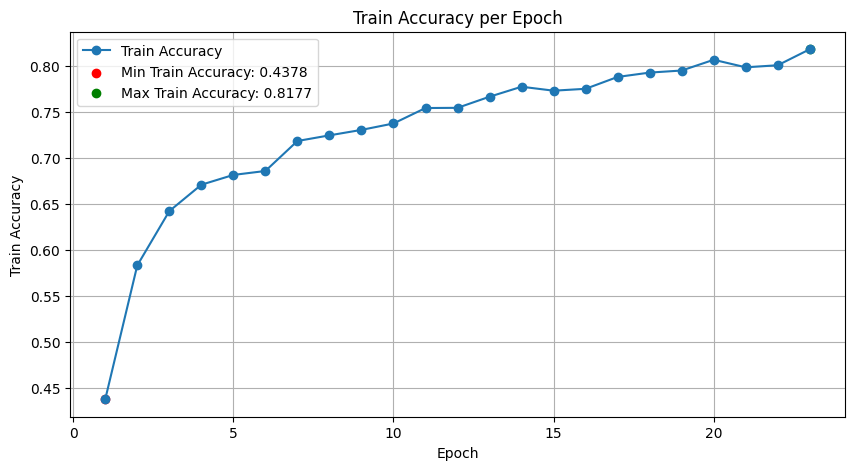

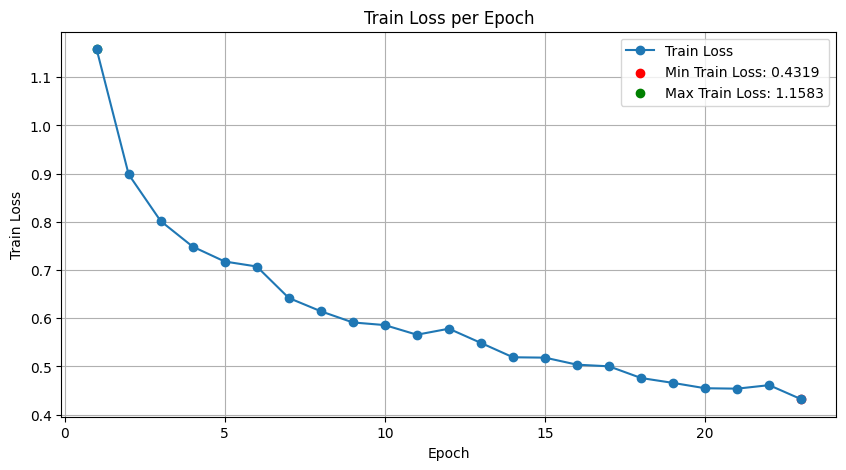

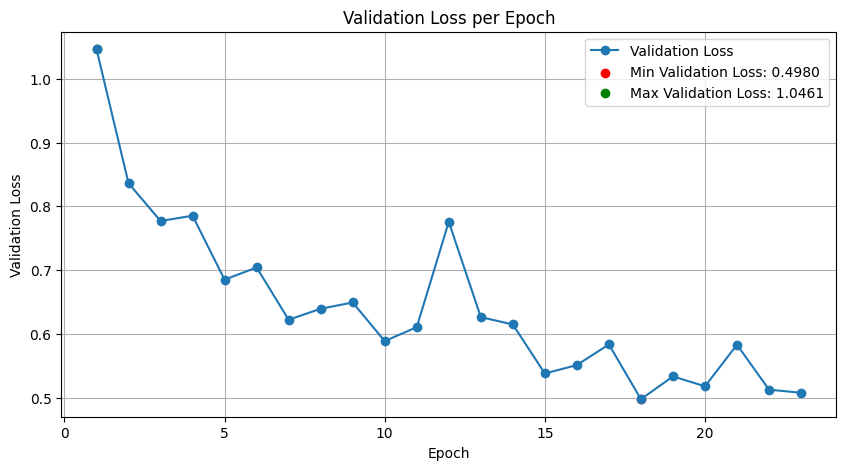

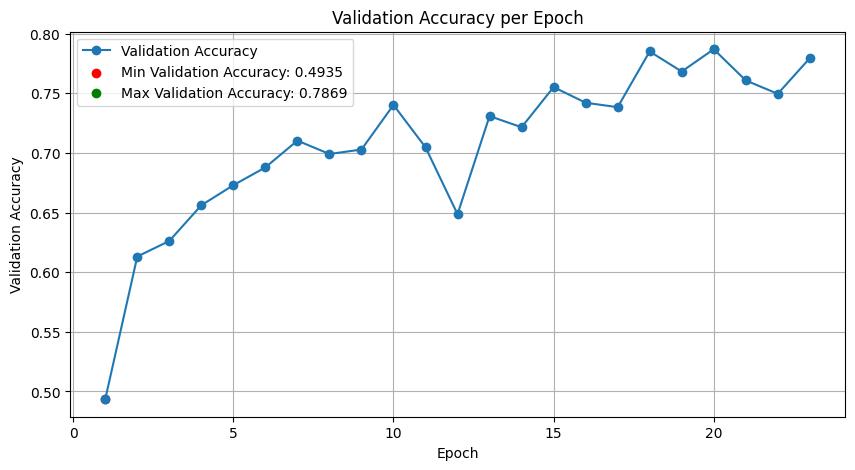

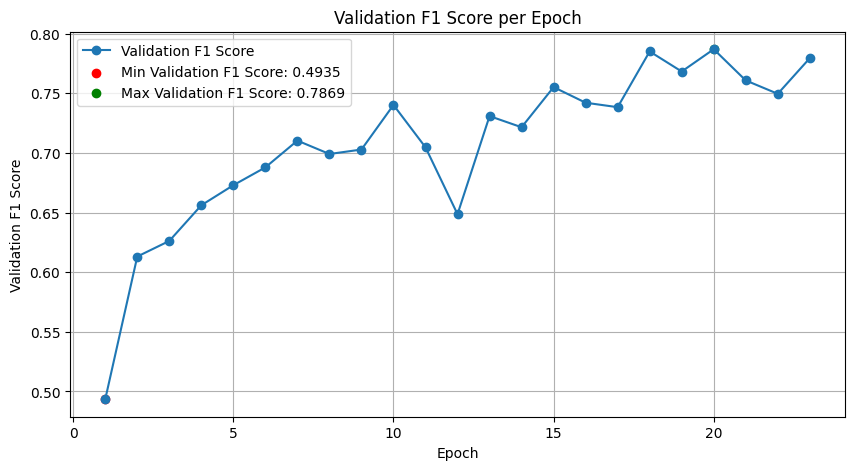

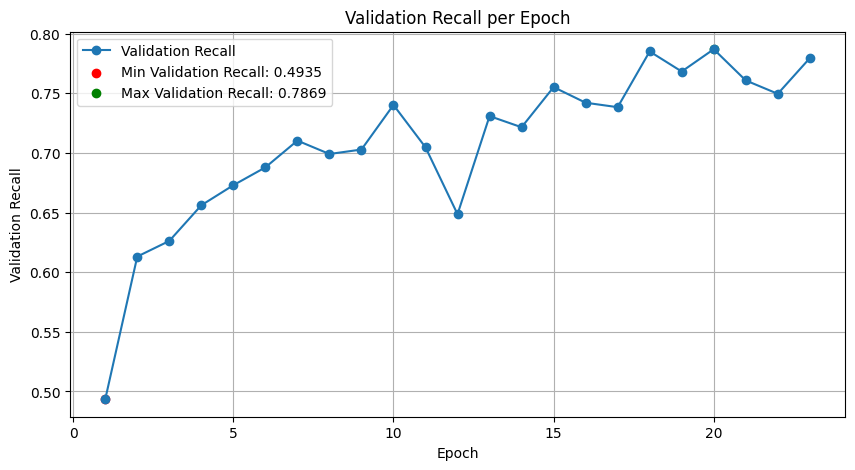

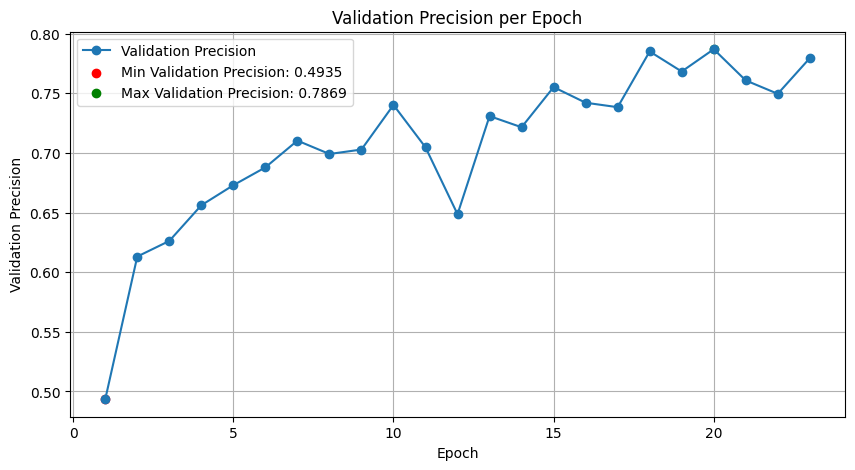

Metrics for OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
) with optimizer RMSprop and learning rate 0.01:


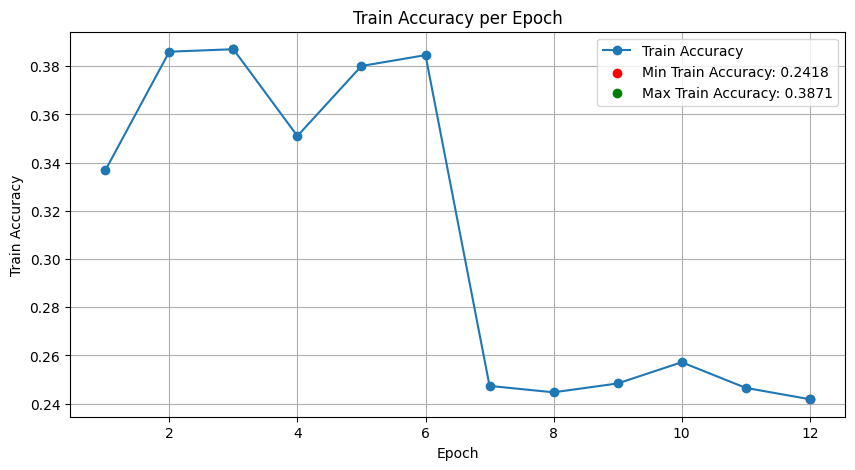

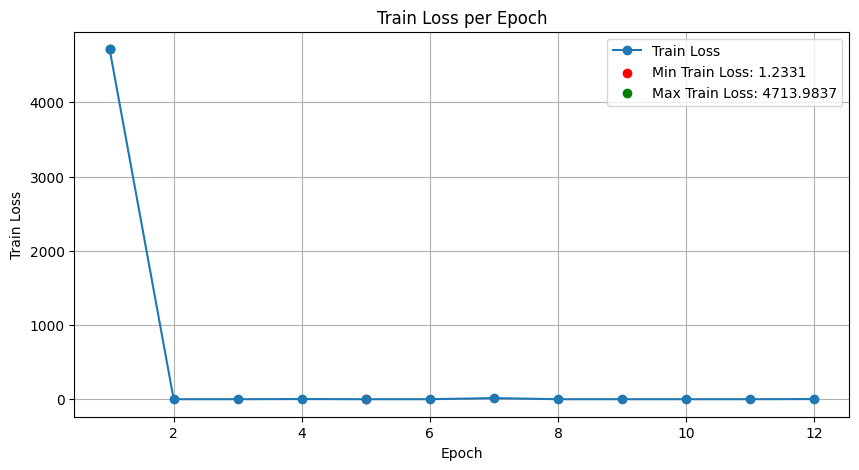

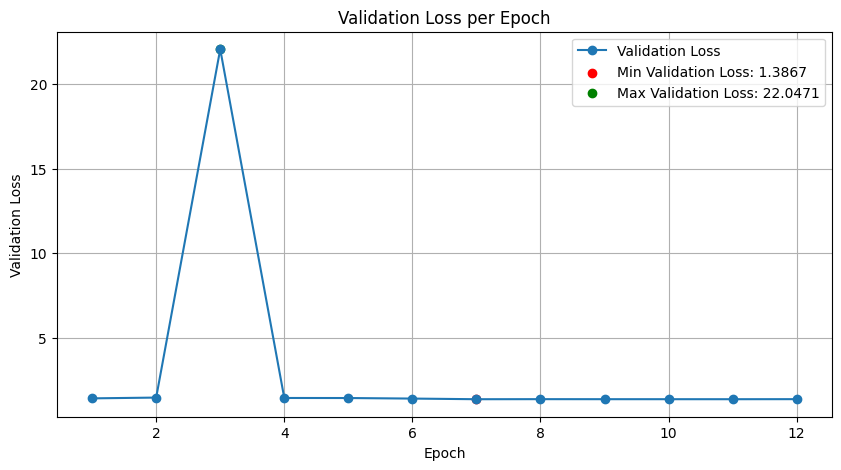

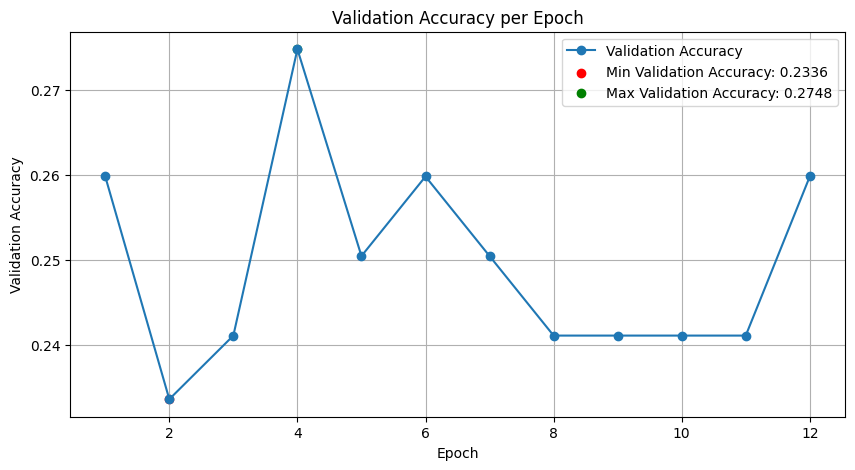

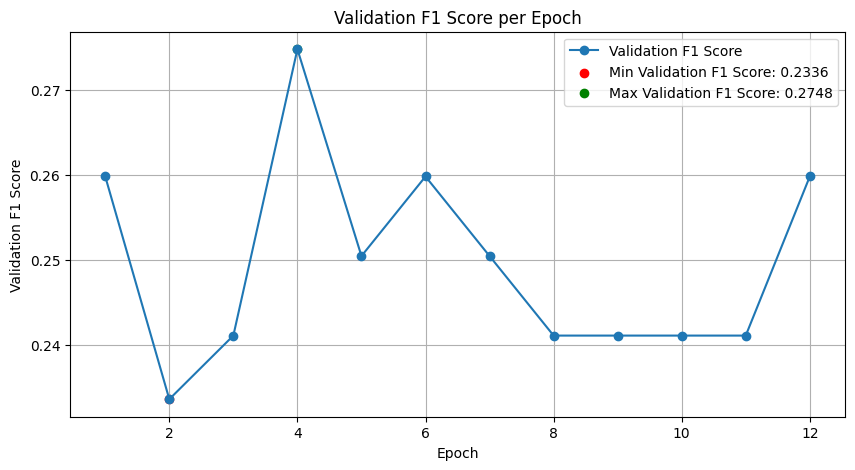

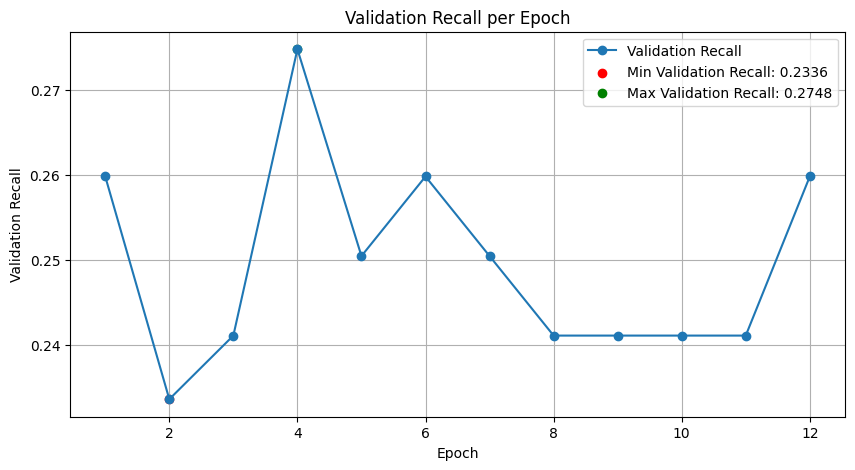

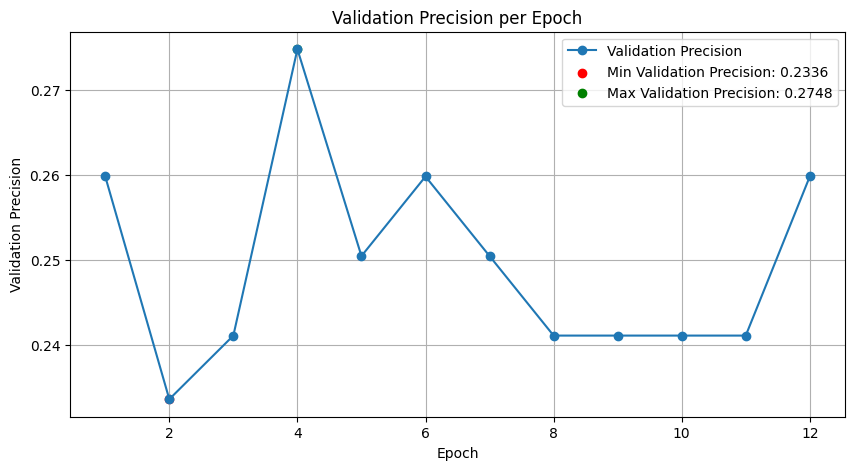

Metrics for OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
) with optimizer Adagrad and learning rate 0.1:


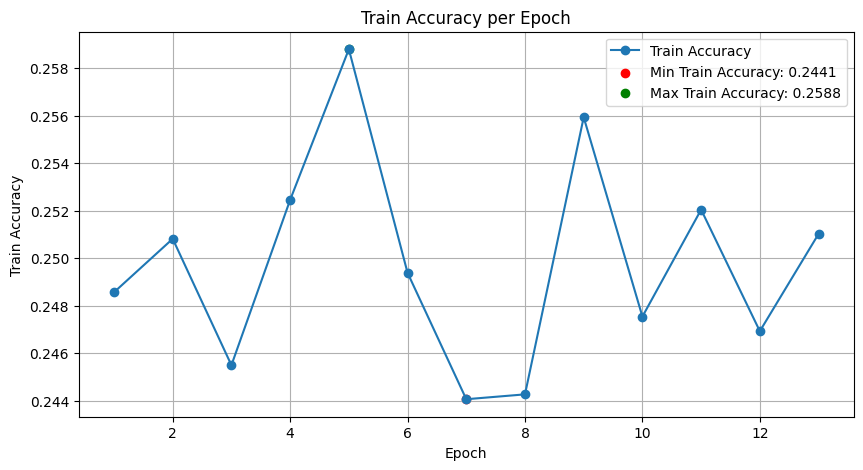

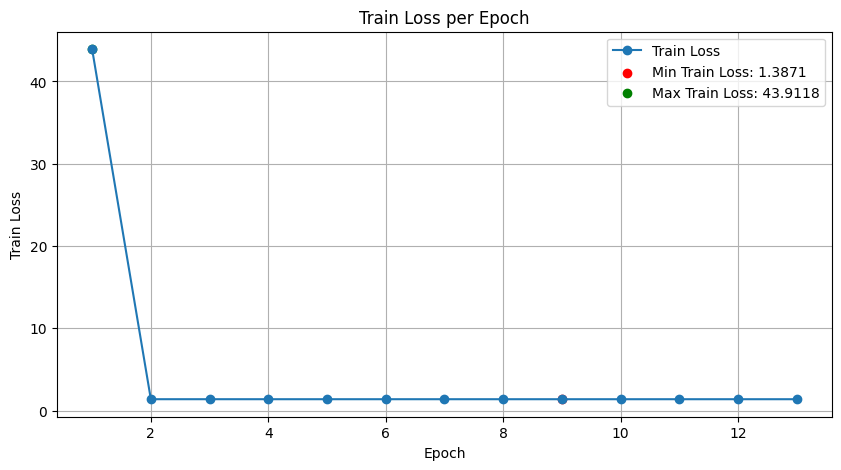

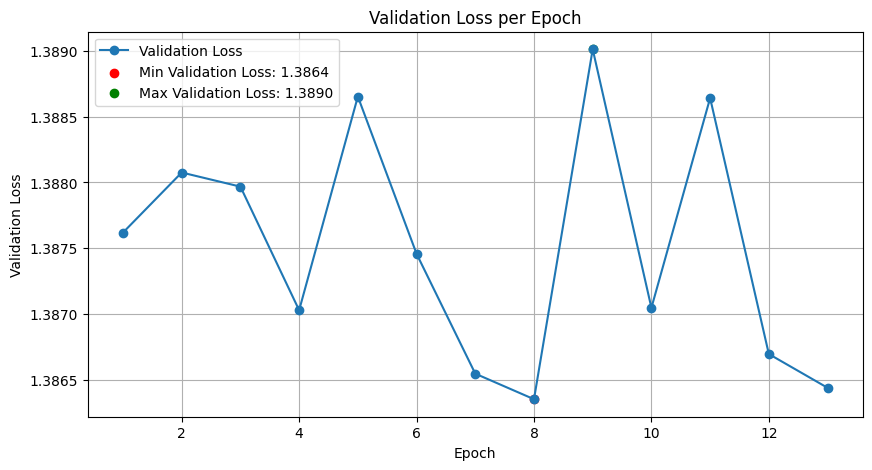

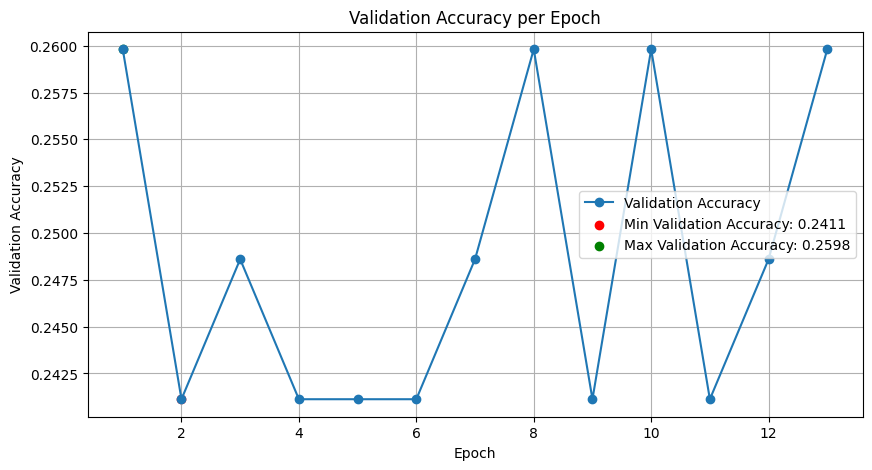

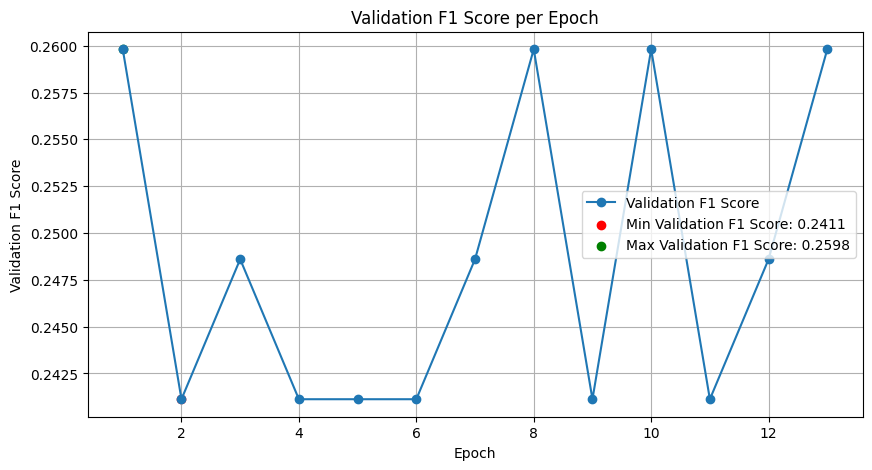

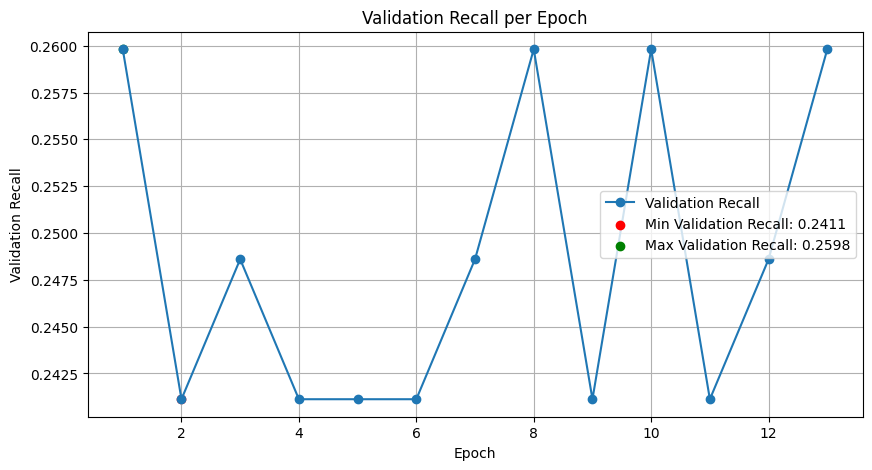

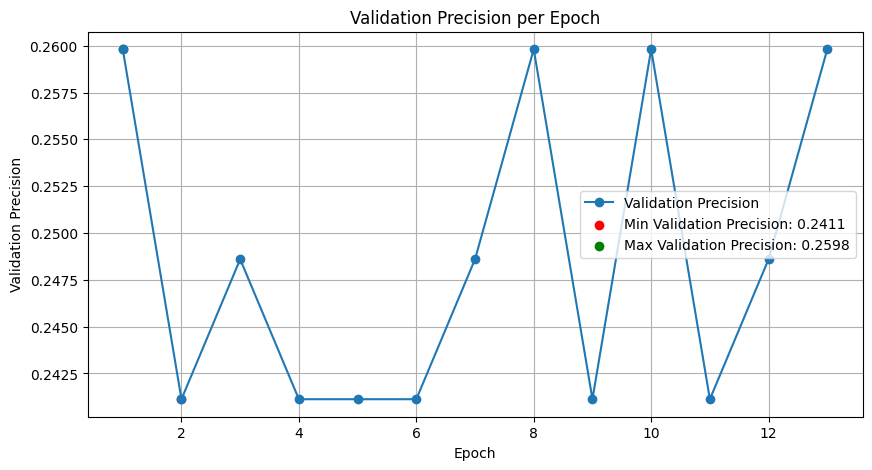

Metrics for OptimizedModule(
  (_orig_mod): BaselineCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=65536, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=4, bias=True)
  )
) with optimizer SGD and learning rate 0.0001:


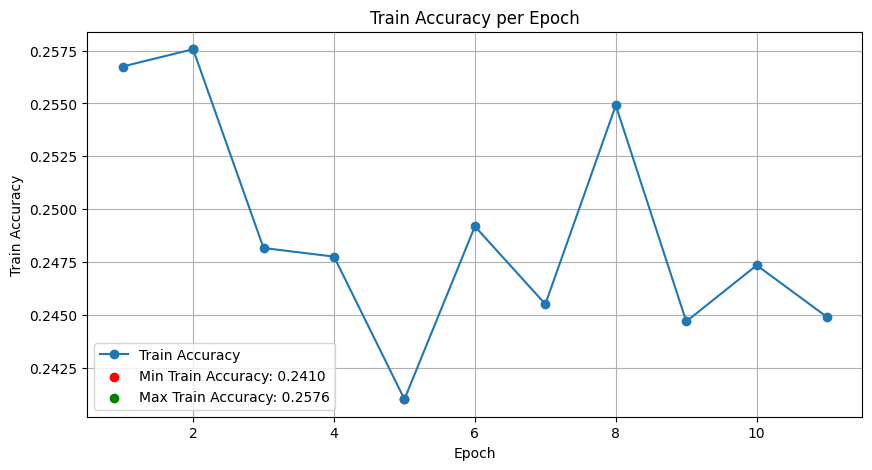

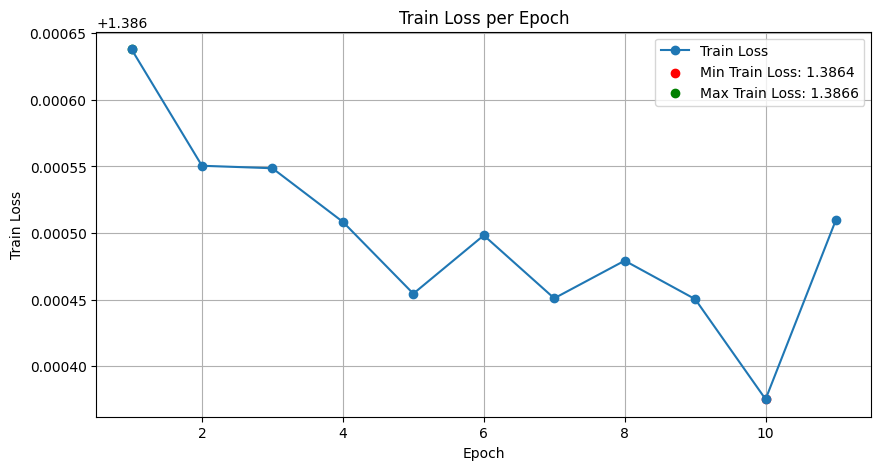

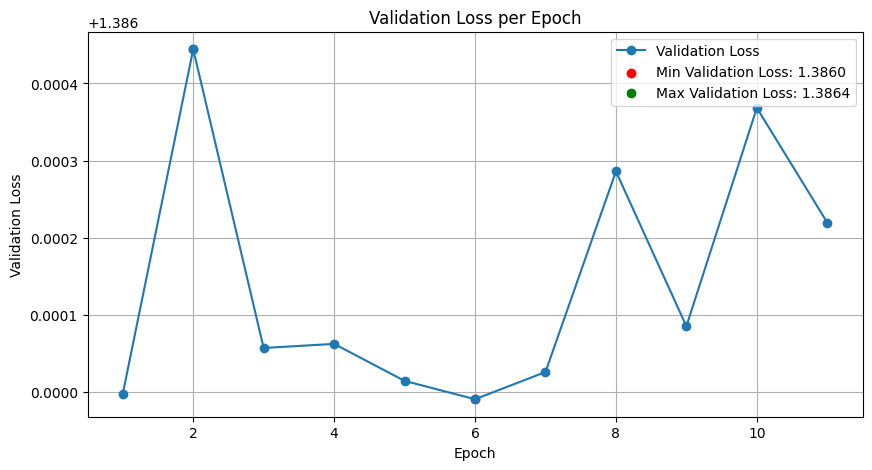

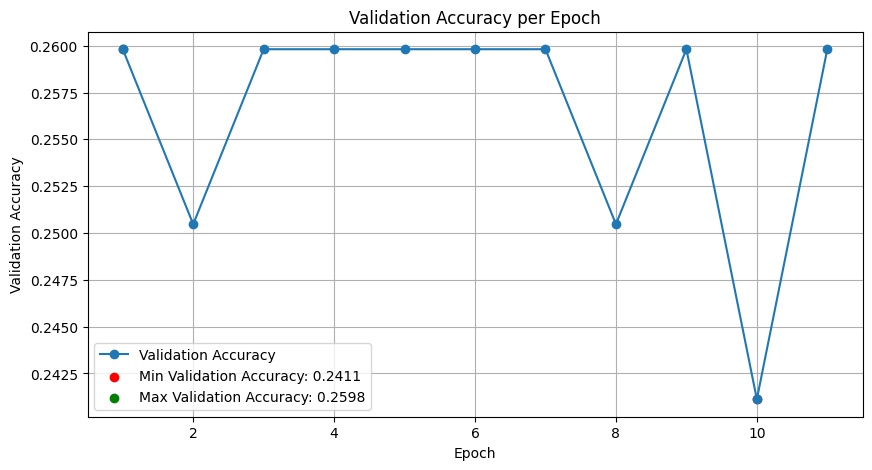

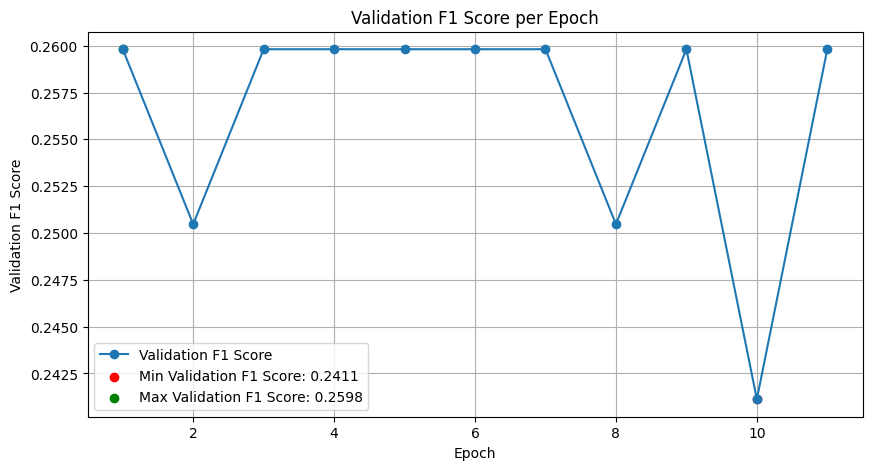

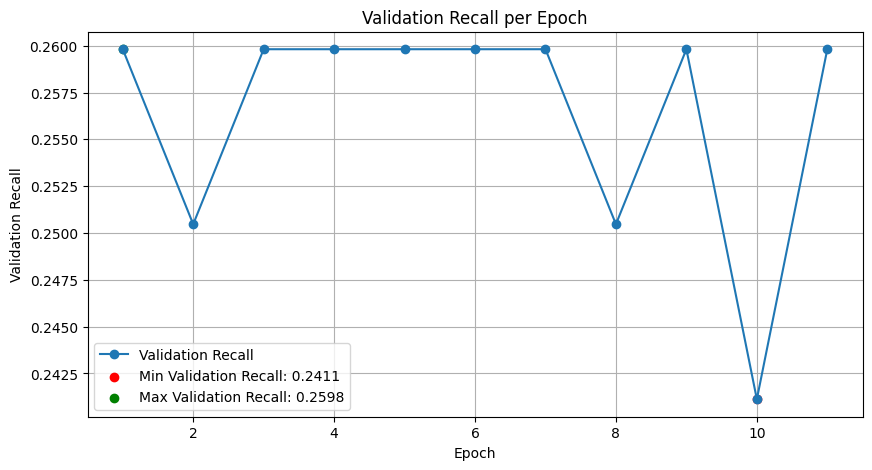

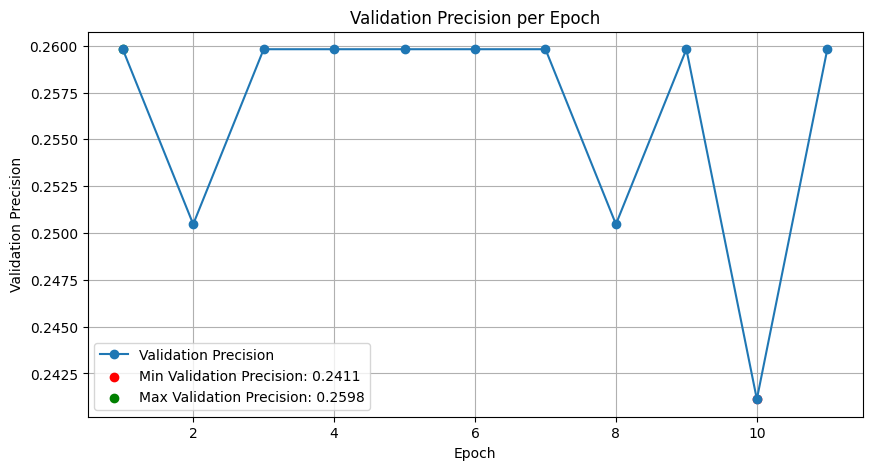

In [22]:
plot_metrics_per_model(results)

# Testing Inferance & Cofusion Metrics

In [28]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get class names
classes = ['Milho', 'Chao', 'Milho_ervas', 'Ervas']

def evaluate_model(results, classes, device, valid_transform):
    # Loop through the dictionary keys
    for key in results.keys():
        input_model, optimizer, lr = key
        metrics = results[key]
        model = metrics['model']
        # Setting model to evaluation mode
        model.eval()
        # Initialize confusion matrix (assuming you have 4 classes)
        metric = MulticlassConfusionMatrix(4)
        # Getting the test data
        test_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Teste", transform=valid_transform)
        # Create the test dataloader
        test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)
        # Retrieve a batch of test images and labels
        test_images, test_labels = next(iter(test_dataloader))
        # Moving the images and labels to GPU
        test_images = test_images.to(device, dtype=torch.float)
        test_labels = test_labels.to(device, dtype=torch.float)

        # Getting predictions from the model
        preds = model(test_images)
        # Getting argmax for both predictions and labels
        preds = torch.argmax(preds, dim=1)
        test_labels = torch.argmax(test_labels, dim=1)
        # Update the confusion matrix
        metric.update(preds, test_labels)
        # Compute the confusion matrix
        confusion_matrix = metric.compute()
        
        plot_confusion_matrix(confusion_matrix, classes)
        plt.show()

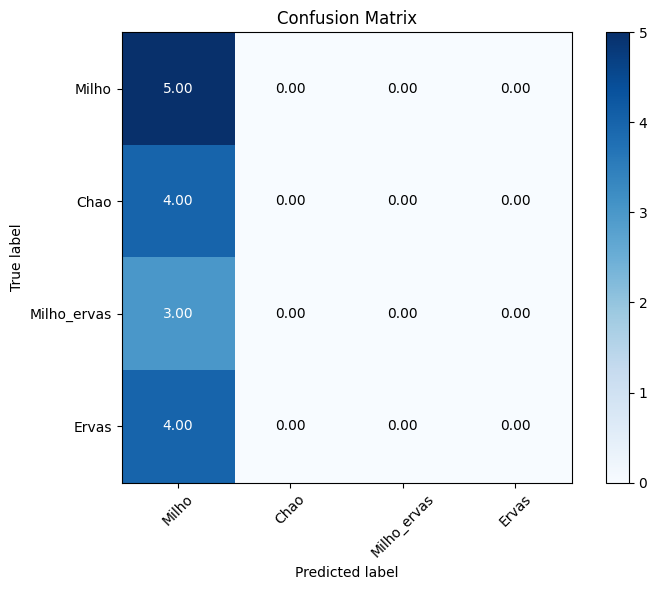

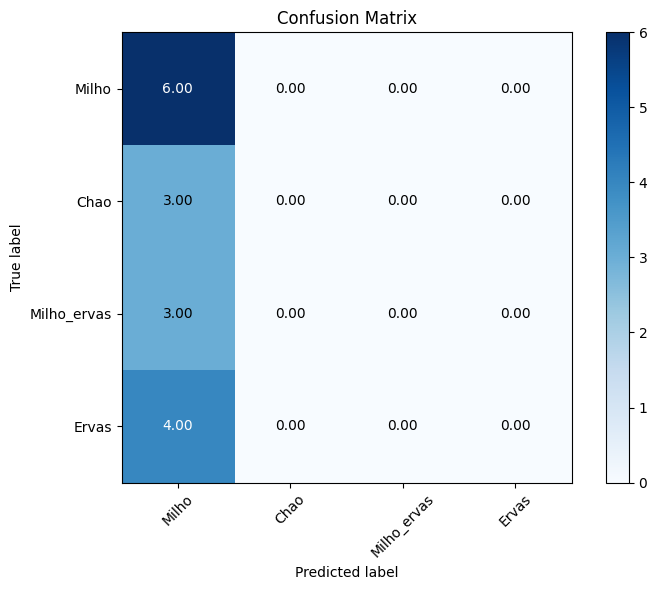

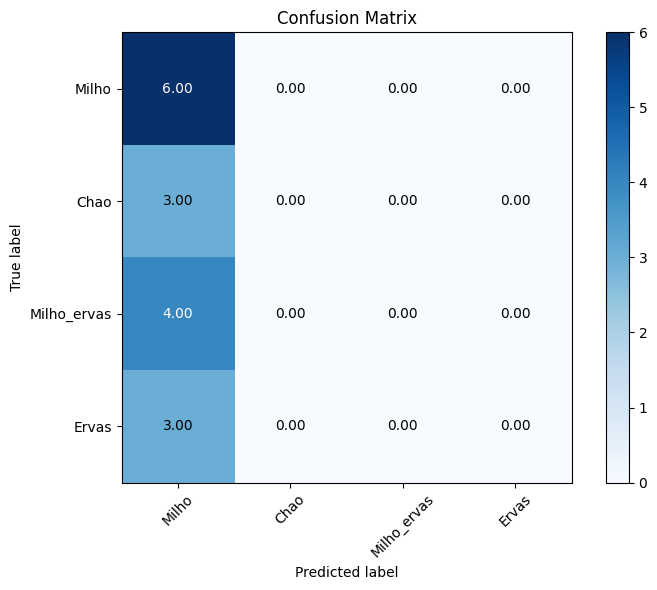

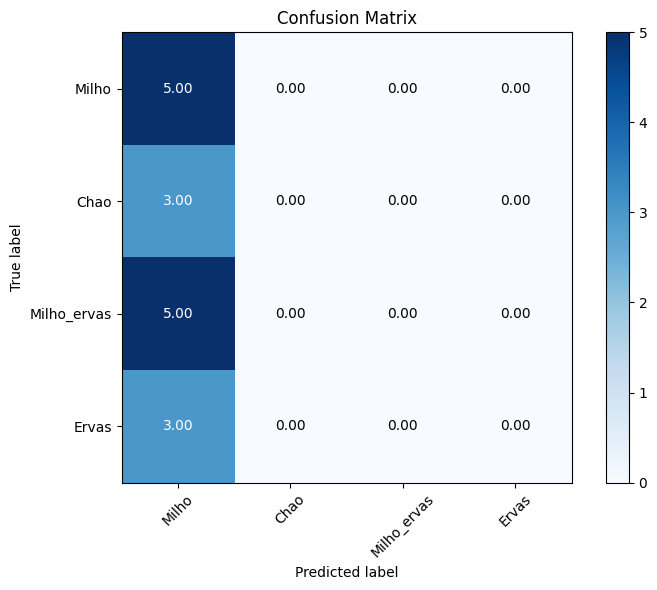

In [23]:
evaluate_model(results, classes, device, valid_transform)

# Transfer Learning

In transfer learning, the selection of models is influenced by PlantVillage's state-of-the-art CNN-based models. 
Despite being designed for plant pathology detection, we aim to leverage the best models on this dataset to exploit their capabilities for feature extraction and adapt them to our Task.

**"The PlantVillage dataset encompasses over 54,000 images of plant diseases and healthy plants, annotated for classification, serving as a crucial resource for training ML models in plant pathology and agricultural research."**

**Marko Arsenovic** and his team conducted comprehensive research on the state-of-the-art models on PlantVillage, as showed in a figure from his GitHub repository.

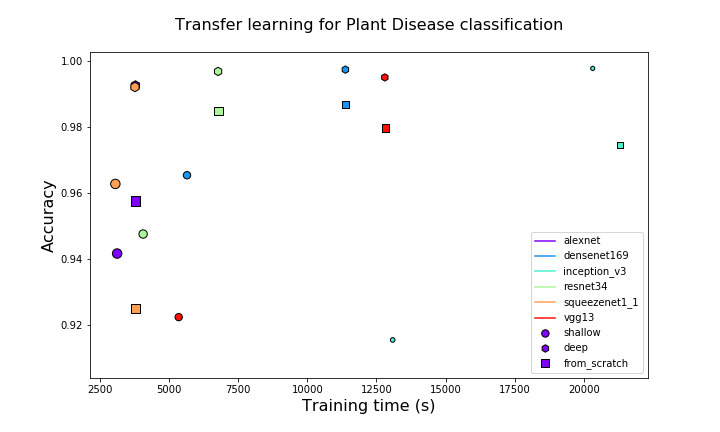

we will train these models : 
* Resnet
* VGG
* SqueezeNet
* DenseNet
* Inception v3


# Resnet50 Exprimentation

In [21]:
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights

In [25]:
# # Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()
resnet_model = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 4)
resnet_model = resnet_model.to(config.device)

train_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino",transform=preprocess)
valid_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Validação", transform=preprocess)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=16, shuffle=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s] 


In [26]:
# Store the results for each combination of input_model, optimizer, and lr
resnet50_results = {}

for optimizer_type, lr in zip(optimizers, learning_rates):
    model, optimizer = make_model(resnet_model, optimizer_type, lr)

    train_acc_per_epoch, train_loss_per_epoch, valid_loss_per_epoch, valid_acc_per_epoch, valid_f1_per_epoch, valid_recall_per_epoch, valid_precision_per_epoch, model = run_train(model, train_dataloader, valid_dataloader, optimizer)
    print()
    print(f"storing results for {optimizer_type, lr, model}")
    # Store the results in the dictionary
    resnet50_results[(input_model, optimizer_type, lr)] = {
        'train_acc_per_epoch': train_acc_per_epoch,
        'train_loss_per_epoch': train_loss_per_epoch,
        'valid_loss_per_epoch': valid_loss_per_epoch,
        'valid_acc_per_epoch': valid_acc_per_epoch,
        'valid_f1_per_epoch': valid_f1_per_epoch,
        'valid_recall_per_epoch': valid_recall_per_epoch,
        'valid_precision_per_epoch': valid_precision_per_epoch,
        'model': model
    }

####################
       Epoch: 0  
####################


100%|██████████| 34/34 [00:14<00:00,  2.39it/s]


Epoch : 0 Train Loss : tensor(0.8158, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7514, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6598, device='cuda:0') Valid f1 :  tensor(0.6598, device='cuda:0') Valid Recall :  tensor(0.6598, device='cuda:0') Valid Precision :  tensor(0.6598, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:05<00:00,  6.64it/s]


Epoch : 1 Train Loss : tensor(0.6012, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5677, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7813, device='cuda:0') Valid f1 :  tensor(0.7813, device='cuda:0') Valid Recall :  tensor(0.7813, device='cuda:0') Valid Precision :  tensor(0.7813, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Epoch : 2 Train Loss : tensor(0.5050, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5074, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7925, device='cuda:0') Valid f1 :  tensor(0.7925, device='cuda:0') Valid Recall :  tensor(0.7925, device='cuda:0') Valid Precision :  tensor(0.7925, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:05<00:00,  6.55it/s]


Epoch : 3 Train Loss : tensor(0.4521, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6366, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7514, device='cuda:0') Valid f1 :  tensor(0.7514, device='cuda:0') Valid Recall :  tensor(0.7514, device='cuda:0') Valid Precision :  tensor(0.7514, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:05<00:00,  6.28it/s]


Epoch : 4 Train Loss : tensor(0.3922, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8038, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7308, device='cuda:0') Valid f1 :  tensor(0.7308, device='cuda:0') Valid Recall :  tensor(0.7308, device='cuda:0') Valid Precision :  tensor(0.7308, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Epoch : 5 Train Loss : tensor(0.3653, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4183, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8299, device='cuda:0') Valid f1 :  tensor(0.8299, device='cuda:0') Valid Recall :  tensor(0.8299, device='cuda:0') Valid Precision :  tensor(0.8299, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:05<00:00,  6.53it/s]


Epoch : 6 Train Loss : tensor(0.3549, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5971, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7850, device='cuda:0') Valid f1 :  tensor(0.7850, device='cuda:0') Valid Recall :  tensor(0.7850, device='cuda:0') Valid Precision :  tensor(0.7850, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


Epoch : 7 Train Loss : tensor(0.3092, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6657, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7421, device='cuda:0') Valid f1 :  tensor(0.7421, device='cuda:0') Valid Recall :  tensor(0.7421, device='cuda:0') Valid Precision :  tensor(0.7421, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:05<00:00,  6.18it/s]


Epoch : 8 Train Loss : tensor(0.2709, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5704, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8056, device='cuda:0') Valid f1 :  tensor(0.8056, device='cuda:0') Valid Recall :  tensor(0.8056, device='cuda:0') Valid Precision :  tensor(0.8056, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Epoch : 9 Train Loss : tensor(0.2532, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5823, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8187, device='cuda:0') Valid f1 :  tensor(0.8187, device='cuda:0') Valid Recall :  tensor(0.8187, device='cuda:0') Valid Precision :  tensor(0.8187, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


Epoch : 10 Train Loss : tensor(0.2193, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4856, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8299, device='cuda:0') Valid f1 :  tensor(0.8299, device='cuda:0') Valid Recall :  tensor(0.8299, device='cuda:0') Valid Precision :  tensor(0.8299, device='cuda:0')

storing results for ('Adam', 0.001, OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

100%|██████████| 34/34 [00:05<00:00,  6.54it/s]


Epoch : 0 Train Loss : tensor(1.7427, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7533, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.4299, device='cuda:0') Valid f1 :  tensor(0.4299, device='cuda:0') Valid Recall :  tensor(0.4299, device='cuda:0') Valid Precision :  tensor(0.4299, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:05<00:00,  6.49it/s]


Epoch : 1 Train Loss : tensor(0.9234, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.0134, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.4935, device='cuda:0') Valid f1 :  tensor(0.4935, device='cuda:0') Valid Recall :  tensor(0.4935, device='cuda:0') Valid Precision :  tensor(0.4935, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:05<00:00,  6.65it/s]


Epoch : 2 Train Loss : tensor(0.8612, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.2270, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.4019, device='cuda:0') Valid f1 :  tensor(0.4019, device='cuda:0') Valid Recall :  tensor(0.4019, device='cuda:0') Valid Precision :  tensor(0.4019, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Epoch : 3 Train Loss : tensor(0.8012, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8024, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6860, device='cuda:0') Valid f1 :  tensor(0.6860, device='cuda:0') Valid Recall :  tensor(0.6860, device='cuda:0') Valid Precision :  tensor(0.6860, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch : 4 Train Loss : tensor(0.7590, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.1159, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.5234, device='cuda:0') Valid f1 :  tensor(0.5234, device='cuda:0') Valid Recall :  tensor(0.5234, device='cuda:0') Valid Precision :  tensor(0.5234, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Epoch : 5 Train Loss : tensor(0.7257, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.9148, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.5925, device='cuda:0') Valid f1 :  tensor(0.5925, device='cuda:0') Valid Recall :  tensor(0.5925, device='cuda:0') Valid Precision :  tensor(0.5925, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:05<00:00,  6.57it/s]


Epoch : 6 Train Loss : tensor(0.6860, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.1205, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.5009, device='cuda:0') Valid f1 :  tensor(0.5009, device='cuda:0') Valid Recall :  tensor(0.5009, device='cuda:0') Valid Precision :  tensor(0.5009, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:05<00:00,  6.44it/s]


Epoch : 7 Train Loss : tensor(0.6697, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8198, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6280, device='cuda:0') Valid f1 :  tensor(0.6280, device='cuda:0') Valid Recall :  tensor(0.6280, device='cuda:0') Valid Precision :  tensor(0.6280, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:05<00:00,  6.46it/s]


Epoch : 8 Train Loss : tensor(0.6425, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.2319, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6449, device='cuda:0') Valid f1 :  tensor(0.6449, device='cuda:0') Valid Recall :  tensor(0.6449, device='cuda:0') Valid Precision :  tensor(0.6449, device='cuda:0')

storing results for ('RMSprop', 0.01, OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


Epoch : 0 Train Loss : tensor(1.2556, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.0594, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.5738, device='cuda:0') Valid f1 :  tensor(0.5738, device='cuda:0') Valid Recall :  tensor(0.5738, device='cuda:0') Valid Precision :  tensor(0.5738, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:05<00:00,  6.78it/s]


Epoch : 1 Train Loss : tensor(0.8789, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8943, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6056, device='cuda:0') Valid f1 :  tensor(0.6056, device='cuda:0') Valid Recall :  tensor(0.6056, device='cuda:0') Valid Precision :  tensor(0.6056, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


Epoch : 2 Train Loss : tensor(0.7921, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8231, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6505, device='cuda:0') Valid f1 :  tensor(0.6505, device='cuda:0') Valid Recall :  tensor(0.6505, device='cuda:0') Valid Precision :  tensor(0.6505, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Epoch : 3 Train Loss : tensor(0.7220, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8343, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6243, device='cuda:0') Valid f1 :  tensor(0.6243, device='cuda:0') Valid Recall :  tensor(0.6243, device='cuda:0') Valid Precision :  tensor(0.6243, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:05<00:00,  6.76it/s]


Epoch : 4 Train Loss : tensor(0.6625, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7003, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.6991, device='cuda:0') Valid f1 :  tensor(0.6991, device='cuda:0') Valid Recall :  tensor(0.6991, device='cuda:0') Valid Precision :  tensor(0.6991, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:05<00:00,  6.43it/s]


Epoch : 5 Train Loss : tensor(0.6314, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.8777, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.5682, device='cuda:0') Valid f1 :  tensor(0.5682, device='cuda:0') Valid Recall :  tensor(0.5682, device='cuda:0') Valid Precision :  tensor(0.5682, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


Epoch : 6 Train Loss : tensor(0.5977, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6474, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7159, device='cuda:0') Valid f1 :  tensor(0.7159, device='cuda:0') Valid Recall :  tensor(0.7159, device='cuda:0') Valid Precision :  tensor(0.7159, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:05<00:00,  6.52it/s]


Epoch : 7 Train Loss : tensor(0.5928, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7927, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7140, device='cuda:0') Valid f1 :  tensor(0.7140, device='cuda:0') Valid Recall :  tensor(0.7140, device='cuda:0') Valid Precision :  tensor(0.7140, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:05<00:00,  6.70it/s]


Epoch : 8 Train Loss : tensor(0.5758, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.7021, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:05<00:00,  6.70it/s]


Epoch : 9 Train Loss : tensor(0.5277, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5922, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7458, device='cuda:0') Valid f1 :  tensor(0.7458, device='cuda:0') Valid Recall :  tensor(0.7458, device='cuda:0') Valid Precision :  tensor(0.7458, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Epoch : 10 Train Loss : tensor(0.5148, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5604, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7682, device='cuda:0') Valid f1 :  tensor(0.7682, device='cuda:0') Valid Recall :  tensor(0.7682, device='cuda:0') Valid Precision :  tensor(0.7682, device='cuda:0')
####################
       Epoch: 11  
####################


100%|██████████| 34/34 [00:05<00:00,  6.42it/s]


Epoch : 11 Train Loss : tensor(0.5131, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5570, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7514, device='cuda:0') Valid f1 :  tensor(0.7514, device='cuda:0') Valid Recall :  tensor(0.7514, device='cuda:0') Valid Precision :  tensor(0.7514, device='cuda:0')
####################
       Epoch: 12  
####################


100%|██████████| 34/34 [00:05<00:00,  6.54it/s]


Epoch : 12 Train Loss : tensor(0.4827, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6323, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7514, device='cuda:0') Valid f1 :  tensor(0.7514, device='cuda:0') Valid Recall :  tensor(0.7514, device='cuda:0') Valid Precision :  tensor(0.7514, device='cuda:0')
####################
       Epoch: 13  
####################


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


Epoch : 13 Train Loss : tensor(0.4648, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6732, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7421, device='cuda:0') Valid f1 :  tensor(0.7421, device='cuda:0') Valid Recall :  tensor(0.7421, device='cuda:0') Valid Precision :  tensor(0.7421, device='cuda:0')
####################
       Epoch: 14  
####################


100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Epoch : 14 Train Loss : tensor(0.4538, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5106, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7738, device='cuda:0') Valid f1 :  tensor(0.7738, device='cuda:0') Valid Recall :  tensor(0.7738, device='cuda:0') Valid Precision :  tensor(0.7738, device='cuda:0')
####################
       Epoch: 15  
####################


100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Epoch : 15 Train Loss : tensor(0.4263, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4783, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8224, device='cuda:0') Valid f1 :  tensor(0.8224, device='cuda:0') Valid Recall :  tensor(0.8224, device='cuda:0') Valid Precision :  tensor(0.8224, device='cuda:0')
####################
       Epoch: 16  
####################


100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Epoch : 16 Train Loss : tensor(0.4199, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.8307, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7215, device='cuda:0') Valid f1 :  tensor(0.7215, device='cuda:0') Valid Recall :  tensor(0.7215, device='cuda:0') Valid Precision :  tensor(0.7215, device='cuda:0')
####################
       Epoch: 17  
####################


100%|██████████| 34/34 [00:05<00:00,  6.50it/s]


Epoch : 17 Train Loss : tensor(0.3954, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5508, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7813, device='cuda:0') Valid f1 :  tensor(0.7813, device='cuda:0') Valid Recall :  tensor(0.7813, device='cuda:0') Valid Precision :  tensor(0.7813, device='cuda:0')
####################
       Epoch: 18  
####################


100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Epoch : 18 Train Loss : tensor(0.3896, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4799, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8056, device='cuda:0') Valid f1 :  tensor(0.8056, device='cuda:0') Valid Recall :  tensor(0.8056, device='cuda:0') Valid Precision :  tensor(0.8056, device='cuda:0')
####################
       Epoch: 19  
####################


100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Epoch : 19 Train Loss : tensor(0.3813, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4898, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8037, device='cuda:0') Valid f1 :  tensor(0.8037, device='cuda:0') Valid Recall :  tensor(0.8037, device='cuda:0') Valid Precision :  tensor(0.8037, device='cuda:0')
####################
       Epoch: 20  
####################


100%|██████████| 34/34 [00:05<00:00,  6.66it/s]


Epoch : 20 Train Loss : tensor(0.3589, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5450, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7757, device='cuda:0') Valid f1 :  tensor(0.7757, device='cuda:0') Valid Recall :  tensor(0.7757, device='cuda:0') Valid Precision :  tensor(0.7757, device='cuda:0')

storing results for ('Adagrad', 0.1, OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

100%|██████████| 34/34 [00:05<00:00,  6.55it/s]


Epoch : 0 Train Loss : tensor(0.4089, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4881, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8056, device='cuda:0') Valid f1 :  tensor(0.8056, device='cuda:0') Valid Recall :  tensor(0.8056, device='cuda:0') Valid Precision :  tensor(0.8056, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:05<00:00,  6.58it/s]


Epoch : 1 Train Loss : tensor(0.4026, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4641, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8093, device='cuda:0') Valid f1 :  tensor(0.8093, device='cuda:0') Valid Recall :  tensor(0.8093, device='cuda:0') Valid Precision :  tensor(0.8093, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:05<00:00,  6.52it/s]


Epoch : 2 Train Loss : tensor(0.3945, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4638, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8206, device='cuda:0') Valid f1 :  tensor(0.8206, device='cuda:0') Valid Recall :  tensor(0.8206, device='cuda:0') Valid Precision :  tensor(0.8206, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


Epoch : 3 Train Loss : tensor(0.3935, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4751, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8131, device='cuda:0') Valid f1 :  tensor(0.8131, device='cuda:0') Valid Recall :  tensor(0.8131, device='cuda:0') Valid Precision :  tensor(0.8131, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:05<00:00,  6.46it/s]


Epoch : 4 Train Loss : tensor(0.3941, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4850, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8150, device='cuda:0') Valid f1 :  tensor(0.8150, device='cuda:0') Valid Recall :  tensor(0.8150, device='cuda:0') Valid Precision :  tensor(0.8150, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


Epoch : 5 Train Loss : tensor(0.3973, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4704, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8131, device='cuda:0') Valid f1 :  tensor(0.8131, device='cuda:0') Valid Recall :  tensor(0.8131, device='cuda:0') Valid Precision :  tensor(0.8131, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:05<00:00,  6.49it/s]


Epoch : 6 Train Loss : tensor(0.3911, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4650, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8112, device='cuda:0') Valid f1 :  tensor(0.8112, device='cuda:0') Valid Recall :  tensor(0.8112, device='cuda:0') Valid Precision :  tensor(0.8112, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]

Epoch : 7 Train Loss : tensor(0.3928, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.4701, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8093, device='cuda:0') Valid f1 :  tensor(0.8093, device='cuda:0') Valid Recall :  tensor(0.8093, device='cuda:0') Valid Precision :  tensor(0.8093, device='cuda:0')

storing results for ('SGD', 0.0001, OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

Metrics for OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

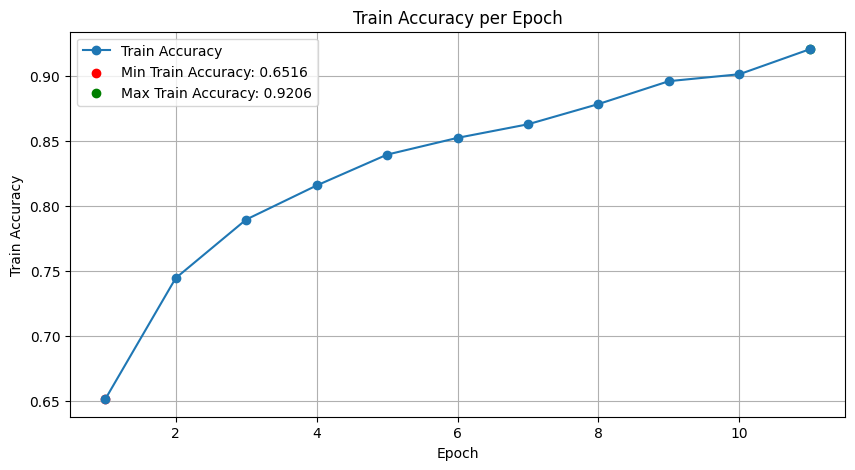

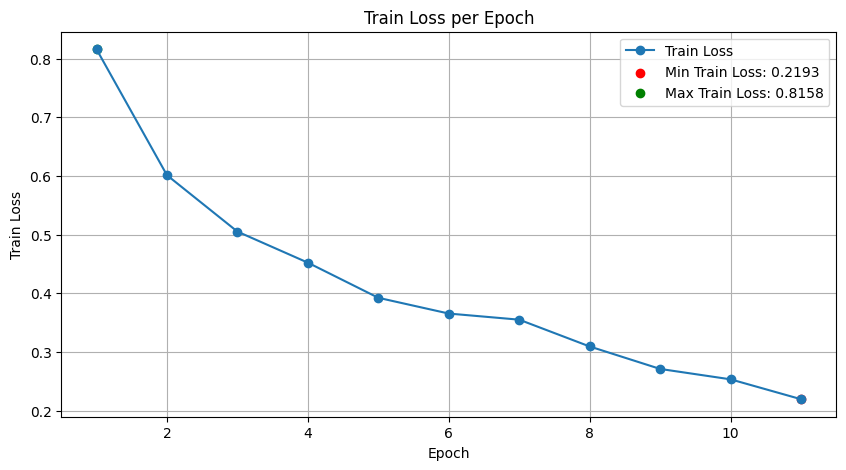

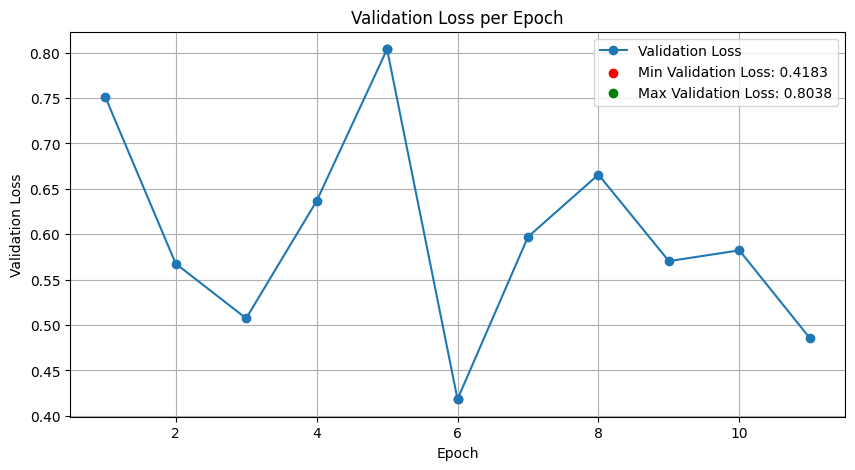

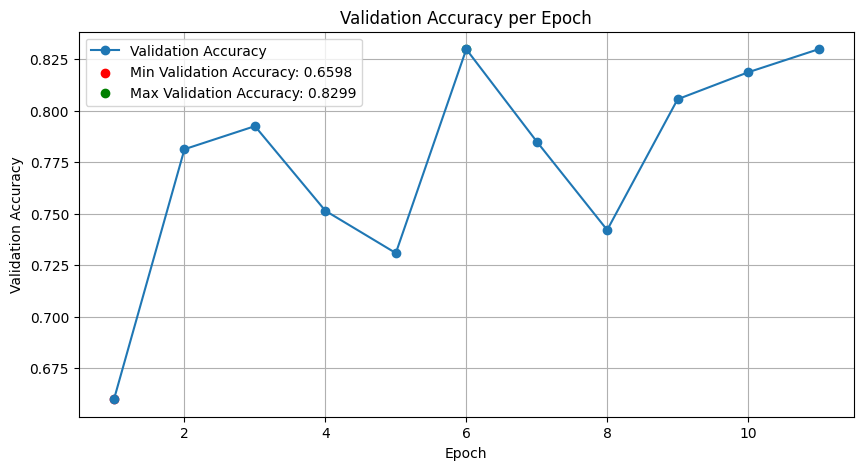

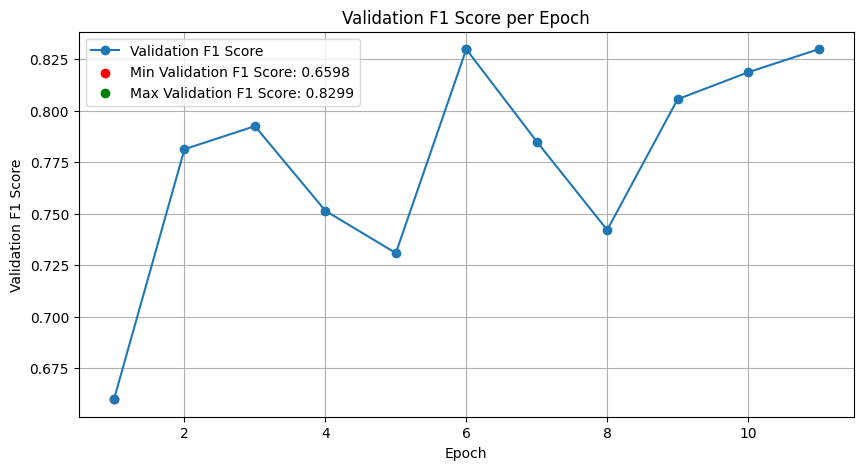

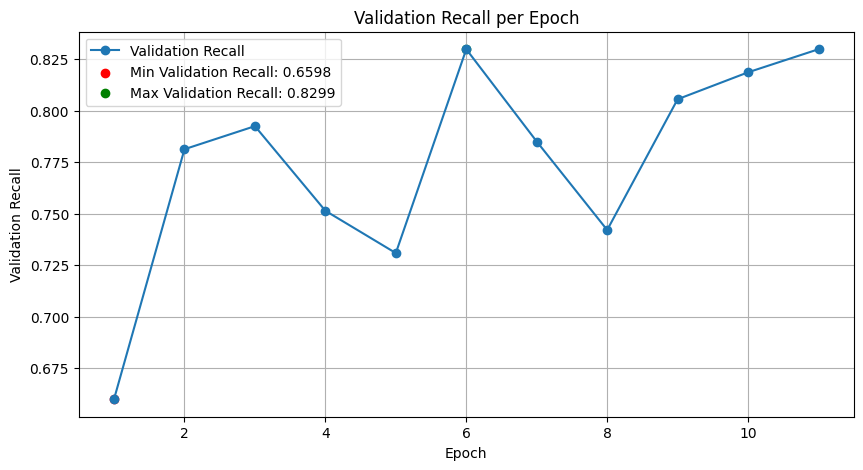

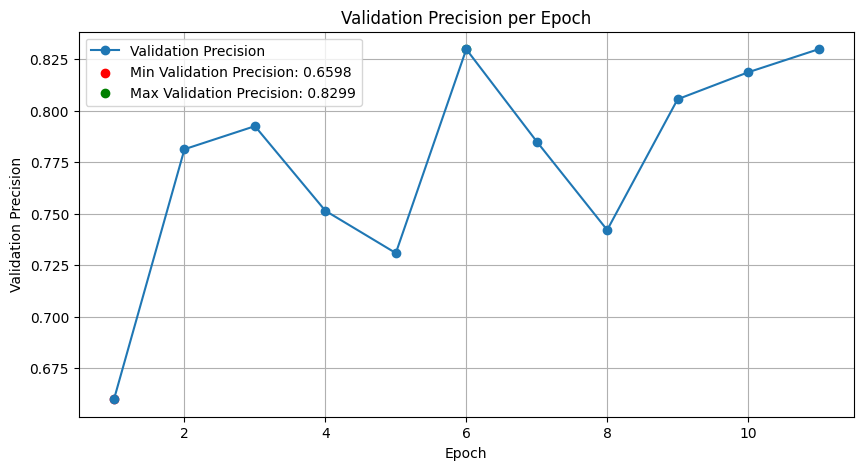

Metrics for OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

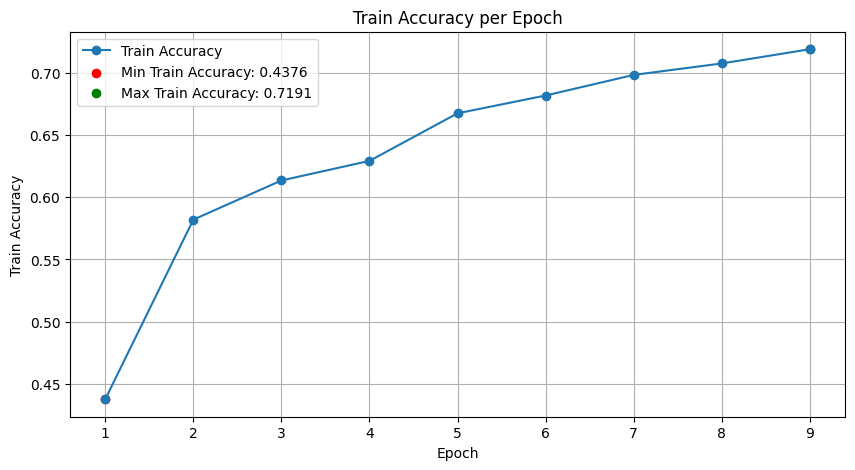

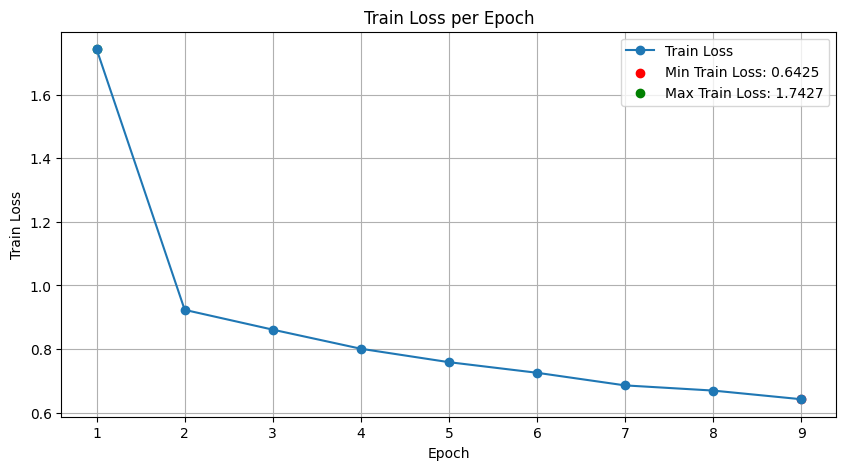

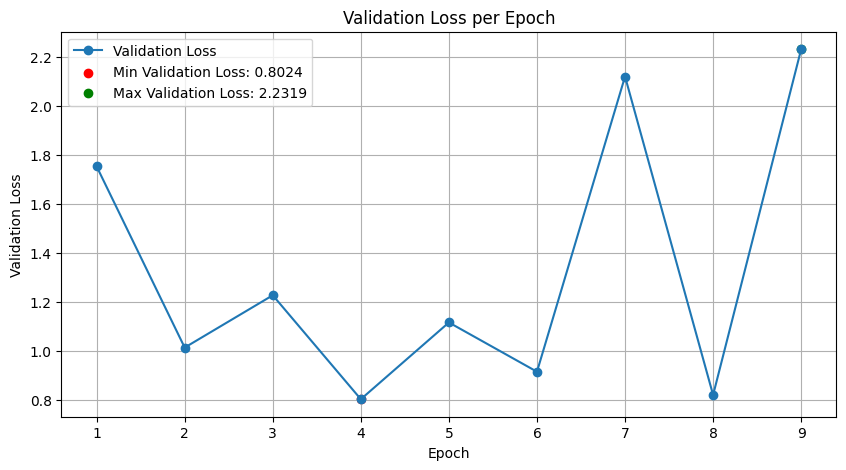

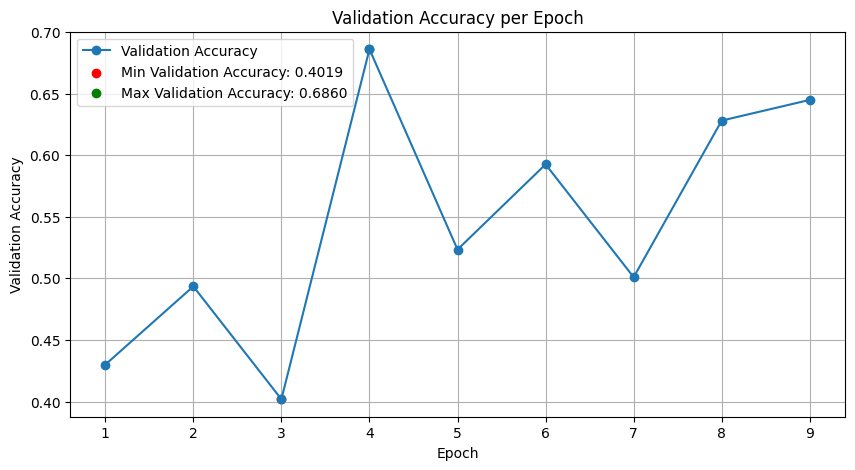

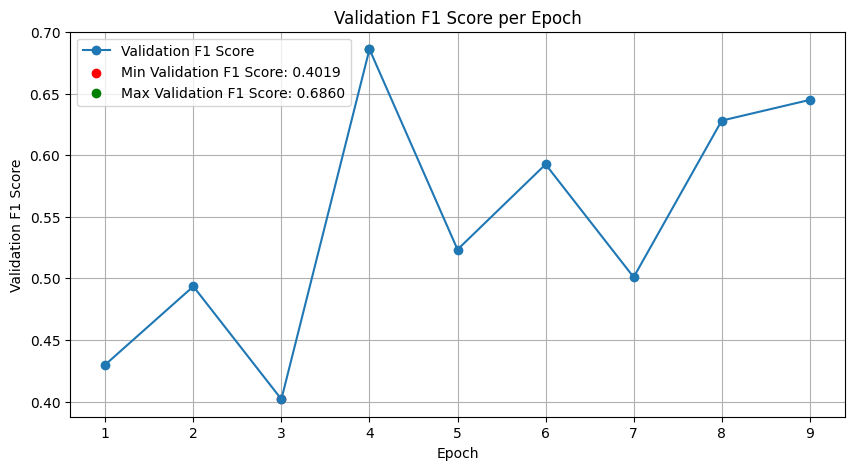

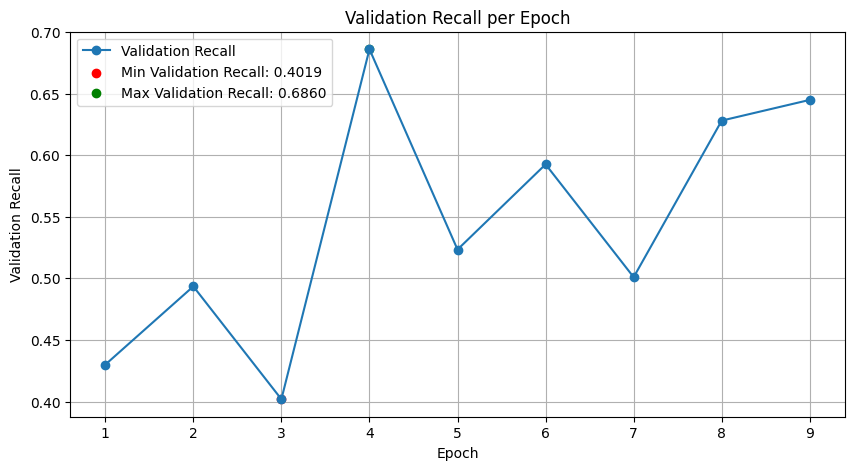

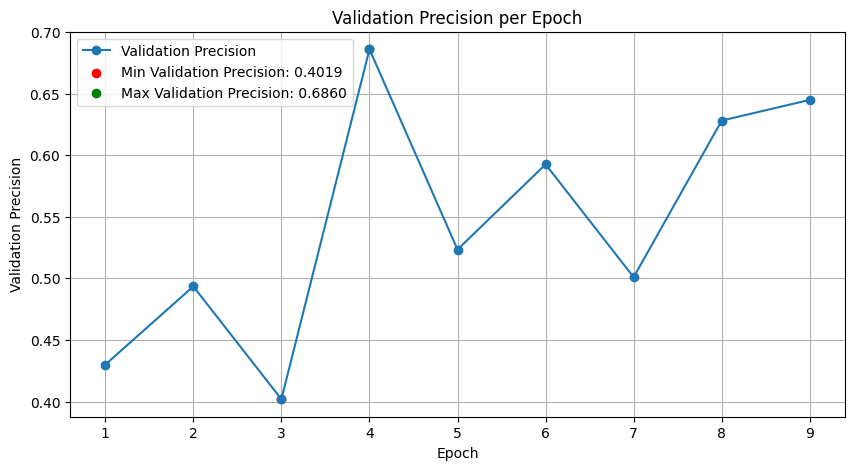

Metrics for OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

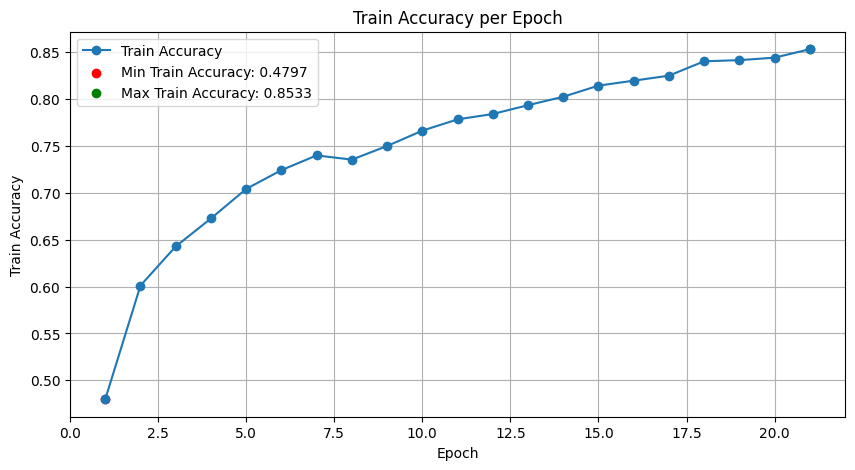

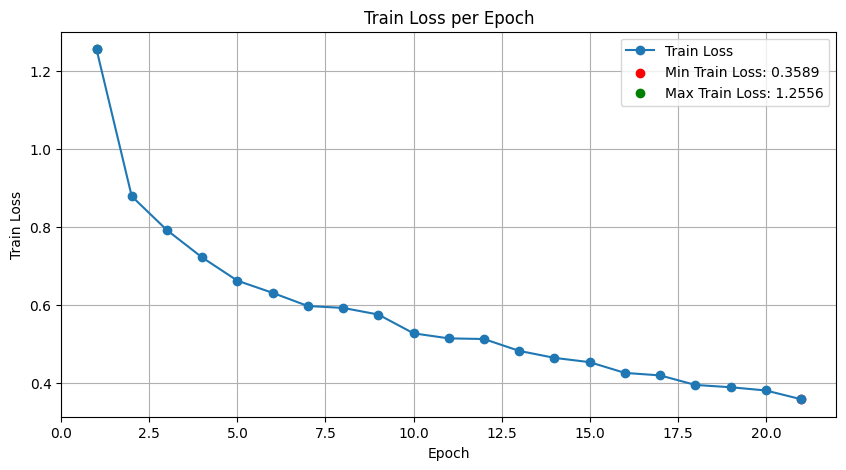

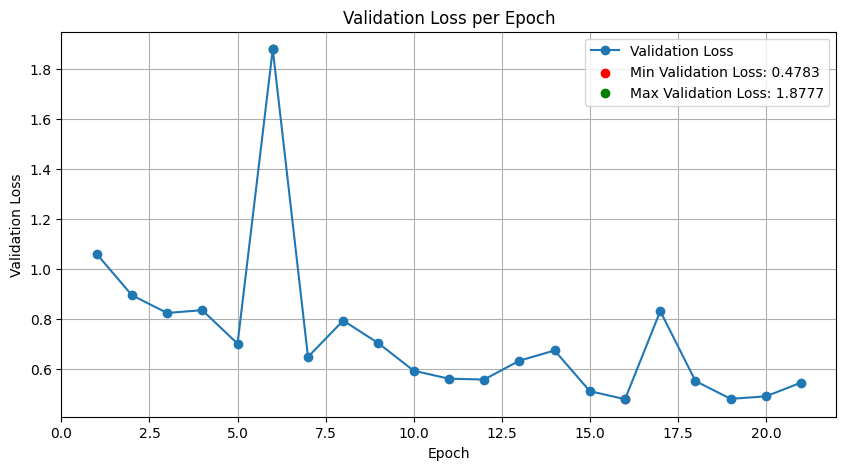

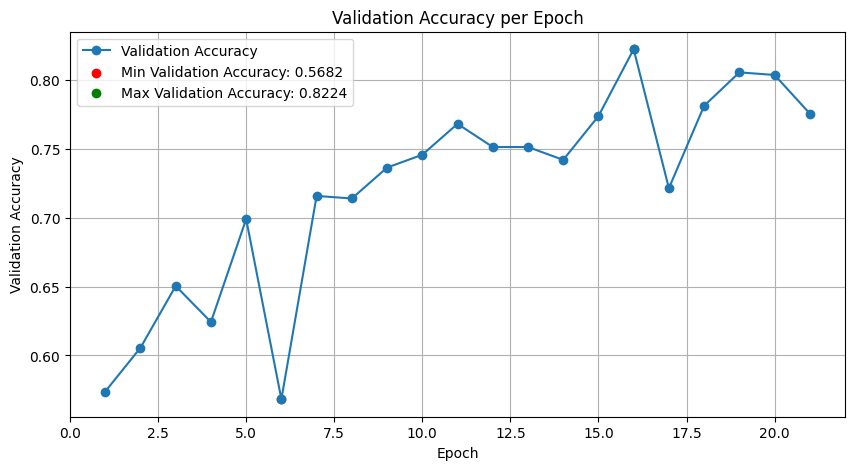

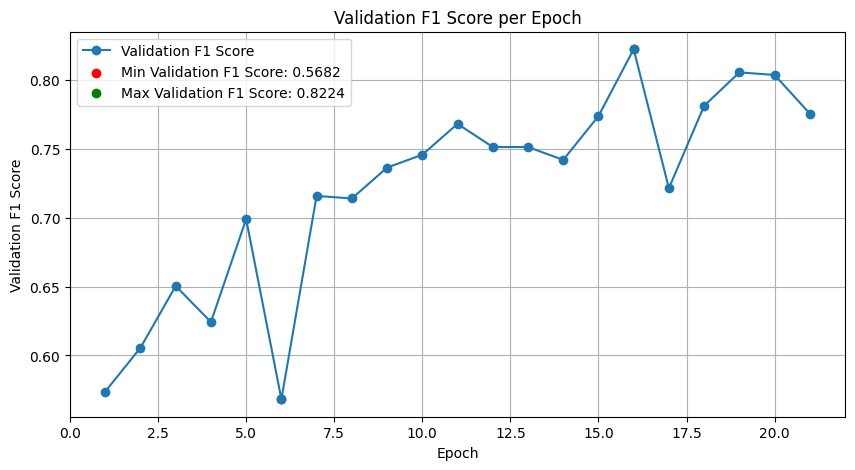

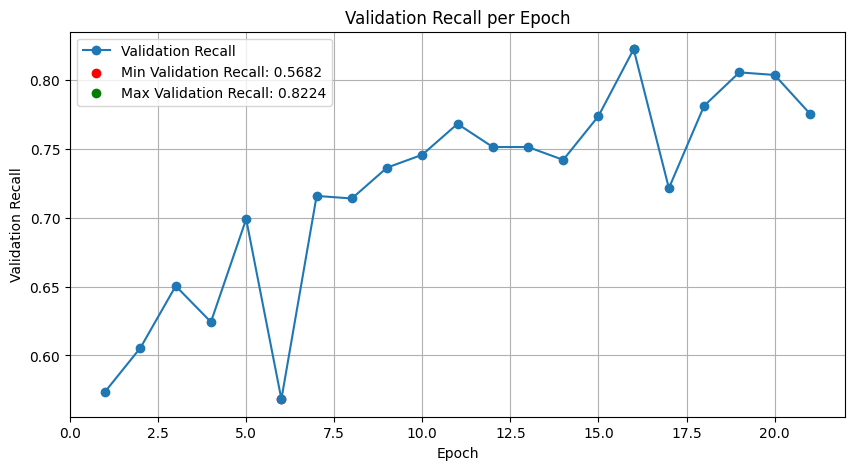

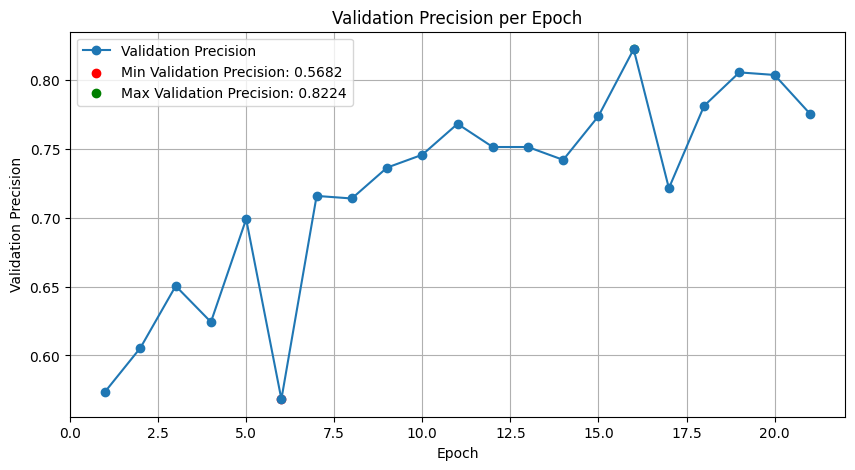

Metrics for OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

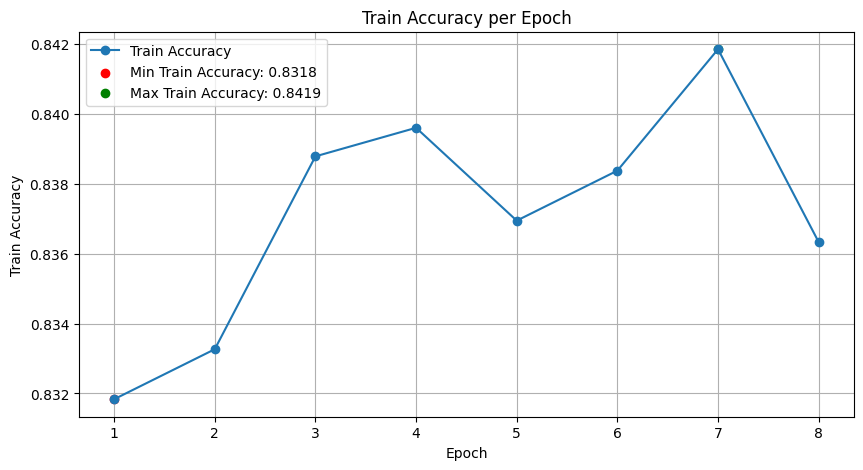

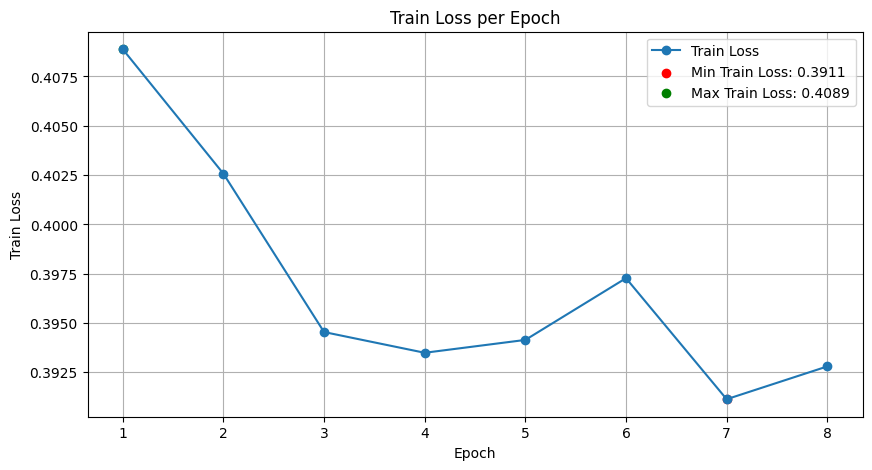

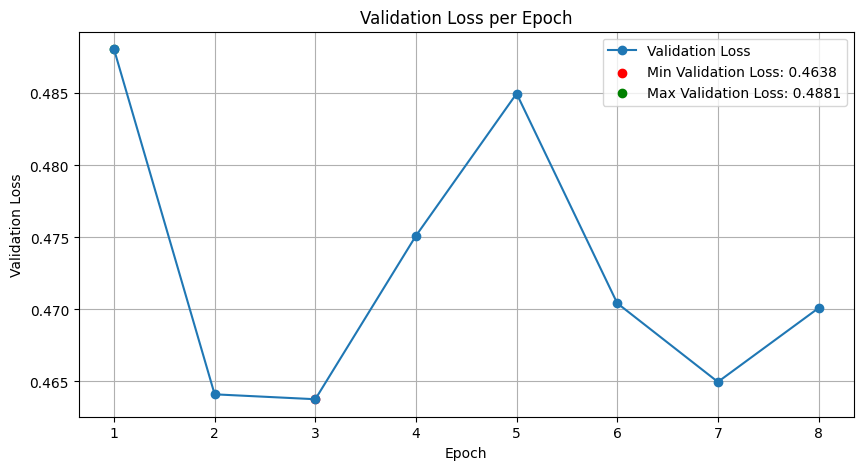

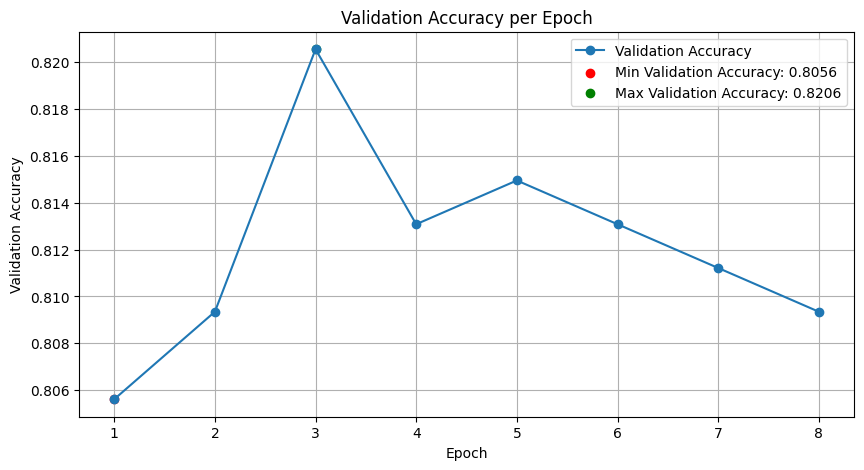

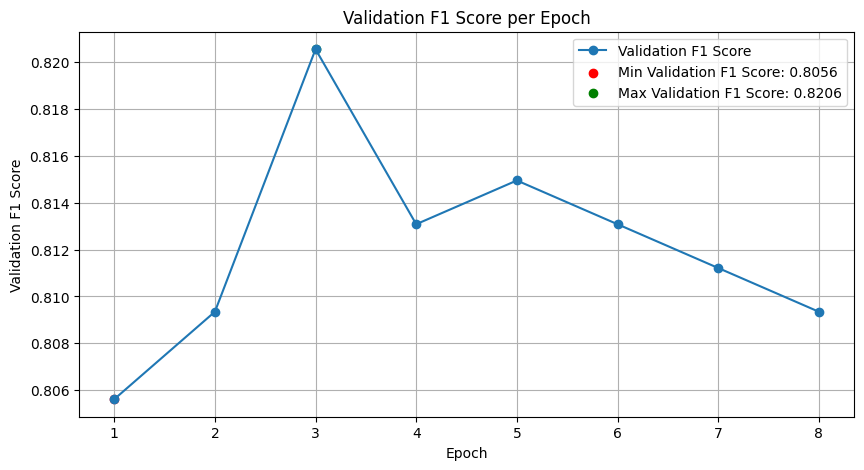

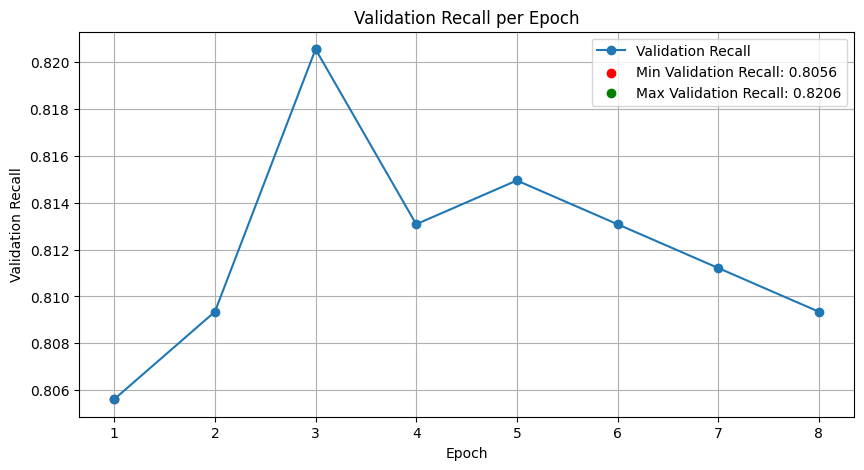

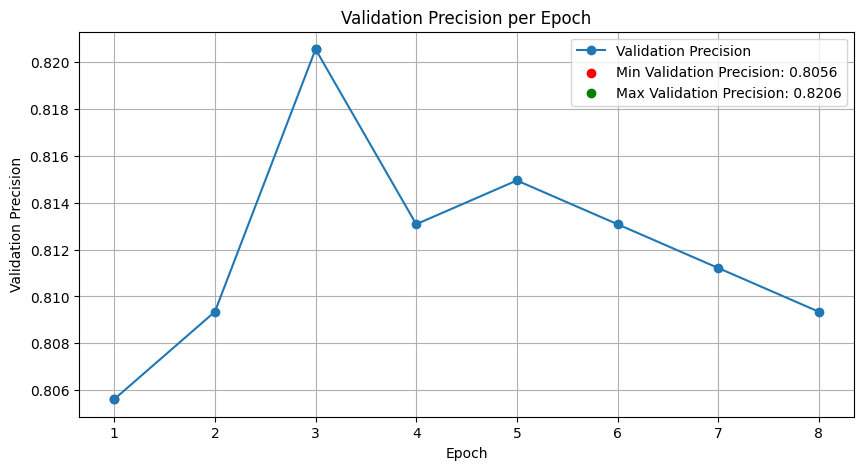

/opt/conda/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


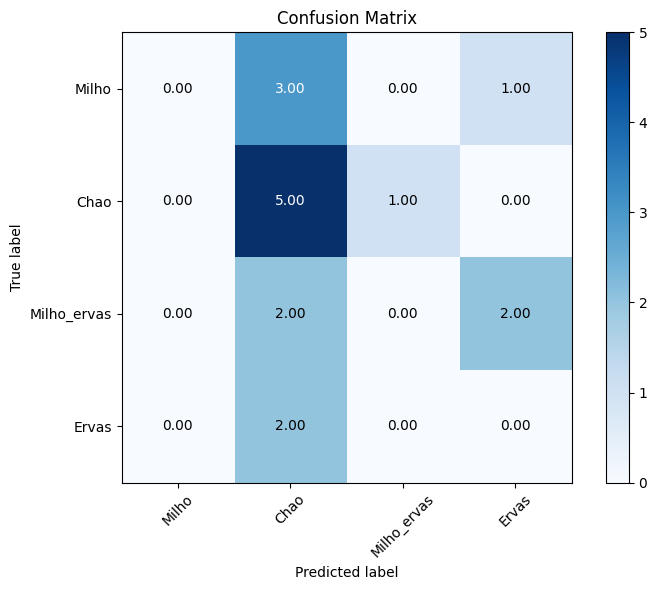

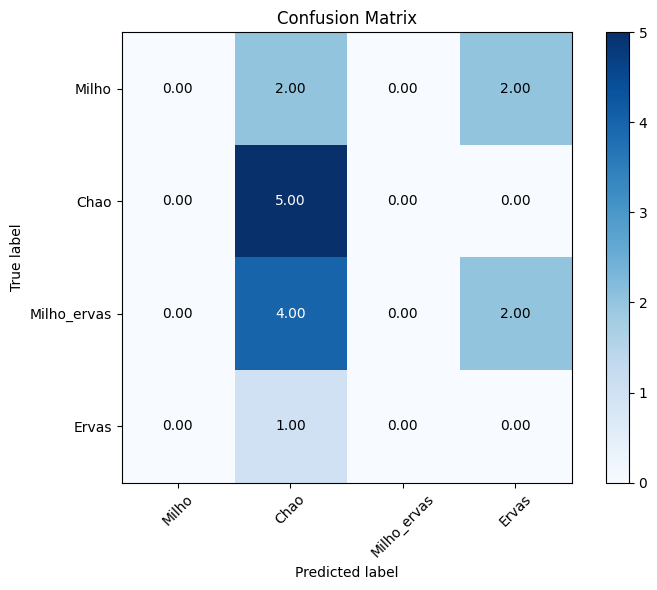

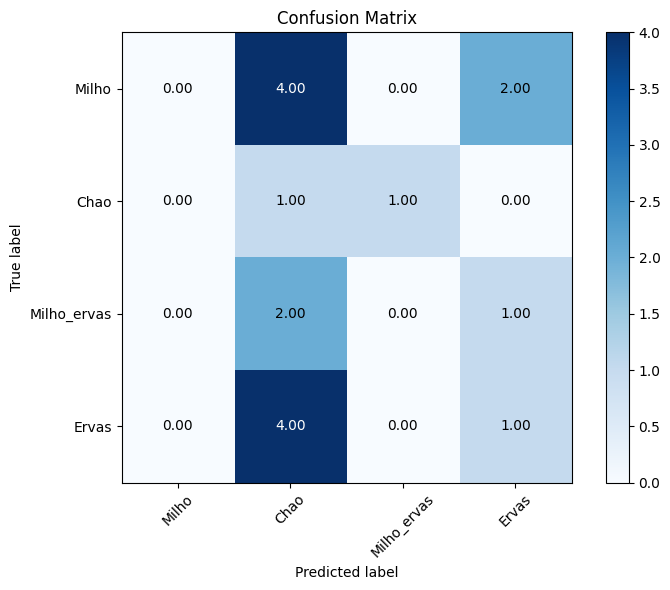

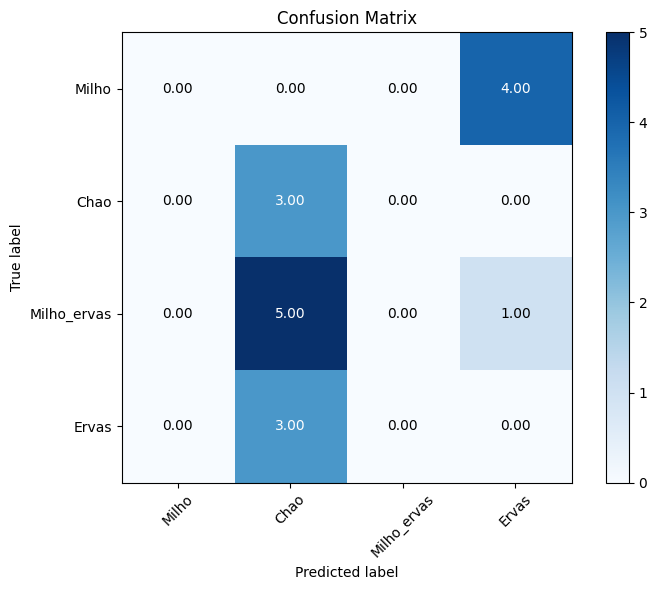

In [27]:
plot_metrics_per_model(resnet50_results)  
evaluate_model(resnet50_results, classes, device, valid_transform)

# AlexNet Exprimentation

In [28]:
from torchvision.models import alexnet, AlexNet_Weights

In [29]:
weights = AlexNet_Weights.DEFAULT
preprocess = weights.transforms()
alexnet_model = alexnet(weights='IMAGENET1K_V1')

# Freeze the parameters of the pre-trained layers
for param in alexnet_model.parameters():
    param.requires_grad = False

# Modify the last layer of the classifier to output 4 classes
num_features = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(num_features, 4)


train_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino",transform=preprocess)
valid_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Validação", transform=preprocess)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=16, shuffle=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 87.3MB/s] 


In [30]:
# Store the results for each combination of input_model, optimizer, and lr
alexnet_results = {}

for optimizer_type, lr in zip(optimizers, learning_rates):
    model, optimizer = make_model(alexnet_model, optimizer_type, lr)

    train_acc_per_epoch, train_loss_per_epoch, valid_loss_per_epoch, valid_acc_per_epoch, valid_f1_per_epoch, valid_recall_per_epoch, valid_precision_per_epoch, model = run_train(model, train_dataloader, valid_dataloader, optimizer)
    print()
    print(f"storing results for {optimizer_type, lr, model}")
    # Store the results in the dictionary
    alexnet_results[(input_model, optimizer_type, lr)] = {
        'train_acc_per_epoch': train_acc_per_epoch,
        'train_loss_per_epoch': train_loss_per_epoch,
        'valid_loss_per_epoch': valid_loss_per_epoch,
        'valid_acc_per_epoch': valid_acc_per_epoch,
        'valid_f1_per_epoch': valid_f1_per_epoch,
        'valid_recall_per_epoch': valid_recall_per_epoch,
        'valid_precision_per_epoch': valid_precision_per_epoch,
        'model': model
    }

####################
       Epoch: 0  
####################


100%|██████████| 34/34 [00:06<00:00,  4.95it/s]


Epoch : 0 Train Loss : tensor(0.7140, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5487, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7963, device='cuda:0') Valid f1 :  tensor(0.7963, device='cuda:0') Valid Recall :  tensor(0.7963, device='cuda:0') Valid Precision :  tensor(0.7963, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch : 1 Train Loss : tensor(0.5595, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5474, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7832, device='cuda:0') Valid f1 :  tensor(0.7832, device='cuda:0') Valid Recall :  tensor(0.7832, device='cuda:0') Valid Precision :  tensor(0.7832, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


Epoch : 2 Train Loss : tensor(0.5232, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6000, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7776, device='cuda:0') Valid f1 :  tensor(0.7776, device='cuda:0') Valid Recall :  tensor(0.7776, device='cuda:0') Valid Precision :  tensor(0.7776, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:04<00:00,  8.13it/s]


Epoch : 3 Train Loss : tensor(0.5093, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5715, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7907, device='cuda:0') Valid f1 :  tensor(0.7907, device='cuda:0') Valid Recall :  tensor(0.7907, device='cuda:0') Valid Precision :  tensor(0.7907, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:04<00:00,  7.96it/s]


Epoch : 4 Train Loss : tensor(0.4794, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5612, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7963, device='cuda:0') Valid f1 :  tensor(0.7963, device='cuda:0') Valid Recall :  tensor(0.7963, device='cuda:0') Valid Precision :  tensor(0.7963, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Epoch : 5 Train Loss : tensor(0.4743, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5485, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.8056, device='cuda:0') Valid f1 :  tensor(0.8056, device='cuda:0') Valid Recall :  tensor(0.8056, device='cuda:0') Valid Precision :  tensor(0.8056, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:04<00:00,  8.05it/s]


Epoch : 6 Train Loss : tensor(0.4654, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5732, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7888, device='cuda:0') Valid f1 :  tensor(0.7888, device='cuda:0') Valid Recall :  tensor(0.7888, device='cuda:0') Valid Precision :  tensor(0.7888, device='cuda:0')

storing results for ('Adam', 0.001, OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), 

100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


Epoch : 0 Train Loss : tensor(6.0420, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(3.0821, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7327, device='cuda:0') Valid f1 :  tensor(0.7327, device='cuda:0') Valid Recall :  tensor(0.7327, device='cuda:0') Valid Precision :  tensor(0.7327, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Epoch : 1 Train Loss : tensor(3.2707, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.8721, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7252, device='cuda:0') Valid f1 :  tensor(0.7252, device='cuda:0') Valid Recall :  tensor(0.7252, device='cuda:0') Valid Precision :  tensor(0.7252, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:04<00:00,  8.17it/s]


Epoch : 2 Train Loss : tensor(2.6834, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.8452, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:04<00:00,  7.93it/s]


Epoch : 3 Train Loss : tensor(2.6735, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.4689, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7439, device='cuda:0') Valid f1 :  tensor(0.7439, device='cuda:0') Valid Recall :  tensor(0.7439, device='cuda:0') Valid Precision :  tensor(0.7439, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:04<00:00,  7.93it/s]


Epoch : 4 Train Loss : tensor(2.7060, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(3.1801, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7140, device='cuda:0') Valid f1 :  tensor(0.7140, device='cuda:0') Valid Recall :  tensor(0.7140, device='cuda:0') Valid Precision :  tensor(0.7140, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


Epoch : 5 Train Loss : tensor(2.7596, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(4.4920, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7383, device='cuda:0') Valid f1 :  tensor(0.7383, device='cuda:0') Valid Recall :  tensor(0.7383, device='cuda:0') Valid Precision :  tensor(0.7383, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:04<00:00,  7.31it/s]


Epoch : 6 Train Loss : tensor(2.6308, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.8400, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7477, device='cuda:0') Valid f1 :  tensor(0.7477, device='cuda:0') Valid Recall :  tensor(0.7477, device='cuda:0') Valid Precision :  tensor(0.7477, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


Epoch : 7 Train Loss : tensor(2.6117, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(3.1844, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7664, device='cuda:0') Valid f1 :  tensor(0.7664, device='cuda:0') Valid Recall :  tensor(0.7664, device='cuda:0') Valid Precision :  tensor(0.7664, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


Epoch : 8 Train Loss : tensor(2.4846, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.9922, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')

storing results for ('RMSprop', 0.01, OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1)

100%|██████████| 34/34 [00:04<00:00,  8.07it/s]


Epoch : 0 Train Loss : tensor(4.5104, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(3.2394, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7570, device='cuda:0') Valid f1 :  tensor(0.7570, device='cuda:0') Valid Recall :  tensor(0.7570, device='cuda:0') Valid Precision :  tensor(0.7570, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:04<00:00,  8.06it/s]


Epoch : 1 Train Loss : tensor(2.5456, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.8195, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7458, device='cuda:0') Valid f1 :  tensor(0.7458, device='cuda:0') Valid Recall :  tensor(0.7458, device='cuda:0') Valid Precision :  tensor(0.7458, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


Epoch : 2 Train Loss : tensor(2.0223, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.5870, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7477, device='cuda:0') Valid f1 :  tensor(0.7477, device='cuda:0') Valid Recall :  tensor(0.7477, device='cuda:0') Valid Precision :  tensor(0.7477, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Epoch : 3 Train Loss : tensor(1.8010, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.9572, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7551, device='cuda:0') Valid f1 :  tensor(0.7551, device='cuda:0') Valid Recall :  tensor(0.7551, device='cuda:0') Valid Precision :  tensor(0.7551, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch : 4 Train Loss : tensor(1.5661, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.6818, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7383, device='cuda:0') Valid f1 :  tensor(0.7383, device='cuda:0') Valid Recall :  tensor(0.7383, device='cuda:0') Valid Precision :  tensor(0.7383, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


Epoch : 5 Train Loss : tensor(1.4738, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.3043, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7533, device='cuda:0') Valid f1 :  tensor(0.7533, device='cuda:0') Valid Recall :  tensor(0.7533, device='cuda:0') Valid Precision :  tensor(0.7533, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch : 6 Train Loss : tensor(1.3641, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.5900, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch : 7 Train Loss : tensor(1.3154, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.0892, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7607, device='cuda:0') Valid f1 :  tensor(0.7607, device='cuda:0') Valid Recall :  tensor(0.7607, device='cuda:0') Valid Precision :  tensor(0.7607, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:04<00:00,  8.12it/s]


Epoch : 8 Train Loss : tensor(1.2288, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.2849, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7533, device='cuda:0') Valid f1 :  tensor(0.7533, device='cuda:0') Valid Recall :  tensor(0.7533, device='cuda:0') Valid Precision :  tensor(0.7533, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:04<00:00,  7.95it/s]


Epoch : 9 Train Loss : tensor(1.1358, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.0468, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:04<00:00,  7.86it/s]


Epoch : 10 Train Loss : tensor(1.0712, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.0787, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7252, device='cuda:0') Valid f1 :  tensor(0.7252, device='cuda:0') Valid Recall :  tensor(0.7252, device='cuda:0') Valid Precision :  tensor(0.7252, device='cuda:0')
####################
       Epoch: 11  
####################


100%|██████████| 34/34 [00:04<00:00,  7.67it/s]


Epoch : 11 Train Loss : tensor(1.1099, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.2152, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7514, device='cuda:0') Valid f1 :  tensor(0.7514, device='cuda:0') Valid Recall :  tensor(0.7514, device='cuda:0') Valid Precision :  tensor(0.7514, device='cuda:0')
####################
       Epoch: 12  
####################


100%|██████████| 34/34 [00:04<00:00,  8.09it/s]


Epoch : 12 Train Loss : tensor(1.1006, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.1193, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')
####################
       Epoch: 13  
####################


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


Epoch : 13 Train Loss : tensor(1.0922, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.2452, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7383, device='cuda:0') Valid f1 :  tensor(0.7383, device='cuda:0') Valid Recall :  tensor(0.7383, device='cuda:0') Valid Precision :  tensor(0.7383, device='cuda:0')
####################
       Epoch: 14  
####################


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Epoch : 14 Train Loss : tensor(1.0022, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.0160, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7458, device='cuda:0') Valid f1 :  tensor(0.7458, device='cuda:0') Valid Recall :  tensor(0.7458, device='cuda:0') Valid Precision :  tensor(0.7458, device='cuda:0')
####################
       Epoch: 15  
####################


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch : 15 Train Loss : tensor(1.0331, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.1496, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7514, device='cuda:0') Valid f1 :  tensor(0.7514, device='cuda:0') Valid Recall :  tensor(0.7514, device='cuda:0') Valid Precision :  tensor(0.7514, device='cuda:0')
####################
       Epoch: 16  
####################


100%|██████████| 34/34 [00:04<00:00,  8.34it/s]


Epoch : 16 Train Loss : tensor(0.9285, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.0548, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7720, device='cuda:0') Valid f1 :  tensor(0.7720, device='cuda:0') Valid Recall :  tensor(0.7720, device='cuda:0') Valid Precision :  tensor(0.7720, device='cuda:0')
####################
       Epoch: 17  
####################


100%|██████████| 34/34 [00:04<00:00,  7.42it/s]


Epoch : 17 Train Loss : tensor(0.8845, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.8999, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7682, device='cuda:0') Valid f1 :  tensor(0.7682, device='cuda:0') Valid Recall :  tensor(0.7682, device='cuda:0') Valid Precision :  tensor(0.7682, device='cuda:0')
####################
       Epoch: 18  
####################


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch : 18 Train Loss : tensor(0.9026, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.8335, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7757, device='cuda:0') Valid f1 :  tensor(0.7757, device='cuda:0') Valid Recall :  tensor(0.7757, device='cuda:0') Valid Precision :  tensor(0.7757, device='cuda:0')
####################
       Epoch: 19  
####################


100%|██████████| 34/34 [00:04<00:00,  8.25it/s]


Epoch : 19 Train Loss : tensor(0.9068, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7970, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7477, device='cuda:0') Valid f1 :  tensor(0.7477, device='cuda:0') Valid Recall :  tensor(0.7477, device='cuda:0') Valid Precision :  tensor(0.7477, device='cuda:0')
####################
       Epoch: 20  
####################


100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch : 20 Train Loss : tensor(0.8692, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7920, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7551, device='cuda:0') Valid f1 :  tensor(0.7551, device='cuda:0') Valid Recall :  tensor(0.7551, device='cuda:0') Valid Precision :  tensor(0.7551, device='cuda:0')
####################
       Epoch: 21  
####################


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch : 21 Train Loss : tensor(0.8080, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7801, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')
####################
       Epoch: 22  
####################


100%|██████████| 34/34 [00:04<00:00,  8.15it/s]


Epoch : 22 Train Loss : tensor(0.7916, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(2.0404, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 23  
####################


100%|██████████| 34/34 [00:04<00:00,  7.67it/s]


Epoch : 23 Train Loss : tensor(0.7794, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.8678, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7439, device='cuda:0') Valid f1 :  tensor(0.7439, device='cuda:0') Valid Recall :  tensor(0.7439, device='cuda:0') Valid Precision :  tensor(0.7439, device='cuda:0')
####################
       Epoch: 24  
####################


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch : 24 Train Loss : tensor(0.8818, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7005, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7570, device='cuda:0') Valid f1 :  tensor(0.7570, device='cuda:0') Valid Recall :  tensor(0.7570, device='cuda:0') Valid Precision :  tensor(0.7570, device='cuda:0')
####################
       Epoch: 25  
####################


100%|██████████| 34/34 [00:04<00:00,  7.89it/s]


Epoch : 25 Train Loss : tensor(0.8226, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7910, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7495, device='cuda:0') Valid f1 :  tensor(0.7495, device='cuda:0') Valid Recall :  tensor(0.7495, device='cuda:0') Valid Precision :  tensor(0.7495, device='cuda:0')
####################
       Epoch: 26  
####################


100%|██████████| 34/34 [00:04<00:00,  8.05it/s]


Epoch : 26 Train Loss : tensor(0.8036, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.8748, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7252, device='cuda:0') Valid f1 :  tensor(0.7252, device='cuda:0') Valid Recall :  tensor(0.7252, device='cuda:0') Valid Precision :  tensor(0.7252, device='cuda:0')
####################
       Epoch: 27  
####################


100%|██████████| 34/34 [00:04<00:00,  8.06it/s]


Epoch : 27 Train Loss : tensor(0.7819, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7201, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7495, device='cuda:0') Valid f1 :  tensor(0.7495, device='cuda:0') Valid Recall :  tensor(0.7495, device='cuda:0') Valid Precision :  tensor(0.7495, device='cuda:0')
####################
       Epoch: 28  
####################


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch : 28 Train Loss : tensor(0.7680, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.6688, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7701, device='cuda:0') Valid f1 :  tensor(0.7701, device='cuda:0') Valid Recall :  tensor(0.7701, device='cuda:0') Valid Precision :  tensor(0.7701, device='cuda:0')
####################
       Epoch: 29  
####################


100%|██████████| 34/34 [00:04<00:00,  8.03it/s]


Epoch : 29 Train Loss : tensor(0.8134, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.8478, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7290, device='cuda:0') Valid f1 :  tensor(0.7290, device='cuda:0') Valid Recall :  tensor(0.7290, device='cuda:0') Valid Precision :  tensor(0.7290, device='cuda:0')
####################
       Epoch: 30  
####################


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch : 30 Train Loss : tensor(0.7605, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.6708, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7421, device='cuda:0') Valid f1 :  tensor(0.7421, device='cuda:0') Valid Recall :  tensor(0.7421, device='cuda:0') Valid Precision :  tensor(0.7421, device='cuda:0')
####################
       Epoch: 31  
####################


100%|██████████| 34/34 [00:04<00:00,  8.21it/s]


Epoch : 31 Train Loss : tensor(0.7311, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.6528, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7813, device='cuda:0') Valid f1 :  tensor(0.7813, device='cuda:0') Valid Recall :  tensor(0.7813, device='cuda:0') Valid Precision :  tensor(0.7813, device='cuda:0')
####################
       Epoch: 32  
####################


100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch : 32 Train Loss : tensor(0.7001, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.6124, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7495, device='cuda:0') Valid f1 :  tensor(0.7495, device='cuda:0') Valid Recall :  tensor(0.7495, device='cuda:0') Valid Precision :  tensor(0.7495, device='cuda:0')
####################
       Epoch: 33  
####################


100%|██████████| 34/34 [00:04<00:00,  8.16it/s]


Epoch : 33 Train Loss : tensor(0.7028, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.6518, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7495, device='cuda:0') Valid f1 :  tensor(0.7495, device='cuda:0') Valid Recall :  tensor(0.7495, device='cuda:0') Valid Precision :  tensor(0.7495, device='cuda:0')
####################
       Epoch: 34  
####################


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch : 34 Train Loss : tensor(0.6986, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7599, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7308, device='cuda:0') Valid f1 :  tensor(0.7308, device='cuda:0') Valid Recall :  tensor(0.7308, device='cuda:0') Valid Precision :  tensor(0.7308, device='cuda:0')
####################
       Epoch: 35  
####################


100%|██████████| 34/34 [00:04<00:00,  8.18it/s]


Epoch : 35 Train Loss : tensor(0.7469, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.5741, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7607, device='cuda:0') Valid f1 :  tensor(0.7607, device='cuda:0') Valid Recall :  tensor(0.7607, device='cuda:0') Valid Precision :  tensor(0.7607, device='cuda:0')
####################
       Epoch: 36  
####################


100%|██████████| 34/34 [00:04<00:00,  8.13it/s]


Epoch : 36 Train Loss : tensor(0.6687, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.5651, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7439, device='cuda:0') Valid f1 :  tensor(0.7439, device='cuda:0') Valid Recall :  tensor(0.7439, device='cuda:0') Valid Precision :  tensor(0.7439, device='cuda:0')
####################
       Epoch: 37  
####################


100%|██████████| 34/34 [00:04<00:00,  7.55it/s]


Epoch : 37 Train Loss : tensor(0.6913, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.5553, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 38  
####################


100%|██████████| 34/34 [00:04<00:00,  7.67it/s]


Epoch : 38 Train Loss : tensor(0.6546, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.7672, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7103, device='cuda:0') Valid f1 :  tensor(0.7103, device='cuda:0') Valid Recall :  tensor(0.7103, device='cuda:0') Valid Precision :  tensor(0.7103, device='cuda:0')
####################
       Epoch: 39  
####################


100%|██████████| 34/34 [00:04<00:00,  7.92it/s]


Epoch : 39 Train Loss : tensor(0.6594, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.6872, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7421, device='cuda:0') Valid f1 :  tensor(0.7421, device='cuda:0') Valid Recall :  tensor(0.7421, device='cuda:0') Valid Precision :  tensor(0.7421, device='cuda:0')
####################
       Epoch: 40  
####################


100%|██████████| 34/34 [00:04<00:00,  7.69it/s]


Epoch : 40 Train Loss : tensor(0.6500, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.5537, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')
####################
       Epoch: 41  
####################


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Epoch : 41 Train Loss : tensor(0.6212, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4300, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7607, device='cuda:0') Valid f1 :  tensor(0.7607, device='cuda:0') Valid Recall :  tensor(0.7607, device='cuda:0') Valid Precision :  tensor(0.7607, device='cuda:0')
####################
       Epoch: 42  
####################


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Epoch : 42 Train Loss : tensor(0.6306, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4764, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7439, device='cuda:0') Valid f1 :  tensor(0.7439, device='cuda:0') Valid Recall :  tensor(0.7439, device='cuda:0') Valid Precision :  tensor(0.7439, device='cuda:0')
####################
       Epoch: 43  
####################


100%|██████████| 34/34 [00:04<00:00,  7.88it/s]


Epoch : 43 Train Loss : tensor(0.6544, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4258, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7570, device='cuda:0') Valid f1 :  tensor(0.7570, device='cuda:0') Valid Recall :  tensor(0.7570, device='cuda:0') Valid Precision :  tensor(0.7570, device='cuda:0')
####################
       Epoch: 44  
####################


100%|██████████| 34/34 [00:04<00:00,  7.70it/s]


Epoch : 44 Train Loss : tensor(0.6693, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4905, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')
####################
       Epoch: 45  
####################


100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Epoch : 45 Train Loss : tensor(0.6654, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.6013, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7308, device='cuda:0') Valid f1 :  tensor(0.7308, device='cuda:0') Valid Recall :  tensor(0.7308, device='cuda:0') Valid Precision :  tensor(0.7308, device='cuda:0')
####################
       Epoch: 46  
####################


100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch : 46 Train Loss : tensor(0.6254, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.5012, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7364, device='cuda:0') Valid f1 :  tensor(0.7364, device='cuda:0') Valid Recall :  tensor(0.7364, device='cuda:0') Valid Precision :  tensor(0.7364, device='cuda:0')
####################
       Epoch: 47  
####################


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch : 47 Train Loss : tensor(0.6464, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4750, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7570, device='cuda:0') Valid f1 :  tensor(0.7570, device='cuda:0') Valid Recall :  tensor(0.7570, device='cuda:0') Valid Precision :  tensor(0.7570, device='cuda:0')
####################
       Epoch: 48  
####################


100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch : 48 Train Loss : tensor(0.6076, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.5082, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7421, device='cuda:0') Valid f1 :  tensor(0.7421, device='cuda:0') Valid Recall :  tensor(0.7421, device='cuda:0') Valid Precision :  tensor(0.7421, device='cuda:0')

storing results for ('Adagrad', 0.1, OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1)

100%|██████████| 34/34 [00:04<00:00,  8.08it/s]


Epoch : 0 Train Loss : tensor(0.5546, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4077, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7682, device='cuda:0') Valid f1 :  tensor(0.7682, device='cuda:0') Valid Recall :  tensor(0.7682, device='cuda:0') Valid Precision :  tensor(0.7682, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


Epoch : 1 Train Loss : tensor(0.6276, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.4020, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7664, device='cuda:0') Valid f1 :  tensor(0.7664, device='cuda:0') Valid Recall :  tensor(0.7664, device='cuda:0') Valid Precision :  tensor(0.7664, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:04<00:00,  8.09it/s]


Epoch : 2 Train Loss : tensor(0.5688, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3985, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7645, device='cuda:0') Valid f1 :  tensor(0.7645, device='cuda:0') Valid Recall :  tensor(0.7645, device='cuda:0') Valid Precision :  tensor(0.7645, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:04<00:00,  8.18it/s]


Epoch : 3 Train Loss : tensor(0.5847, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3963, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7664, device='cuda:0') Valid f1 :  tensor(0.7664, device='cuda:0') Valid Recall :  tensor(0.7664, device='cuda:0') Valid Precision :  tensor(0.7664, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:04<00:00,  8.04it/s]


Epoch : 4 Train Loss : tensor(0.6061, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3932, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7645, device='cuda:0') Valid f1 :  tensor(0.7645, device='cuda:0') Valid Recall :  tensor(0.7645, device='cuda:0') Valid Precision :  tensor(0.7645, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:04<00:00,  7.99it/s]


Epoch : 5 Train Loss : tensor(0.5784, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3908, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7664, device='cuda:0') Valid f1 :  tensor(0.7664, device='cuda:0') Valid Recall :  tensor(0.7664, device='cuda:0') Valid Precision :  tensor(0.7664, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


Epoch : 6 Train Loss : tensor(0.5818, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3876, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7645, device='cuda:0') Valid f1 :  tensor(0.7645, device='cuda:0') Valid Recall :  tensor(0.7645, device='cuda:0') Valid Precision :  tensor(0.7645, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch : 7 Train Loss : tensor(0.5854, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3862, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7626, device='cuda:0') Valid f1 :  tensor(0.7626, device='cuda:0') Valid Recall :  tensor(0.7626, device='cuda:0') Valid Precision :  tensor(0.7626, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:04<00:00,  7.74it/s]


Epoch : 8 Train Loss : tensor(0.5655, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3869, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7626, device='cuda:0') Valid f1 :  tensor(0.7626, device='cuda:0') Valid Recall :  tensor(0.7626, device='cuda:0') Valid Precision :  tensor(0.7626, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch : 9 Train Loss : tensor(0.5345, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3895, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7607, device='cuda:0') Valid f1 :  tensor(0.7607, device='cuda:0') Valid Recall :  tensor(0.7607, device='cuda:0') Valid Precision :  tensor(0.7607, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Epoch : 10 Train Loss : tensor(0.5704, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3867, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')
####################
       Epoch: 11  
####################


100%|██████████| 34/34 [00:04<00:00,  7.97it/s]


Epoch : 11 Train Loss : tensor(0.5996, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3873, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')
####################
       Epoch: 12  
####################


100%|██████████| 34/34 [00:04<00:00,  7.93it/s]

Epoch : 12 Train Loss : tensor(0.5869, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(1.3867, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7589, device='cuda:0') Valid f1 :  tensor(0.7589, device='cuda:0') Valid Recall :  tensor(0.7589, device='cuda:0') Valid Precision :  tensor(0.7589, device='cuda:0')

storing results for ('SGD', 0.0001, OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1),

Metrics for OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, 

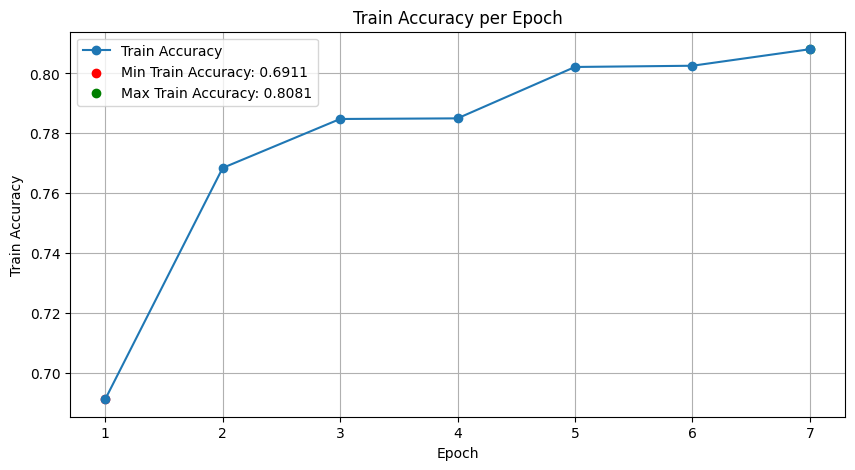

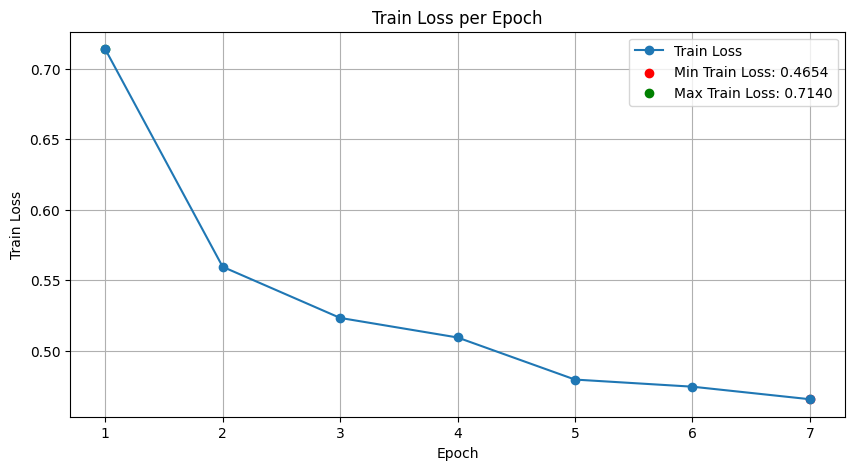

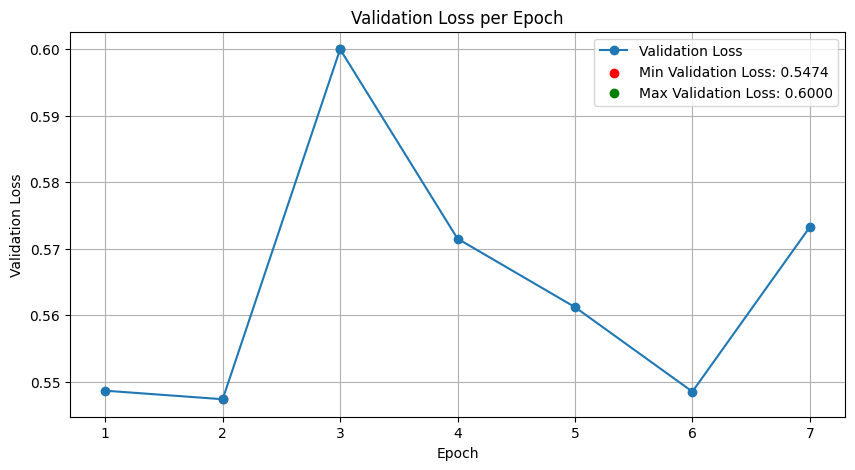

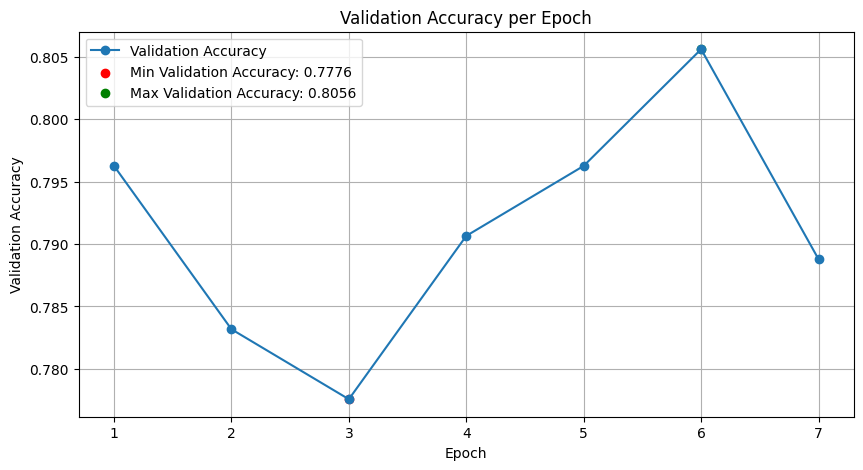

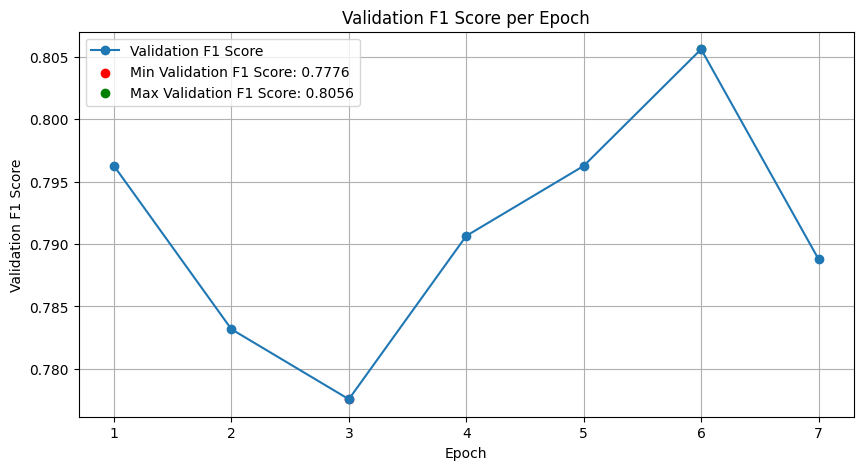

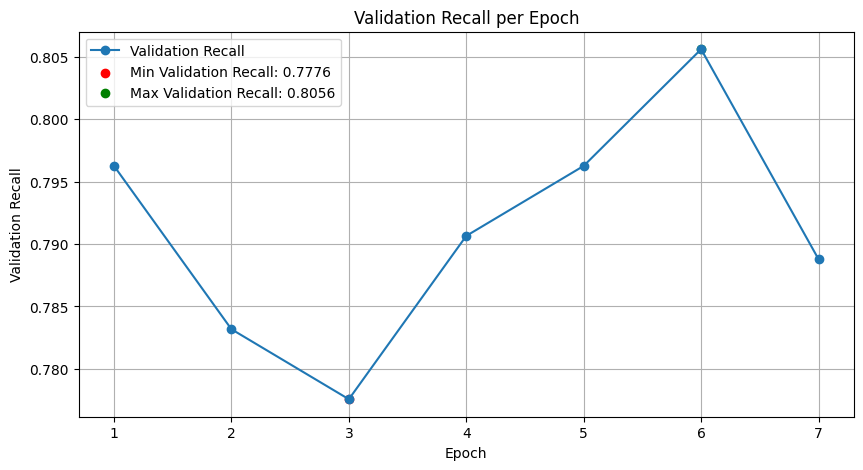

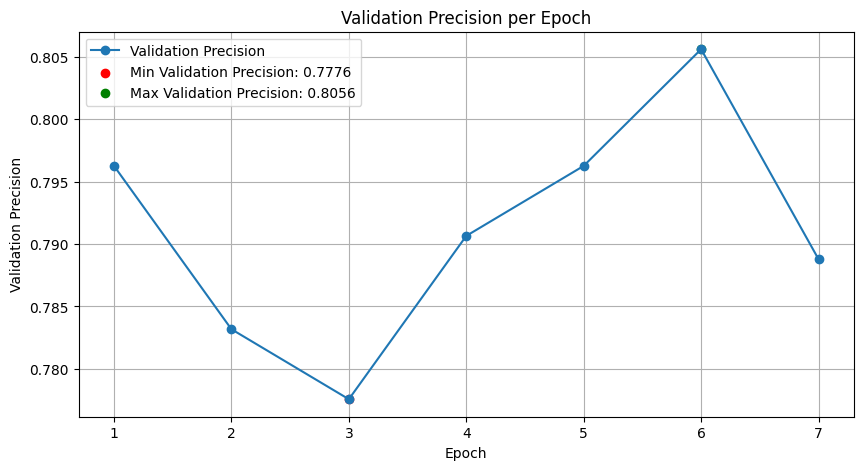

Metrics for OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, 

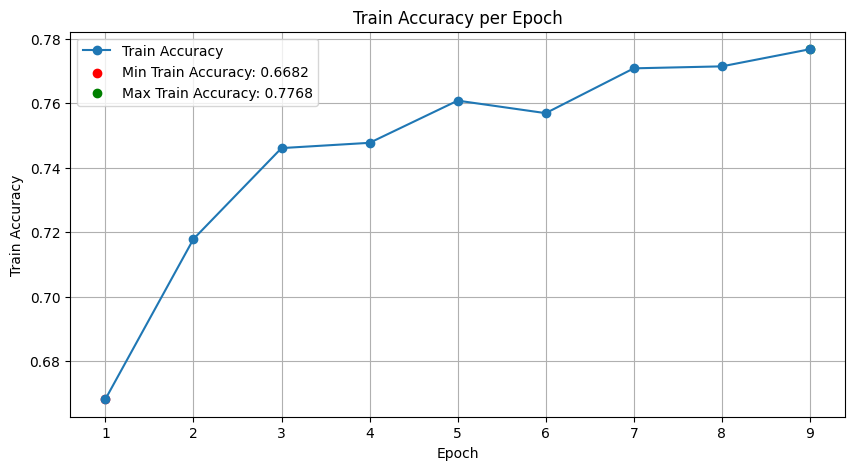

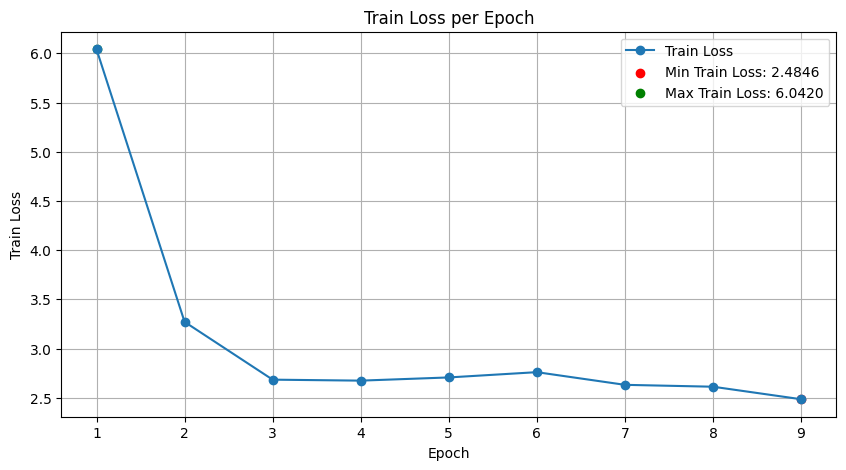

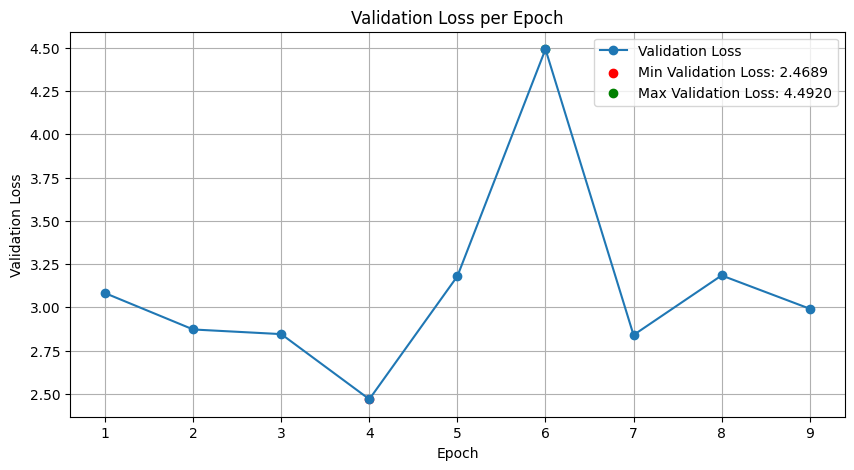

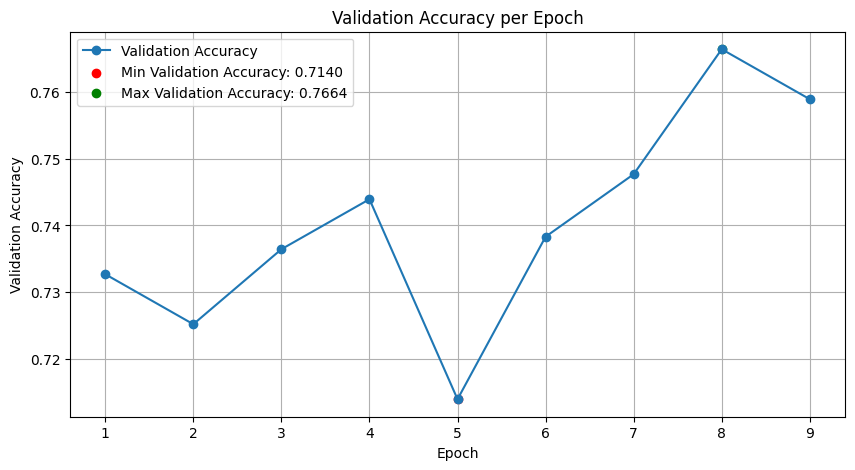

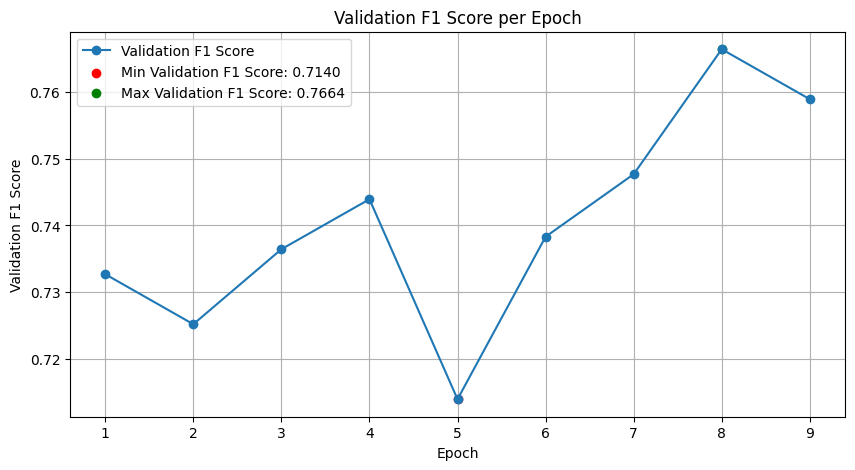

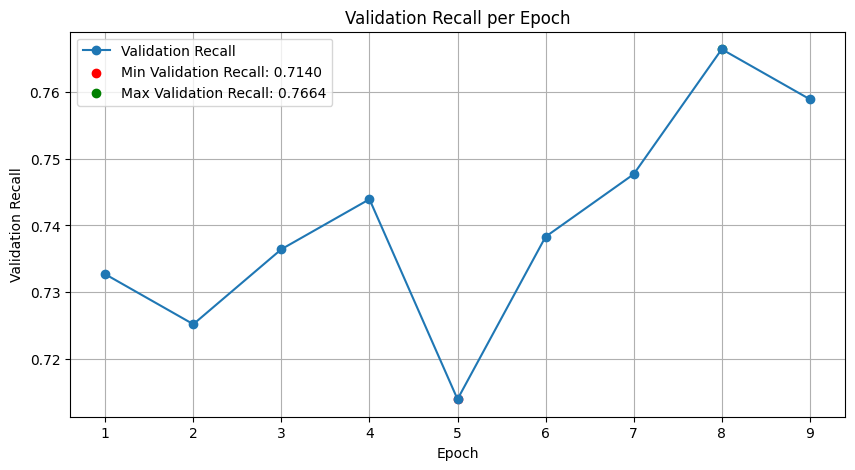

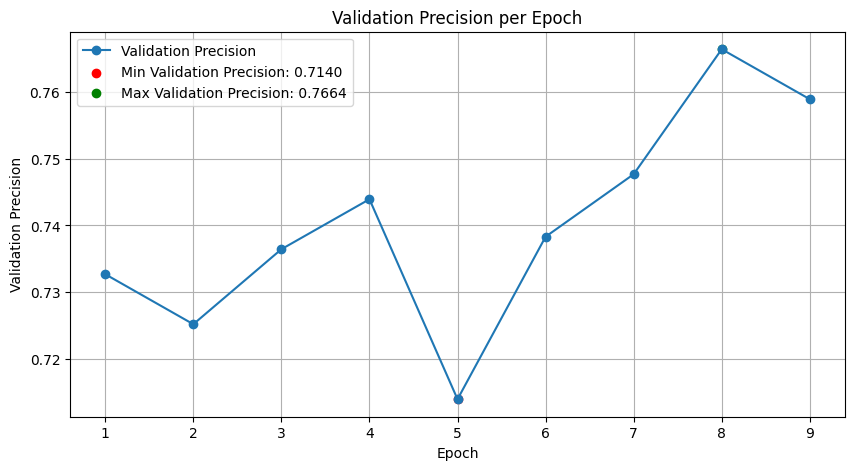

Metrics for OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, 

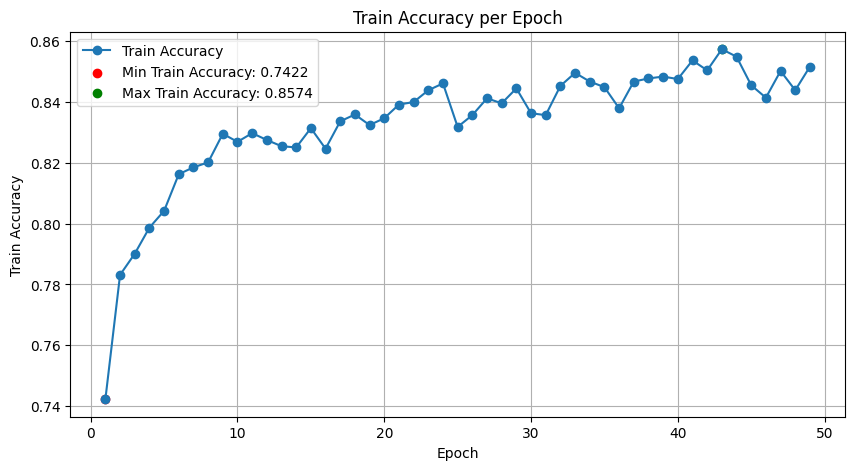

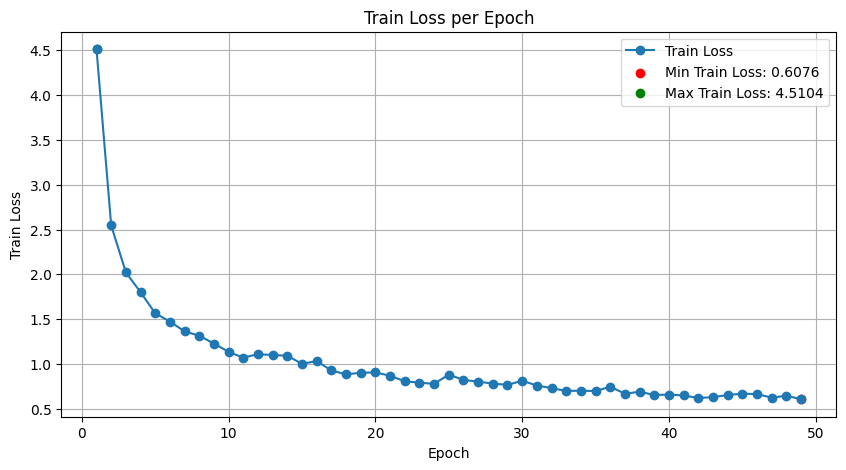

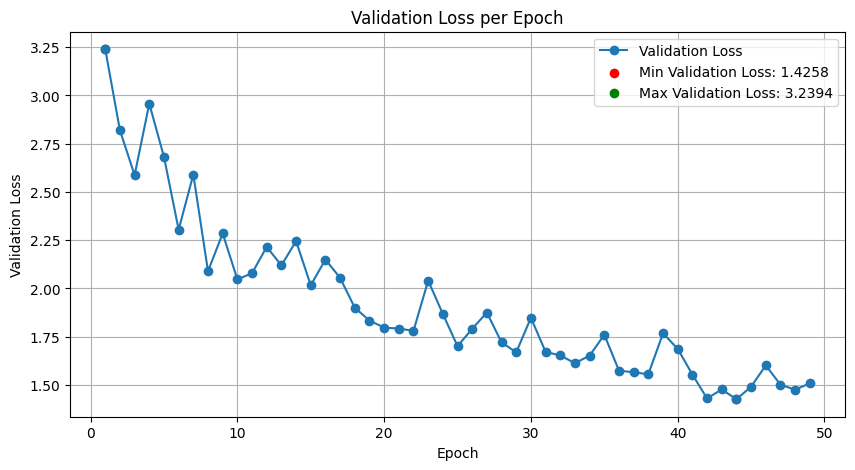

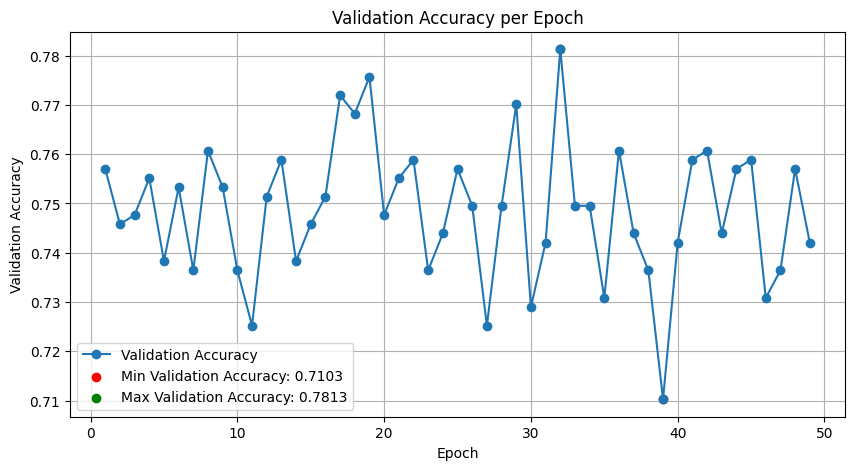

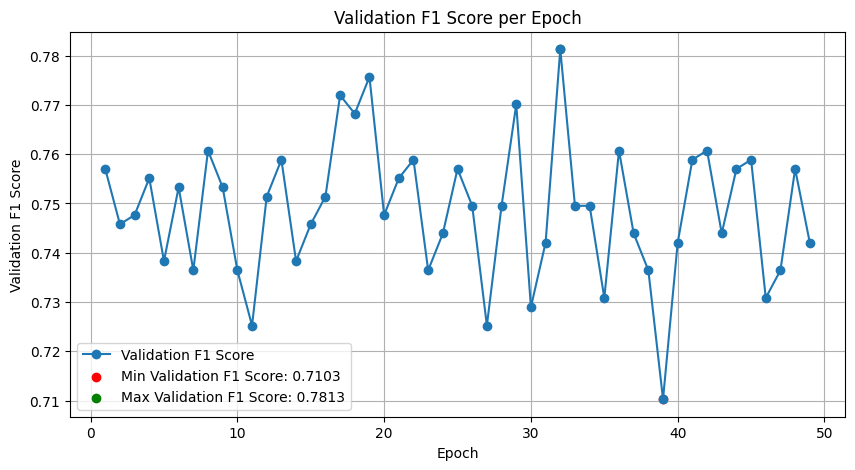

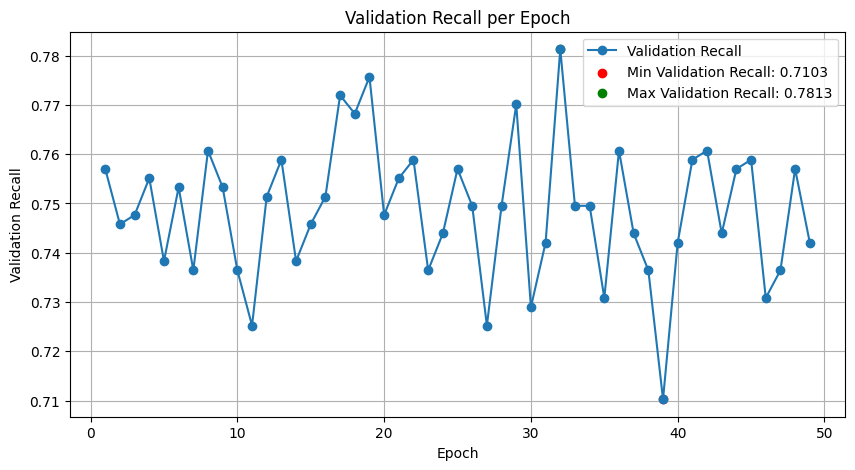

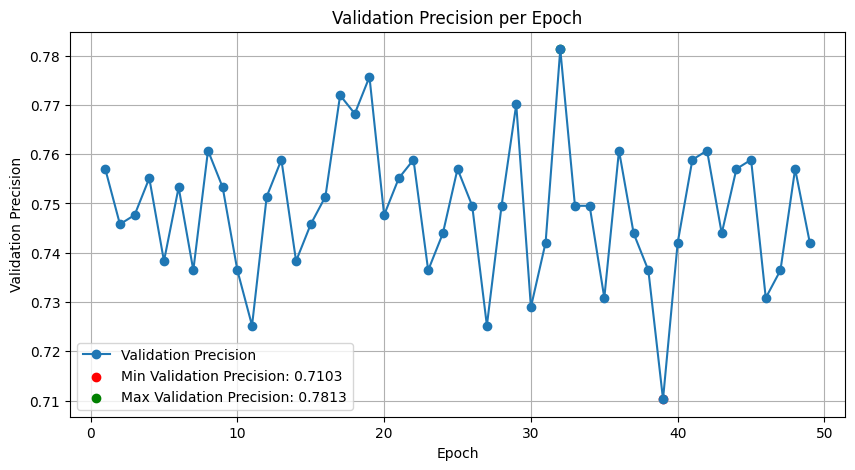

Metrics for OptimizedModule(
  (_orig_mod): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, 

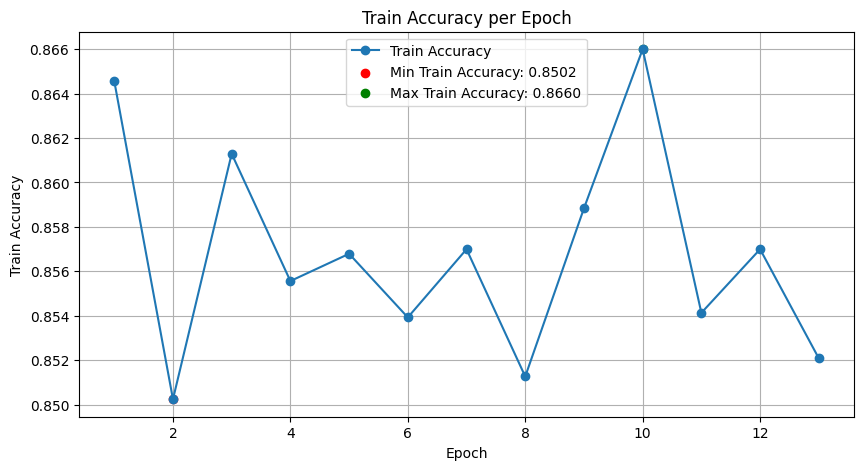

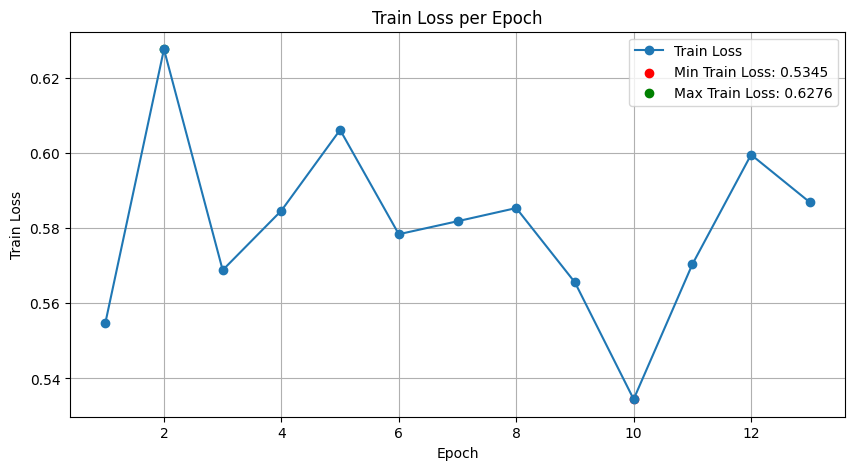

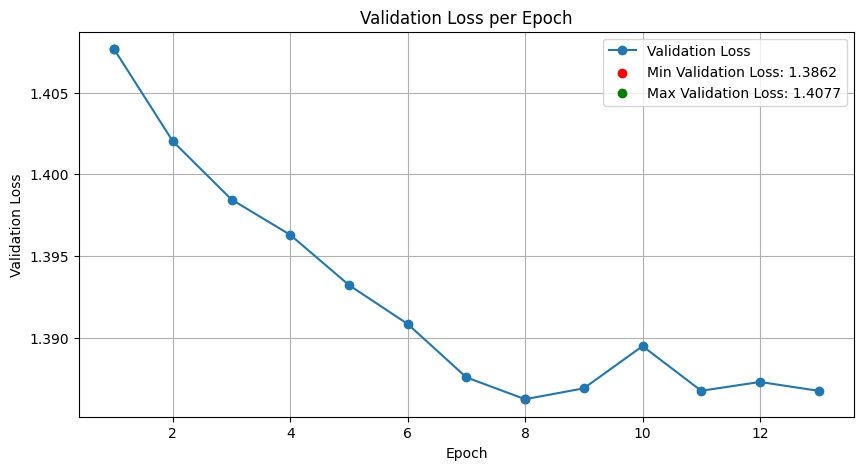

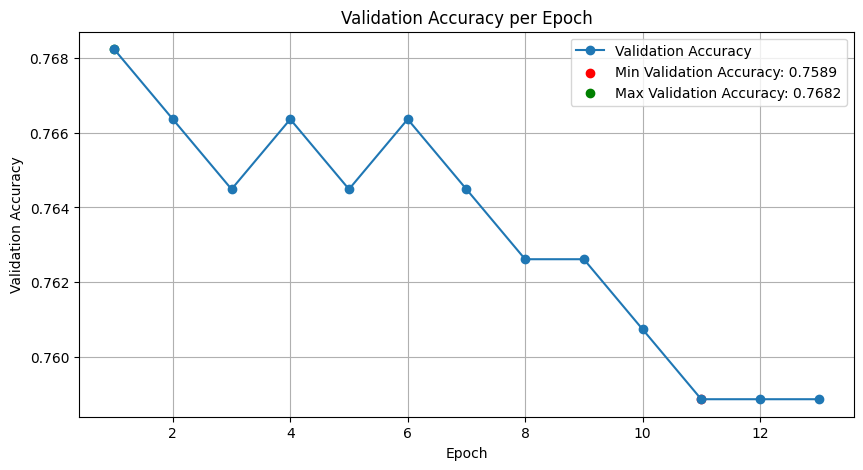

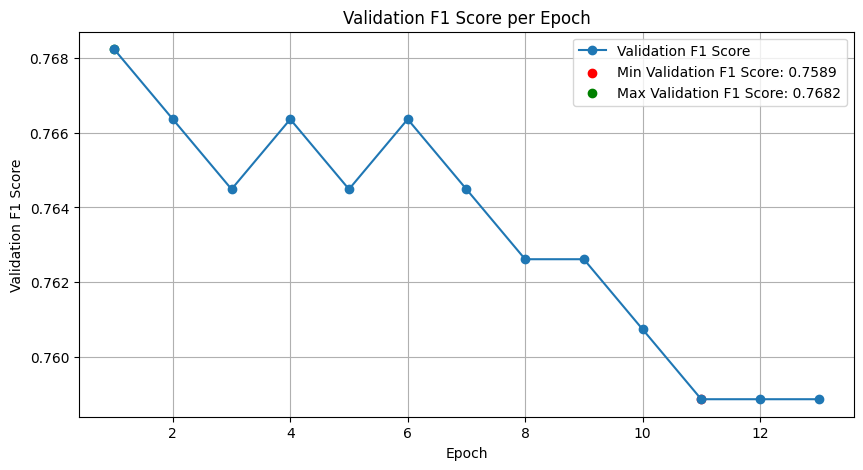

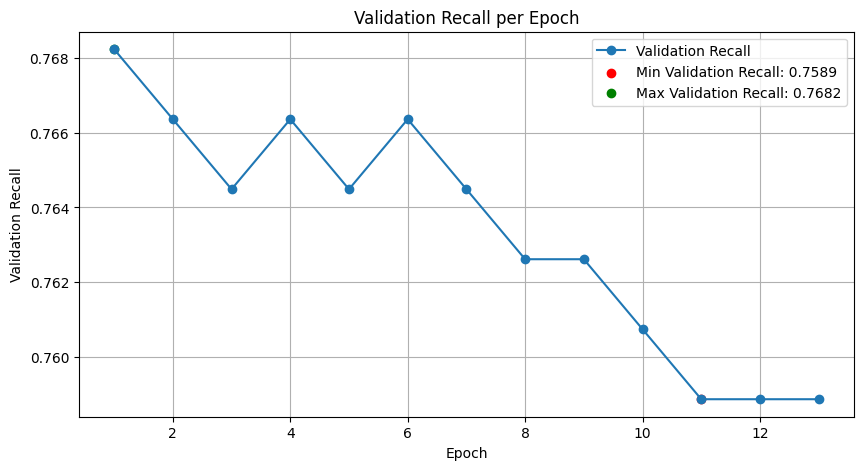

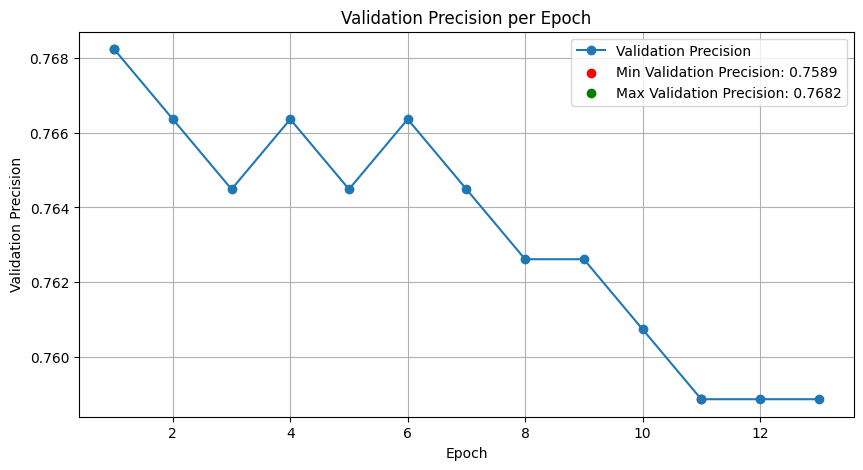

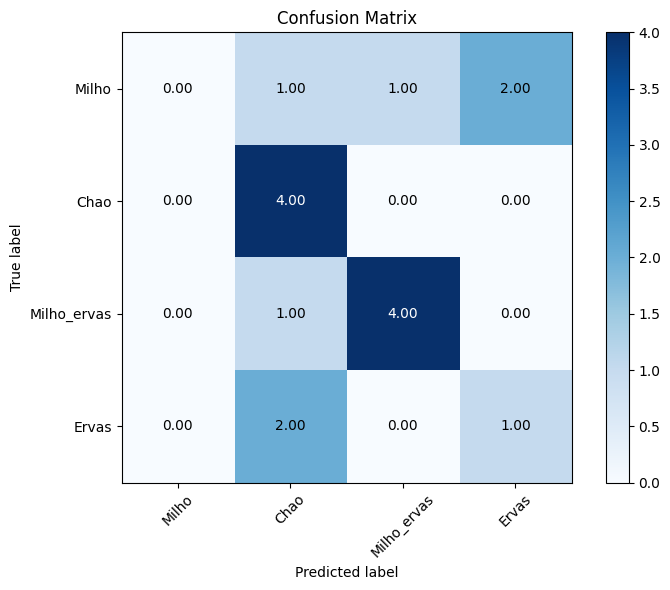

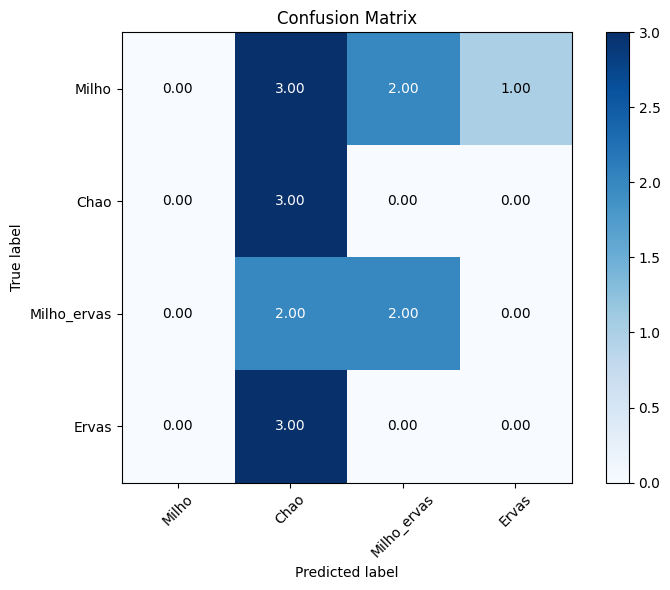

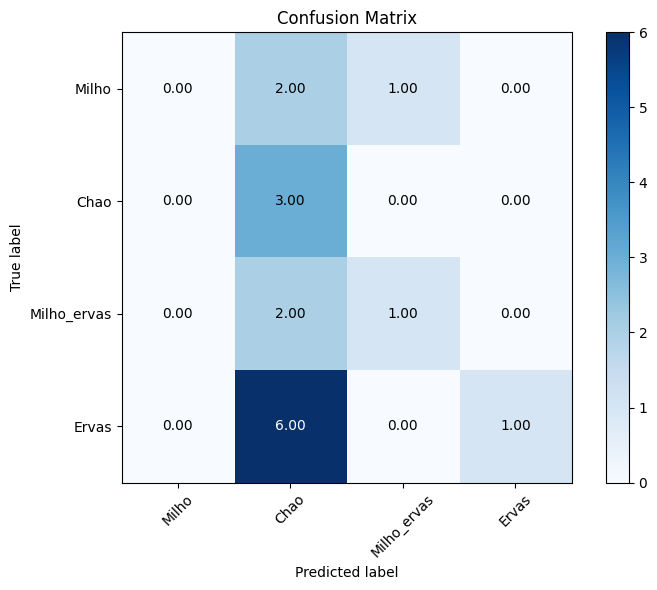

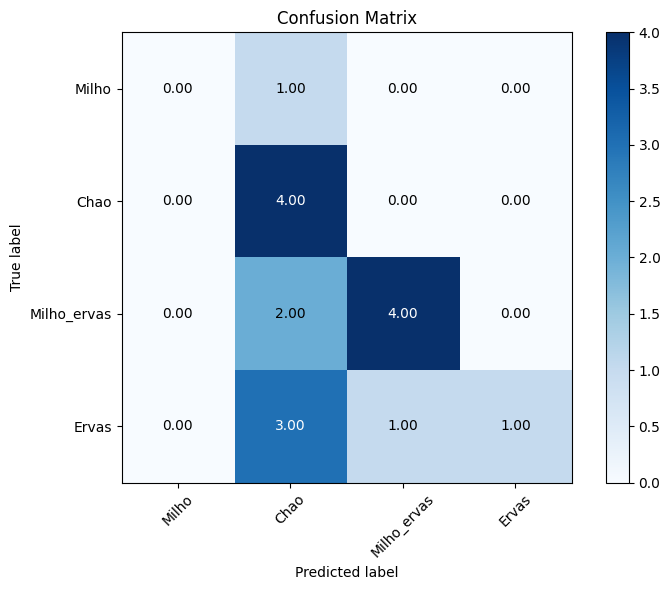

In [31]:
plot_metrics_per_model(alexnet_results)
evaluate_model(alexnet_results, classes, device, valid_transform)

# VGG19_bn (with batch normalization) Exprimentation

In [22]:
# Load the pre-trained VGG19 model with batch normalization
vgg19_bn_model = models.vgg19_bn(weights='IMAGENET1K_V1')

# Freeze the parameters of the pre-trained layers
for param in vgg19_bn_model.parameters():
    param.requires_grad = False

# Modify the last layer of the classifier to output 4 classes
num_features = vgg19_bn_model.classifier[6].in_features
vgg19_bn_model.classifier[6] = nn.Linear(num_features, 4)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 162MB/s]  


In [23]:
weights = models.VGG19_Weights.DEFAULT
preprocess = weights.transforms()
vgg19_bn_model = vgg19_bn_model.to(config.device)

train_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino",transform=preprocess)
valid_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Validação", transform=preprocess)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [25]:
from torch.optim import Adam, RMSprop, Adagrad, SGD

ce = nn.CrossEntropyLoss()
es = EarlyStopping()

def Loss(preds, targets):
    ce_loss = ce(preds, targets)
    return ce_loss

def make_model(input_model, optimizer_type, lr):
    if optimizer_type == 'Adam':
        optimizer = Adam(input_model.parameters(), lr=lr)
    elif optimizer_type == 'Adagrad':
        optimizer = Adagrad(input_model.parameters(), lr=lr)
    else:
        raise ValueError("Invalid optimizer type. Supported types are 'Adam', 'RMSprop', 'Adagrad', and 'SGD'.")

    model = torch.compile(input_model, backend="aot_eager").to(config.device)
    return model, optimizer

# Define your input_model and optimizers here
input_model = BaselineCNN()

optimizers = ['Adam', 'Adagrad']
learning_rates = [0.001, 0.01]  # Define your learning rates


# Store the results for each combination of input_model, optimizer, and lr
vgg19_bn_results = {}

for optimizer_type, lr in zip(optimizers, learning_rates):
    model, optimizer = make_model(vgg19_bn_model, optimizer_type, lr)

    train_acc_per_epoch, train_loss_per_epoch, valid_loss_per_epoch, valid_acc_per_epoch, valid_f1_per_epoch, valid_recall_per_epoch, valid_precision_per_epoch, model = run_train(model, train_dataloader, valid_dataloader, optimizer)
    print()
    print(f"storing results for {optimizer_type, lr, model}")
    # Store the results in the dictionary
    vgg19_bn_results[(input_model, optimizer_type, lr)] = {
        'train_acc_per_epoch': train_acc_per_epoch,
        'train_loss_per_epoch': train_loss_per_epoch,
        'valid_loss_per_epoch': valid_loss_per_epoch,
        'valid_acc_per_epoch': valid_acc_per_epoch,
        'valid_f1_per_epoch': valid_f1_per_epoch,
        'valid_recall_per_epoch': valid_recall_per_epoch,
        'valid_precision_per_epoch': valid_precision_per_epoch,
        'model': model
    }

####################
       Epoch: 0  
####################


100%|██████████| 34/34 [00:11<00:00,  2.97it/s]


Epoch : 0 Train Loss : tensor(0.8111, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6290, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7308, device='cuda:0') Valid f1 :  tensor(0.7308, device='cuda:0') Valid Recall :  tensor(0.7308, device='cuda:0') Valid Precision :  tensor(0.7308, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:05<00:00,  5.90it/s]


Epoch : 1 Train Loss : tensor(0.7266, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5611, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7738, device='cuda:0') Valid f1 :  tensor(0.7738, device='cuda:0') Valid Recall :  tensor(0.7738, device='cuda:0') Valid Precision :  tensor(0.7738, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch : 2 Train Loss : tensor(0.6723, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5532, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7794, device='cuda:0') Valid f1 :  tensor(0.7794, device='cuda:0') Valid Recall :  tensor(0.7794, device='cuda:0') Valid Precision :  tensor(0.7794, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:05<00:00,  5.95it/s]


Epoch : 3 Train Loss : tensor(0.6597, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6040, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7551, device='cuda:0') Valid f1 :  tensor(0.7551, device='cuda:0') Valid Recall :  tensor(0.7551, device='cuda:0') Valid Precision :  tensor(0.7551, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:05<00:00,  5.86it/s]


Epoch : 4 Train Loss : tensor(0.6544, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5671, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7776, device='cuda:0') Valid f1 :  tensor(0.7776, device='cuda:0') Valid Recall :  tensor(0.7776, device='cuda:0') Valid Precision :  tensor(0.7776, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:05<00:00,  6.02it/s]


Epoch : 5 Train Loss : tensor(0.6610, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5951, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7607, device='cuda:0') Valid f1 :  tensor(0.7607, device='cuda:0') Valid Recall :  tensor(0.7607, device='cuda:0') Valid Precision :  tensor(0.7607, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:05<00:00,  6.12it/s]


Epoch : 6 Train Loss : tensor(0.6351, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6027, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7607, device='cuda:0') Valid f1 :  tensor(0.7607, device='cuda:0') Valid Recall :  tensor(0.7607, device='cuda:0') Valid Precision :  tensor(0.7607, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:05<00:00,  6.04it/s]


Epoch : 7 Train Loss : tensor(0.6418, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5453, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7757, device='cuda:0') Valid f1 :  tensor(0.7757, device='cuda:0') Valid Recall :  tensor(0.7757, device='cuda:0') Valid Precision :  tensor(0.7757, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:05<00:00,  6.09it/s]


Epoch : 8 Train Loss : tensor(0.6495, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5429, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7701, device='cuda:0') Valid f1 :  tensor(0.7701, device='cuda:0') Valid Recall :  tensor(0.7701, device='cuda:0') Valid Precision :  tensor(0.7701, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch : 9 Train Loss : tensor(0.6554, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5725, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7664, device='cuda:0') Valid f1 :  tensor(0.7664, device='cuda:0') Valid Recall :  tensor(0.7664, device='cuda:0') Valid Precision :  tensor(0.7664, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch : 10 Train Loss : tensor(0.6536, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5793, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7495, device='cuda:0') Valid f1 :  tensor(0.7495, device='cuda:0') Valid Recall :  tensor(0.7495, device='cuda:0') Valid Precision :  tensor(0.7495, device='cuda:0')
####################
       Epoch: 11  
####################


100%|██████████| 34/34 [00:05<00:00,  5.99it/s]


Epoch : 11 Train Loss : tensor(0.6506, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5854, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7551, device='cuda:0') Valid f1 :  tensor(0.7551, device='cuda:0') Valid Recall :  tensor(0.7551, device='cuda:0') Valid Precision :  tensor(0.7551, device='cuda:0')
####################
       Epoch: 12  
####################


100%|██████████| 34/34 [00:05<00:00,  6.08it/s]


Epoch : 12 Train Loss : tensor(0.6334, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5877, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7607, device='cuda:0') Valid f1 :  tensor(0.7607, device='cuda:0') Valid Recall :  tensor(0.7607, device='cuda:0') Valid Precision :  tensor(0.7607, device='cuda:0')
####################
       Epoch: 13  
####################


100%|██████████| 34/34 [00:05<00:00,  6.03it/s]


Epoch : 13 Train Loss : tensor(0.6370, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.6109, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7701, device='cuda:0') Valid f1 :  tensor(0.7701, device='cuda:0') Valid Recall :  tensor(0.7701, device='cuda:0') Valid Precision :  tensor(0.7701, device='cuda:0')

storing results for ('Adam', 0.001, OptimizedModule(
  (_orig_mod): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch : 0 Train Loss : tensor(0.7569, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5833, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7570, device='cuda:0') Valid f1 :  tensor(0.7570, device='cuda:0') Valid Recall :  tensor(0.7570, device='cuda:0') Valid Precision :  tensor(0.7570, device='cuda:0')
####################
       Epoch: 1  
####################


100%|██████████| 34/34 [00:05<00:00,  6.14it/s]


Epoch : 1 Train Loss : tensor(0.6473, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5974, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7626, device='cuda:0') Valid f1 :  tensor(0.7626, device='cuda:0') Valid Recall :  tensor(0.7626, device='cuda:0') Valid Precision :  tensor(0.7626, device='cuda:0')
####################
       Epoch: 2  
####################


100%|██████████| 34/34 [00:05<00:00,  6.11it/s]


Epoch : 2 Train Loss : tensor(0.6204, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5601, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7794, device='cuda:0') Valid f1 :  tensor(0.7794, device='cuda:0') Valid Recall :  tensor(0.7794, device='cuda:0') Valid Precision :  tensor(0.7794, device='cuda:0')
####################
       Epoch: 3  
####################


100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Epoch : 3 Train Loss : tensor(0.6186, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5508, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7888, device='cuda:0') Valid f1 :  tensor(0.7888, device='cuda:0') Valid Recall :  tensor(0.7888, device='cuda:0') Valid Precision :  tensor(0.7888, device='cuda:0')
####################
       Epoch: 4  
####################


100%|██████████| 34/34 [00:05<00:00,  5.90it/s]


Epoch : 4 Train Loss : tensor(0.6056, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5560, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7776, device='cuda:0') Valid f1 :  tensor(0.7776, device='cuda:0') Valid Recall :  tensor(0.7776, device='cuda:0') Valid Precision :  tensor(0.7776, device='cuda:0')
####################
       Epoch: 5  
####################


100%|██████████| 34/34 [00:05<00:00,  6.02it/s]


Epoch : 5 Train Loss : tensor(0.6032, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5330, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7888, device='cuda:0') Valid f1 :  tensor(0.7888, device='cuda:0') Valid Recall :  tensor(0.7888, device='cuda:0') Valid Precision :  tensor(0.7888, device='cuda:0')
####################
       Epoch: 6  
####################


100%|██████████| 34/34 [00:05<00:00,  6.11it/s]


Epoch : 6 Train Loss : tensor(0.5910, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5439, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7832, device='cuda:0') Valid f1 :  tensor(0.7832, device='cuda:0') Valid Recall :  tensor(0.7832, device='cuda:0') Valid Precision :  tensor(0.7832, device='cuda:0')
####################
       Epoch: 7  
####################


100%|██████████| 34/34 [00:05<00:00,  6.01it/s]


Epoch : 7 Train Loss : tensor(0.5971, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5396, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7850, device='cuda:0') Valid f1 :  tensor(0.7850, device='cuda:0') Valid Recall :  tensor(0.7850, device='cuda:0') Valid Precision :  tensor(0.7850, device='cuda:0')
####################
       Epoch: 8  
####################


100%|██████████| 34/34 [00:05<00:00,  6.12it/s]


Epoch : 8 Train Loss : tensor(0.6106, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5461, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7757, device='cuda:0') Valid f1 :  tensor(0.7757, device='cuda:0') Valid Recall :  tensor(0.7757, device='cuda:0') Valid Precision :  tensor(0.7757, device='cuda:0')
####################
       Epoch: 9  
####################


100%|██████████| 34/34 [00:05<00:00,  6.10it/s]


Epoch : 9 Train Loss : tensor(0.5808, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5455, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7888, device='cuda:0') Valid f1 :  tensor(0.7888, device='cuda:0') Valid Recall :  tensor(0.7888, device='cuda:0') Valid Precision :  tensor(0.7888, device='cuda:0')
####################
       Epoch: 10  
####################


100%|██████████| 34/34 [00:05<00:00,  6.13it/s]

Epoch : 10 Train Loss : tensor(0.5903, device='cuda:0', dtype=torch.float64) Valid Loss : tensor(0.5565, device='cuda:0', dtype=torch.float64) Valid Accuracy : tensor(0.7682, device='cuda:0') Valid f1 :  tensor(0.7682, device='cuda:0') Valid Recall :  tensor(0.7682, device='cuda:0') Valid Precision :  tensor(0.7682, device='cuda:0')

storing results for ('Adagrad', 0.01, OptimizedModule(
  (_orig_mod): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

Metrics for OptimizedModule(
  (_orig_mod): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, s

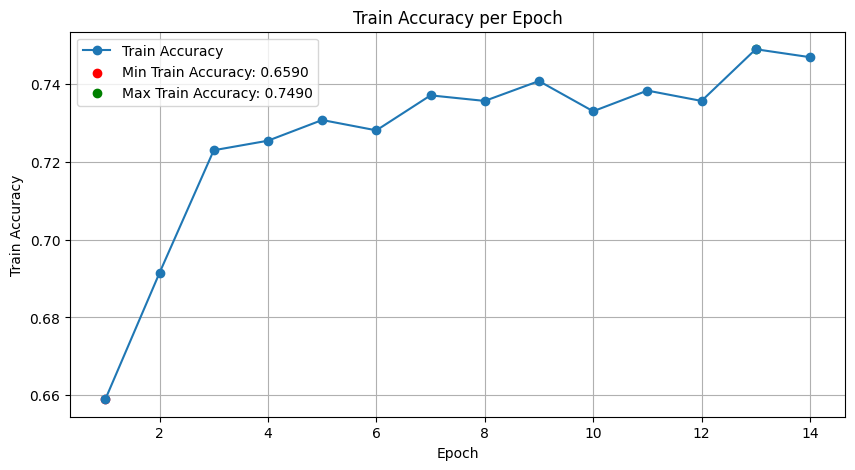

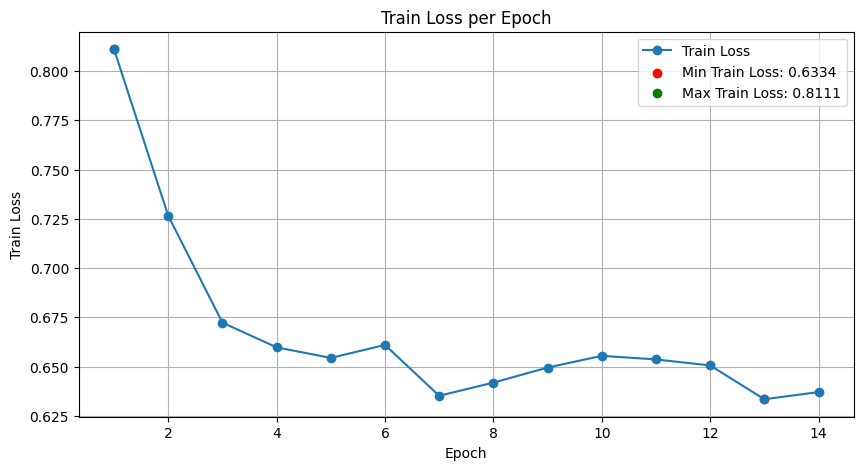

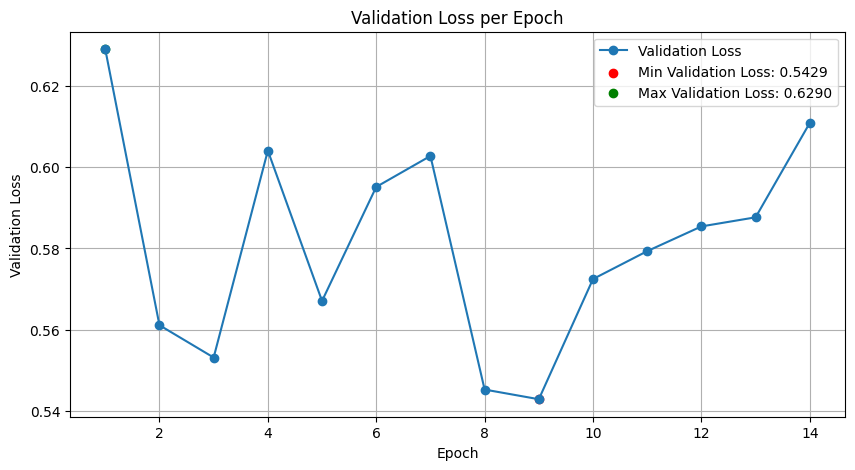

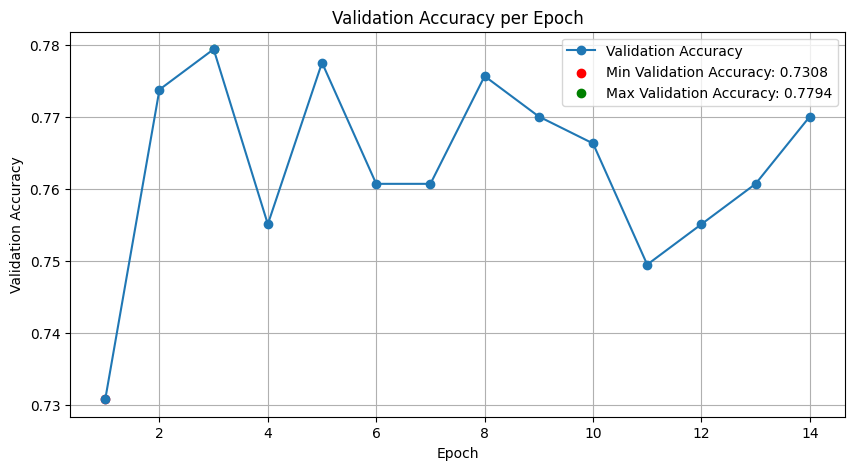

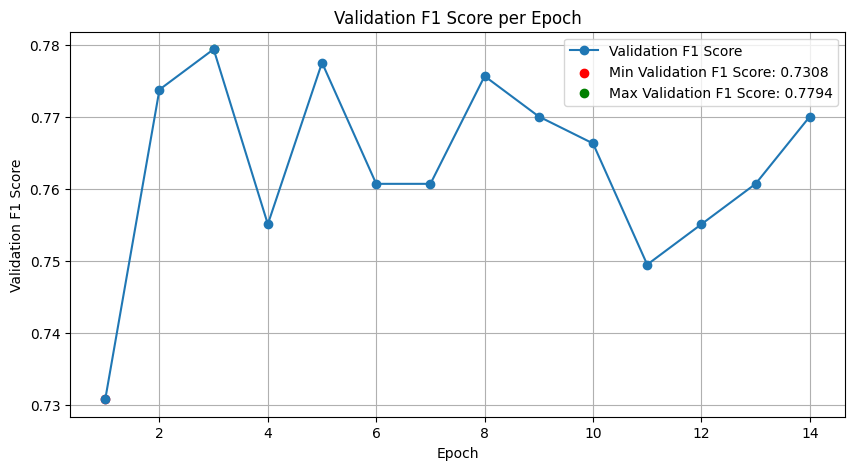

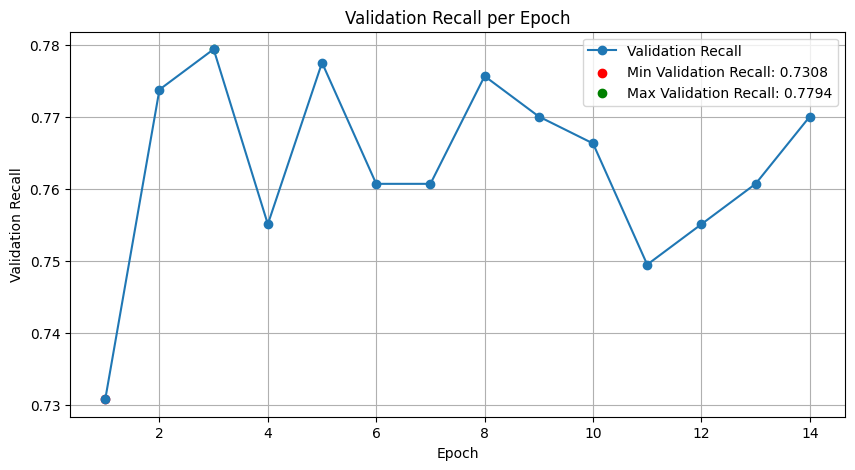

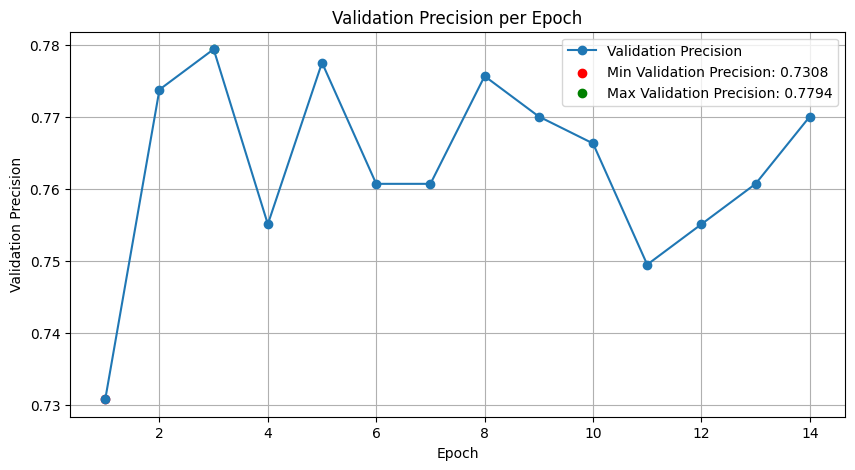

Metrics for OptimizedModule(
  (_orig_mod): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, s

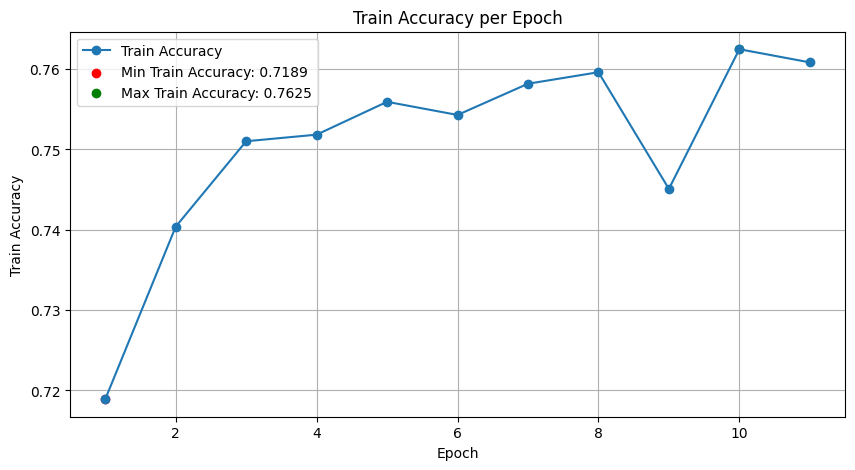

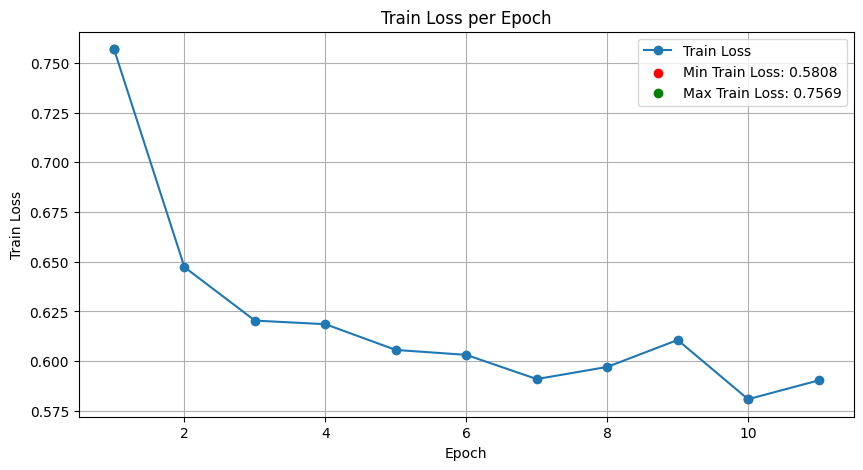

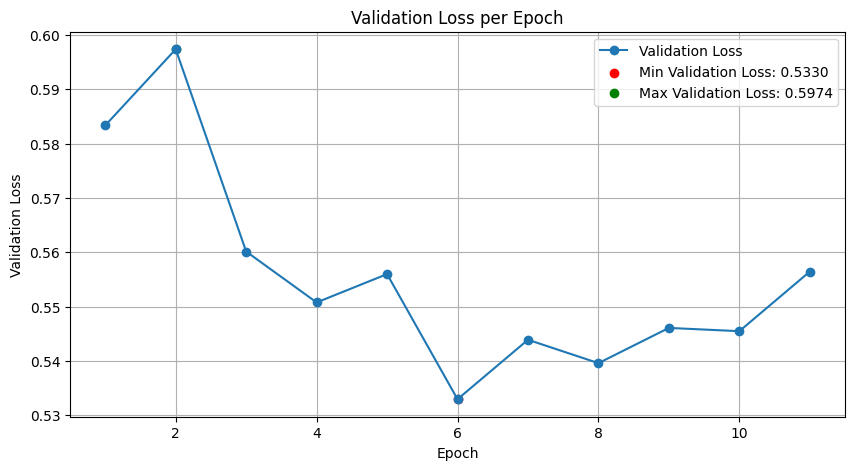

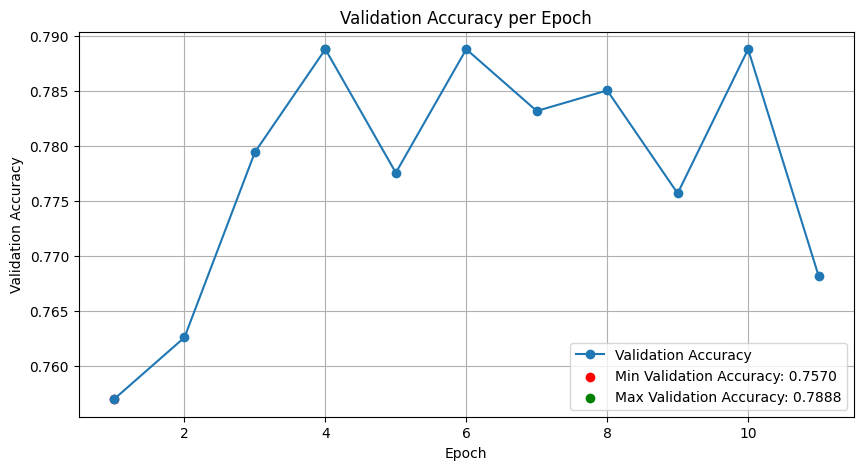

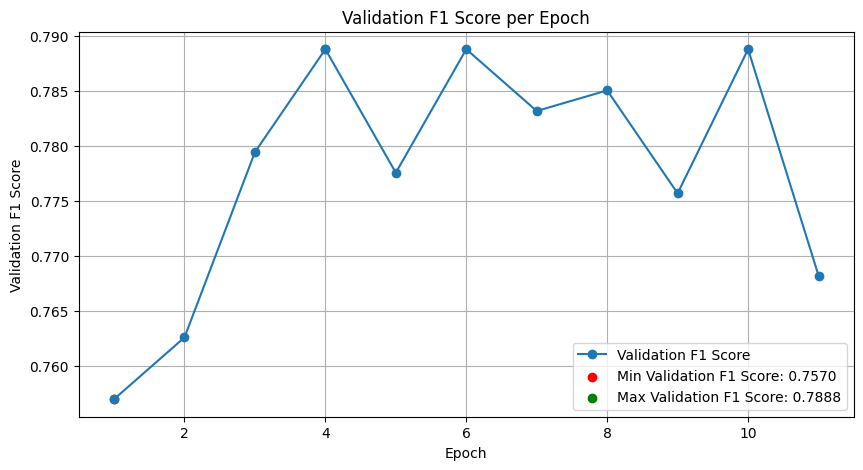

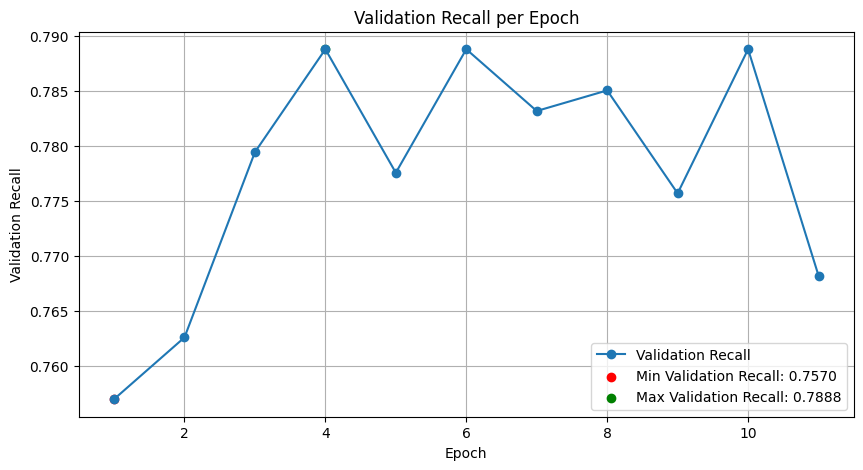

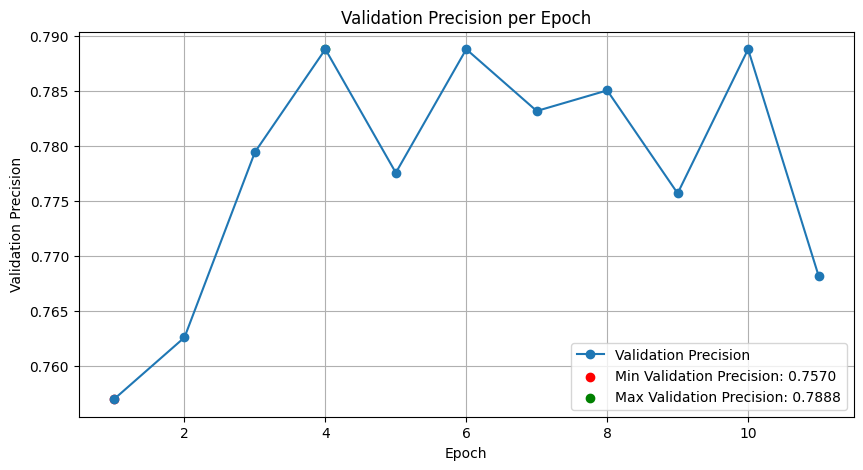

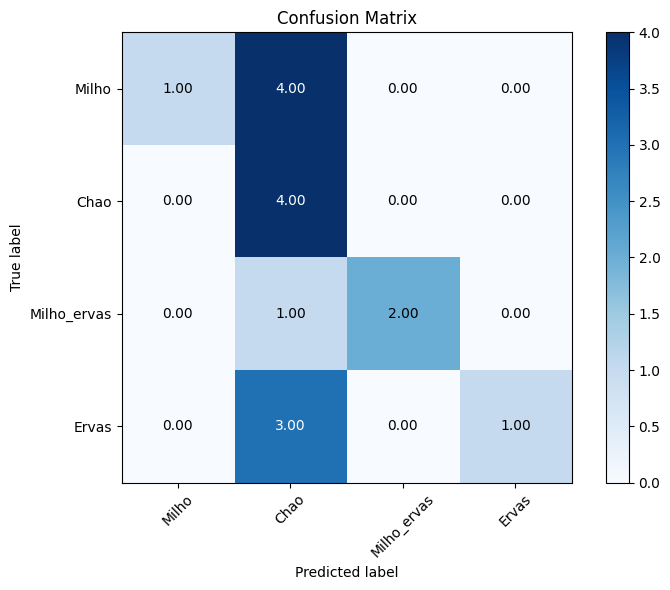

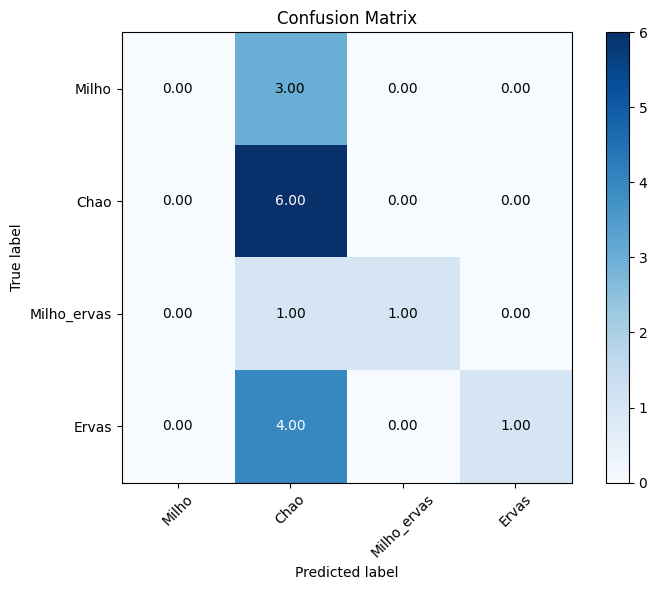

In [31]:
plot_metrics_per_model(vgg19_bn_results)
evaluate_model(vgg19_bn_results, classes, device, valid_transform)

# Models Explaination

In [32]:
def get_predict(model,imgs):
    imgs = imgs.to(config.DEVICE, dtype=torch.float)
    preds = []
    with torch.no_grad():
        pred = model(imgs)
        #pred = (nn.Softmax()(pred)>0.5).double()  +
        preds.append(pred)
    imgs  = imgs.cpu().detach()
    preds = torch.mean(torch.stack(preds, dim=0), dim=0)
    return preds

In [33]:
!pip install -q git+https://github.com/jacobgil/pytorch-grad-cam.git

In [64]:
test_data = CornCustomDataset(root_dir="/kaggle/input/labeledcorndataset/ImagensTCCRotuladas/ImagensTCCRotuladas/Teste", transform=valid_transform)
# Create the test dataloader
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)
# Retrieve a batch of test images and labels
test_images, test_labels = next(iter(test_dataloader))
# Moving the images and labels to GPU
test_images = test_images.to(device, dtype=torch.float)
test_labels = test_labels.to(device, dtype=torch.float)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load model (assuming 'YourModel' is defined elsewhere)
model.to(device)  # Move model to device

# Specify target layer (replace 'classifier' with the name of the layer you want to visualize)
target_layer = 'classifier'

# Create GradCAM object
cam = GradCAM(model=model, target_layer=target_layer)

# Iterate through test images and compute GradCAM
for i, (test_images, test_labels) in enumerate(test_dataloader):
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    
    for j in range(len(test_images)):
        image = test_images[j].unsqueeze(0)
        target_class = None  # If you want to visualize the most probable class, you can set this to None
        
        # Compute GradCAM
        cam_image = cam(input_tensor=image, target_category=target_class)
        
        # Convert the image tensor to numpy array and show the GradCAM overlay on the original image
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        cam_image_np = show_cam_on_image(image_np, cam_image)
        
        # Display the original image and its GradCAM
        plt.imshow(cam_image_np)
        plt.axis('off')
        plt.show()
